The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
No GPU available, using the CPU instead.


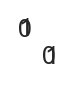

In [20]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump, get_palette
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

import torch
from torch import optim, nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'

In [25]:
sns.color_palette(get_palette('hsv', n_colors=4))

[(0.7029398794104678, 1.0, 0.0),
 (0.0, 1.0, 0.617278533938476),
 (0.0, 0.062501968751969, 1.0),
 (1.0, 0.0, 0.742280060294766)]

In [24]:
sns.color_palette('hsv', n_colors=4)

[(0.8187488187488188, 1.0, 0.0),
 (0.0, 1.0, 0.3625004724974957),
 (0.0, 0.4562523625023627, 1.0),
 (0.724998818748819, 0.0, 1.0)]

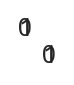

In [3]:
sns.set_palette(NEWPAL)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

In [4]:
FIGDIR = '../../../writing/230131_cedar_paper_1/figures/'

In [200]:
from sklearn.metrics import roc_auc_score, roc_curve
def get_roc_curve_auc(df, targetcol, scorecol, neg=False):
    if neg:
        fpr, tpr, _ = roc_curve(df[targetcol], -1* df[scorecol])
        auc = roc_auc_score(df[targetcol], -1* df[scorecol])
        auc01 = roc_auc_score(df[targetcol], -1* df[scorecol], max_fpr=0.1)
    else:
        fpr, tpr, _ = roc_curve(df[targetcol], df[scorecol])
        auc = roc_auc_score(df[targetcol], df[scorecol])
        auc01 = roc_auc_score(df[targetcol], df[scorecol], max_fpr=0.1)
    return fpr, tpr, auc, auc01

# init

## reloading datasets

In [4]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
# merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')
nepdb = pd.read_csv('../data/mutant/230124_nepdb_filtered_scored.csv')
nepdb.head()

Peptide   wild_type        HLA  agg_label  mut_len  wt_len seq_id  \
0   AFGSAHLFR   AFGSAHLYR  HLA-A3101          1        9       9  seq_1   
1   AIANRIKFK   AIANRIKSK  HLA-A1101          0        9       9  seq_4   
2   AICKPLHYV   AICKPLHYM  HLA-A0201          0        9       9  seq_5   
3  AIPAMVVPNV  AIPAMVVPNA  HLA-A0201          0       10      10  seq_6   
4  ALEVLQSIPY  APEVLQSIPY  HLA-A0101          0       10      10  seq_7   

   Pos_mut Peptide_mut   core_mut  ... core_blsm_mut_score  aliphatic_index  \
0        0   AFGSAHLFR  AFGSAHLFR  ...                   3        65.555556   
1        0   AIANRIKFK  AIANRIKFK  ...                  -2       108.888889   
2        0   AICKPLHYV  AICKPLHYV  ...                   1       130.000000   
3        0  AIPAMVVPNV  AIPAVVPNV  ...                   0       146.000000   
4        0  ALEVLQSIPY  ALEVLQSIY  ...                  -3       156.000000   

      boman hydrophobicity isoelectric_point     VHSE1     VHSE3     VHSE7  \
0  0.837778       0.455556         10.551759  0.214444 -0.278889  0.193333   
1  1.802222      -0.044444         11.823055 -0.048889  0.125556  0.484444   
2 -0.735556       0.755556          8.530526  0.327778  0.046667 -0.017778   
3 -1.637000       1.590000          6.100000  0.431000 -0.385000 -0.067000   
4 -0.472000       0.740000          3.849983  0.292000 -0.062000 -0.096000   

      VHSE8  trueHLA_EL_rank  
0 -0.192222           0.2470  
1 -0.125556           0.1380  
2  0.263333           0.3610  
3  0.446000           2.2606  
4  0.088000           0.6230  

[5 rows x 39 columns]

In [5]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230125_cedar_aligned_icore.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230125_prime_aligned_icore.csv')
ibel_aligned = pd.read_csv('../data/aligned_icore/230125_ibel_aligned_icore.csv')
nepdb_aligned = pd.read_csv('../data/aligned_icore/230125_nepdb_aligned_icore.csv')

In [65]:
cedar_expr = pd.read_csv('../data/pepx/230125_cedar_related_pepx_fold.csv')
prime_expr = pd.read_csv('../data/pepx/230125_prime_related_pepx.csv')
ibel_expr = pd.read_csv('../data/pepx/230125_ibel_normal_pepx.csv')
nepdb_expr = pd.read_csv('../data/pepx/230125_nepdb_normal_pepx.csv')

In [76]:
cedar_aligned_expr = pd.read_csv('../data/pepx/230125_cedar_aligned_pepx_fold.csv')
prime_aligned_expr = pd.read_csv('../data/pepx/230125_prime_aligned_pepx.csv')
ibel_aligned_expr = pd.read_csv('../data/pepx/230125_ibel_aligned_pepx.csv')
nepdb_aligned_expr = pd.read_csv('../data/pepx/230125_nepdb_aligned_pepx.csv')

In [8]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve

3480


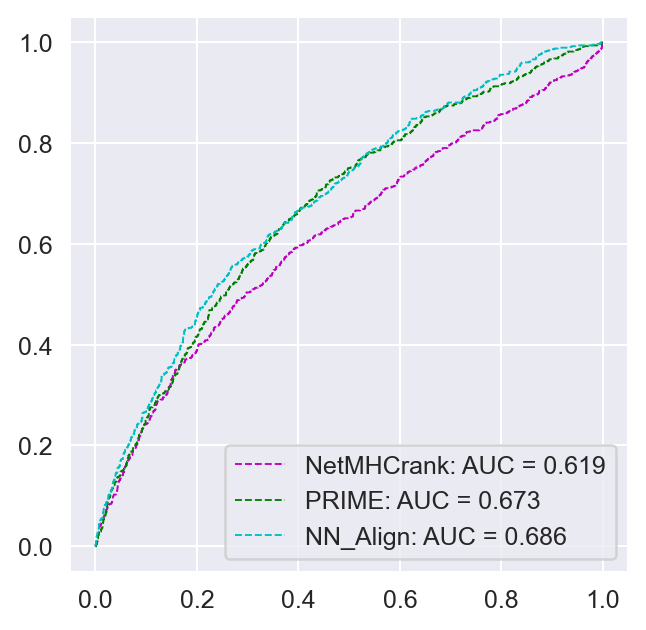

In [10]:
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)
a.legend()

In [11]:
from src.baselines import plot_related_baseline_roc

In [12]:
cpeps = cedar_related_baseline.Peptide.values
ppeps = prime_related_baseline.Peptide.values
cp_common_peps = [x for x in cpeps if x in ppeps]
len(ibel.query('Peptide not in @cpeps and Peptide not in @ppeps')), len(ibel)

(86, 94)

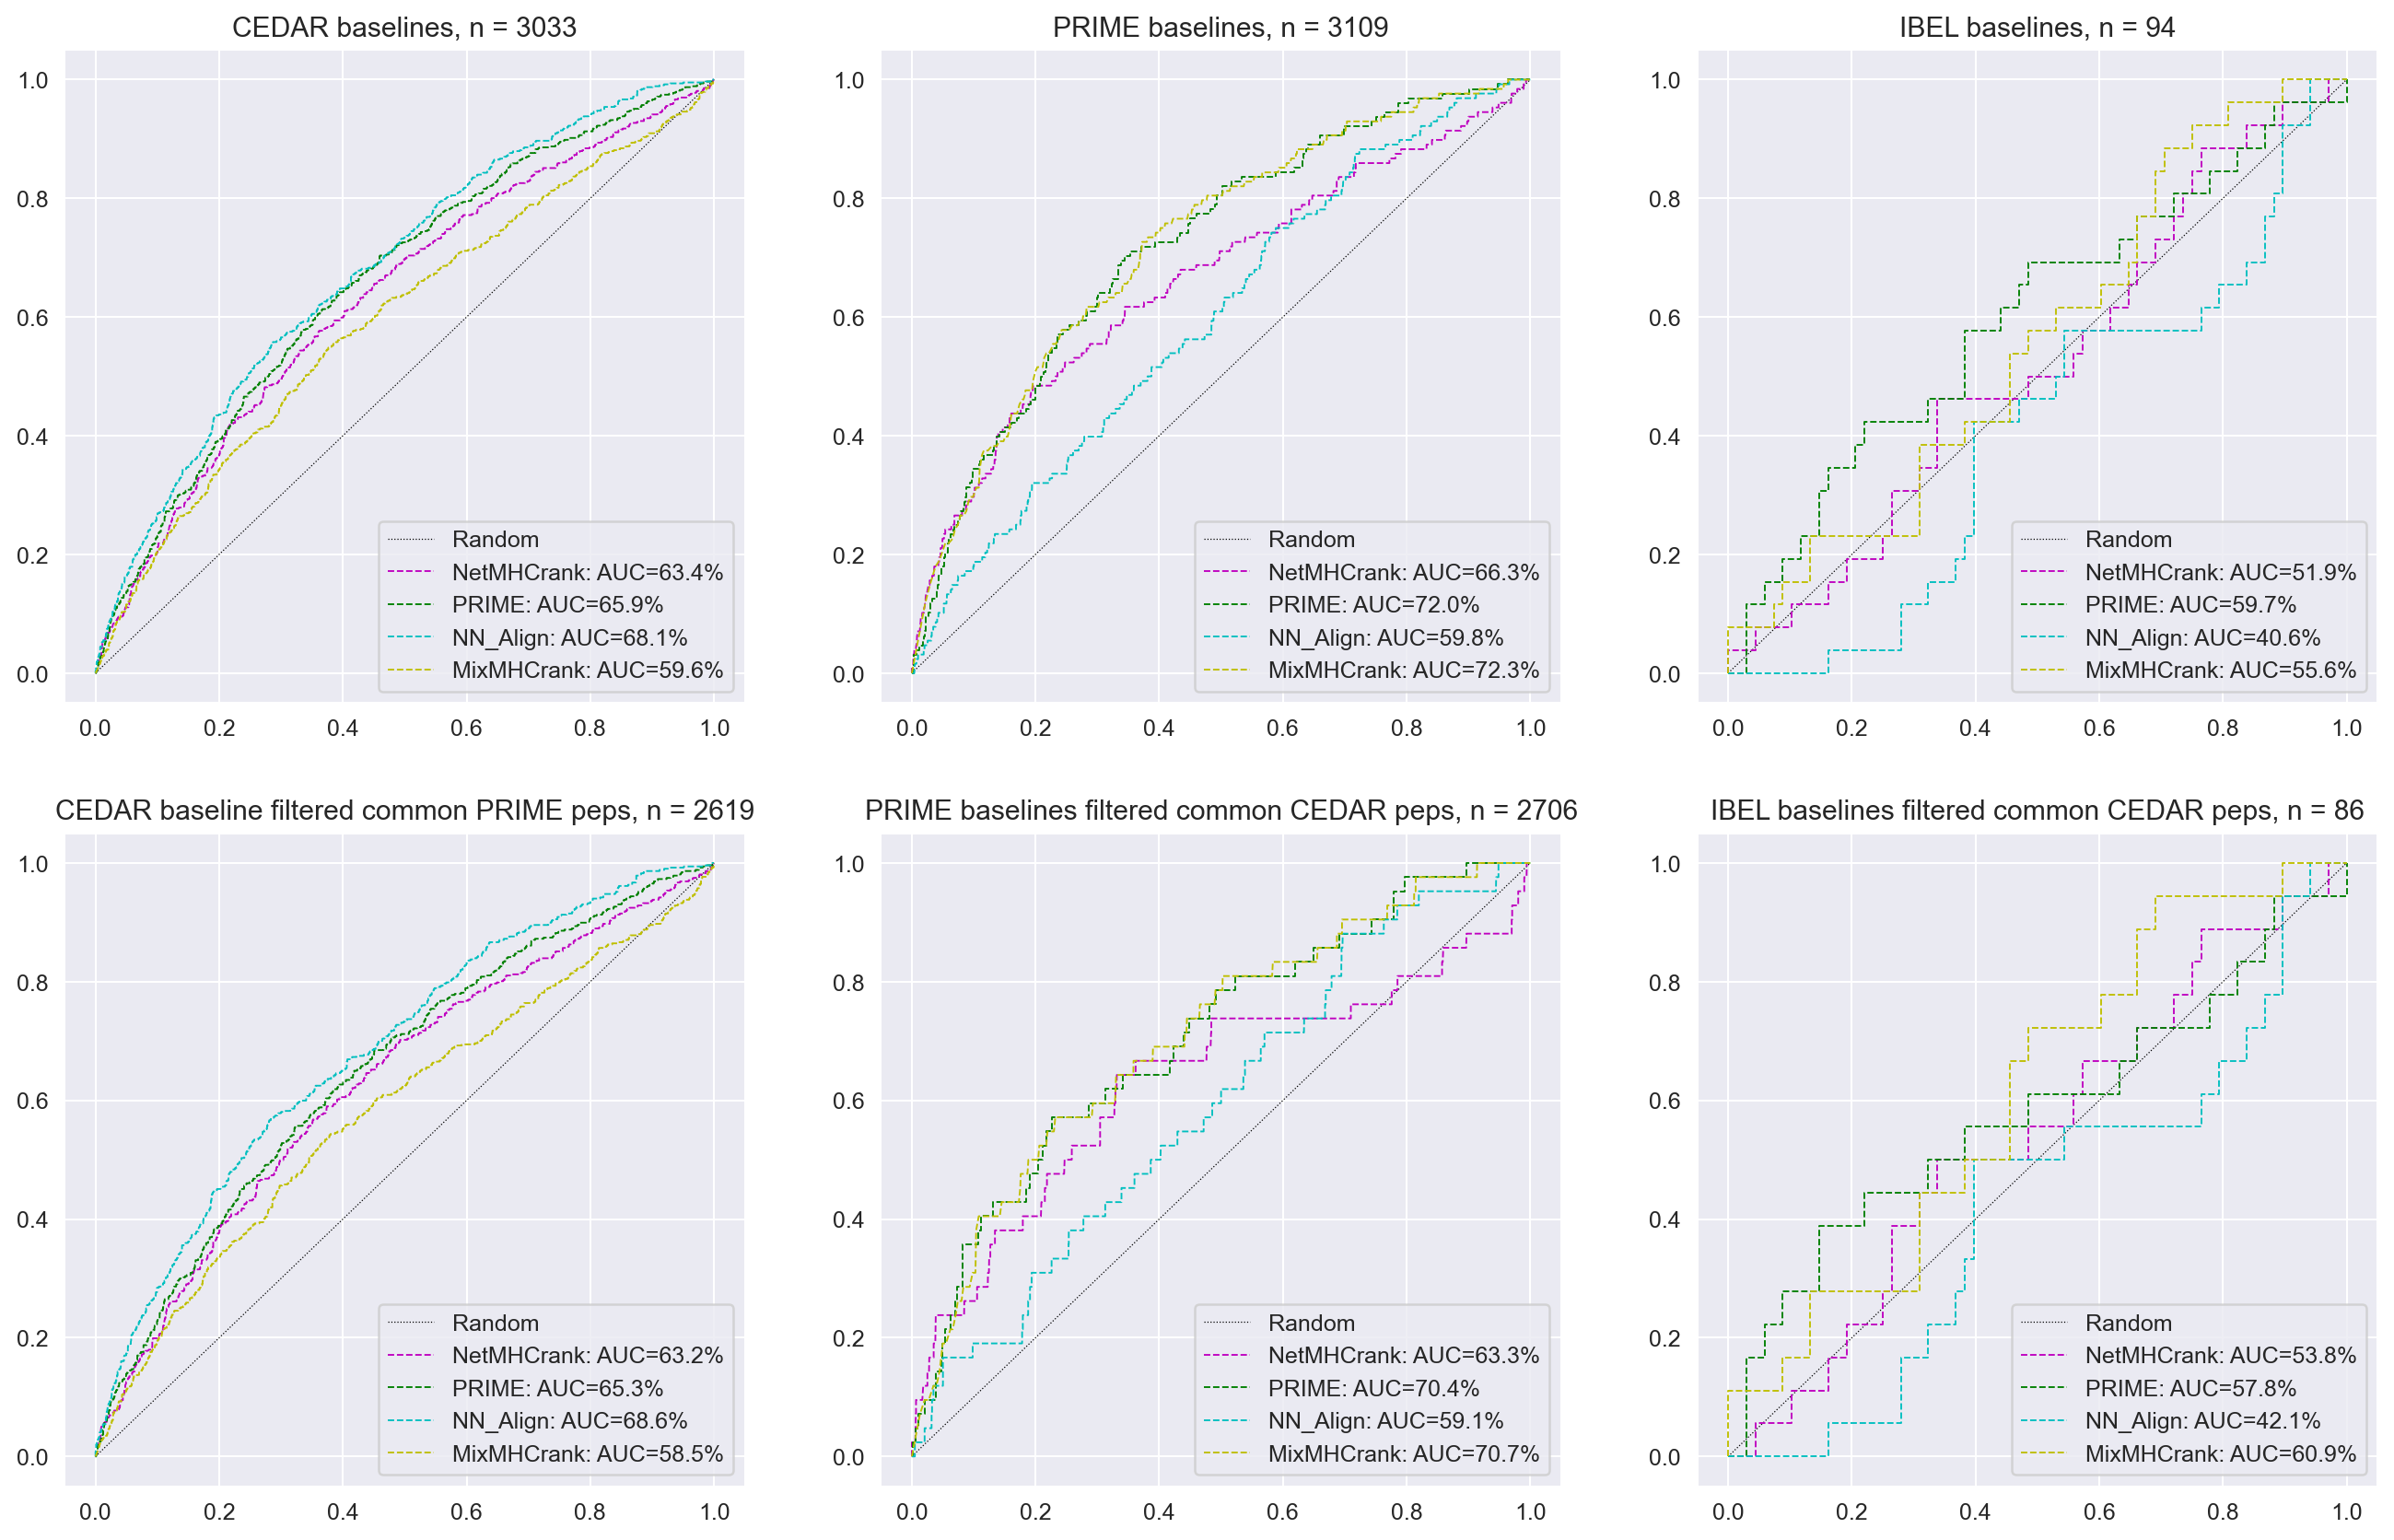

In [13]:
f,a = plt.subplots(2,3, figsize=(18,11.25))
a = a.ravel()
plot_related_baseline_roc(a[0], dataset=cedar_related_baseline)
plot_related_baseline_roc(a[1], dataset=prime_related_baseline)
plot_related_baseline_roc(a[2], dataset=ibel)

plot_related_baseline_roc(a[3], dataset=cedar_related_baseline.query('Peptide not in @ppeps'))
plot_related_baseline_roc(a[4], dataset=prime_related_baseline.query('Peptide not in @cpeps'))
plot_related_baseline_roc(a[5], dataset=ibel.query('Peptide not in @cpeps and Peptide not in @ppeps'))

a[0].set_title(f'CEDAR baselines, n = {len(cedar_related_baseline)}')
a[1].set_title(f'PRIME baselines, n = {len(prime_related_baseline)}')
a[2].set_title(f'IBEL baselines, n = {len(ibel)}')
a[3].set_title(f'CEDAR baseline filtered common PRIME peps, n = {len(cedar_related_baseline.query("Peptide not in @ppeps"))}')
a[4].set_title(f'PRIME baselines filtered common CEDAR peps, n = {len(prime_related_baseline.query("Peptide not in @cpeps"))}')
a[5].set_title(f'IBEL baselines filtered common CEDAR peps, n = {len(ibel.query("Peptide not in @cpeps and Peptide not in @ppeps"))}')

a[0].legend(loc = 'lower right')
a[1].legend(loc = 'lower right')
a[2].legend(loc = 'lower right')
a[3].legend(loc = 'lower right')
a[4].legend(loc = 'lower right')
a[5].legend(loc = 'lower right')

In [14]:
tmp = ibel.query('Peptide not in @cpeps and Peptide not in @ppeps')
roc_auc_score(tmp['agg_label'], tmp['PRIME_score'])

0.5784313725490196

In [15]:
cols = ['HLA', 'agg_label', 'Peptide', 'wild_type', 'Peptide_mut', 'Peptide_wt', 'icore_mut', 'icore_wt', 'core_wt', 'core_mut', 'EL_rank_mut', 'EL_rank_wt']

# Part 0 : Redo with additional features (Wt rank, ratio rank, foreignness score, NetMHCpanExp)

## redo save/reget features (foreignness, ratio ranks, etc)

In [13]:
# Saving for AntigenGarnish foreigness score
cedar_aligned.to_csv('../../benchmark/data/cedar_aligned_icore_antigenGarnish.txt', columns=['Peptide'], index=False, header=False)
prime_aligned.to_csv('../../benchmark/data/prime_aligned_icore_antigenGarnish.txt', columns=['Peptide'], index=False, header=False)
nepdb_aligned.to_csv('../../benchmark/data/nepdb_aligned_icore_antigenGarnish.txt', columns=['Peptide'], index=False, header=False)
ibel_aligned.to_csv('../../benchmark/data/ibel_aligned_icore_antigenGarnish.txt', columns=['Peptide'], index=False, header=False)

In [39]:
# Loading and merging foreignness score
cedar_test = pd.read_csv('../../benchmark/cedar_aligned_icore_antigenGarnish.txtforeignscore.csv')
prime_test = pd.read_csv('../../benchmark/prime_aligned_icore_antigenGarnish.txtforeignscore.csv')
nepdb_test = pd.read_csv('../../benchmark/nepdb_aligned_icore_antigenGarnish.txtforeignscore.csv')
ibel_test = pd.read_csv('../../benchmark/ibel_aligned_icore_antigenGarnish.txtforeignscore.csv')
cedar_aligned = cedar_aligned.merge(cedar_test[['V1', 'V2']].rename(columns={'V2':'foreignness_score'}), left_on=['Peptide'], right_on=['V1'], how='outer').drop(columns=['V1']).fillna(0)
prime_aligned = prime_aligned.merge(prime_test[['V1', 'V2']].rename(columns={'V2':'foreignness_score'}), left_on=['Peptide'], right_on=['V1'], how='outer').drop(columns=['V1']).fillna(0)
nepdb_aligned = nepdb_aligned.merge(nepdb_test[['V1', 'V2']].rename(columns={'V2':'foreignness_score'}), left_on=['Peptide'], right_on=['V1'], how='outer').drop(columns=['V1']).fillna(0)
ibel_aligned = ibel_aligned.merge(ibel_test[['V1', 'V2']].rename(columns={'V2':'foreignness_score'}), left_on=['Peptide'], right_on=['V1'], how='outer').drop(columns=['V1']).fillna(0)

In [43]:
cedar_aligned['ratio_rank'] = cedar_aligned['EL_rank_mut'] / cedar_aligned['EL_rank_wt_aligned']
prime_aligned['ratio_rank'] = prime_aligned['EL_rank_mut'] / prime_aligned['EL_rank_wt_aligned']
nepdb_aligned['ratio_rank'] = nepdb_aligned['EL_rank_mut'] / nepdb_aligned['EL_rank_wt_aligned']
ibel_aligned['ratio_rank'] = ibel_aligned['EL_rank_mut'] / ibel_aligned['EL_rank_wt_aligned']

In [44]:
cedar_aligned.to_csv('../data/aligned_icore/230308_cedar_aligned_icore.csv')
prime_aligned.to_csv('../data/aligned_icore/230308_prime_aligned_icore.csv')
nepdb_aligned.to_csv('../data/aligned_icore/233085_ibel_aligned_icore.csv')
ibel_aligned.to_csv('../data/aligned_icore/230308_nepdb_aligned_icore.csv')

In [77]:
cedar_aligned_expr = cedar_aligned_expr.merge(cedar_aligned[['Peptide', 'HLA', 'agg_label', 'foreignness_score', 'ratio_rank']], left_on=['Peptide','HLA','agg_label'], right_on=['Peptide','HLA','agg_label'], how='inner')
prime_aligned_expr = prime_aligned_expr.merge(prime_aligned[['Peptide', 'HLA', 'agg_label', 'foreignness_score', 'ratio_rank']], left_on=['Peptide','HLA','agg_label'], right_on=['Peptide','HLA','agg_label'], how='inner')
nepdb_aligned_expr = nepdb_aligned_expr.merge(nepdb_aligned[['Peptide', 'HLA', 'agg_label', 'foreignness_score', 'ratio_rank']], left_on=['Peptide','HLA','agg_label'], right_on=['Peptide','HLA','agg_label'], how='inner')
ibel_aligned_expr = ibel_aligned_expr.merge(ibel_aligned[['Peptide', 'HLA', 'agg_label', 'foreignness_score', 'ratio_rank']], left_on=['Peptide','HLA','agg_label'], right_on=['Peptide','HLA','agg_label'], how='inner')


In [82]:
cedar_aligned_expr.columns = cedar_aligned_expr.columns.str.replace(' ','_')
prime_aligned_expr.columns = prime_aligned_expr.columns.str.replace(' ','_')
nepdb_aligned_expr.columns = nepdb_aligned_expr.columns.str.replace(' ','_')
ibel_aligned_expr.columns = ibel_aligned_expr.columns.str.replace(' ','_')

In [85]:
cedar_aligned_expr.to_csv('../data/pepx/230308_cedar_aligned_pepx_fold.csv')
prime_aligned_expr.to_csv('../data/pepx/230308_prime_aligned_pepx.csv')
nepdb_aligned_expr.to_csv('../data/pepx/230308_ibel_aligned_pepx.csv')
ibel_aligned_expr.to_csv('../data/pepx/230308_nepdb_aligned_pepx.csv')

## load netmhcpanexp

In [130]:
from src.utils import read_netmhcpan_results, pipeline_netmhcpan_xls_fullpep

xd = nepdb_aligned_expr.query('Peptide not in @cedar_expr.Peptide.values').copy()
xd['HLA'] = xd['HLA'].apply(lambda x: x[:7]+':'+x[7:])
pipeline_netmhcpan_xls_fullpep(xd, '../../netmhcpan/score_exp/output/nepdb_expr_nolabel.txt.xls', '_exp', exp=True)
xd['HLA']=xd['HLA'].str.replace(':','')
nepdb_aligned_expr = nepdb_aligned_expr.merge(xd[['Peptide','agg_label', 'HLA', 'EL_rank_exp']], left_on = ['Peptide','HLA','agg_label'], right_on = ['Peptide','HLA','agg_label']).drop_duplicates()


xd = prime_aligned_expr.copy()
xd['HLA'] = xd['HLA'].apply(lambda x: x[:7]+':'+x[7:])
pipeline_netmhcpan_xls_fullpep(xd, '../../netmhcpan/score_exp/output/prime_expr_nolabel.txt.xls', '_exp', exp=False)
xd['HLA']=xd['HLA'].str.replace(':','')
prime_aligned_expr = prime_aligned_expr.merge(xd[['Peptide','agg_label', 'HLA', 'EL_rank_exp']], left_on = ['Peptide','HLA','agg_label'], right_on = ['Peptide','HLA','agg_label']).drop_duplicates()


xd = cedar_aligned_expr.copy()
xd['HLA'] = xd['HLA'].apply(lambda x: x[:7]+':'+x[7:])
pipeline_netmhcpan_xls_fullpep(xd, '../../netmhcpan/score_exp/output/cedar_expr_nolabel.txt.xls', '_exp', exp=False)
xd['HLA']=xd['HLA'].str.replace(':','')
cedar_aligned_expr = cedar_aligned_expr.merge(xd[['Peptide','agg_label', 'HLA', 'EL_rank_exp']], left_on = ['Peptide','HLA','agg_label'], right_on = ['Peptide','HLA','agg_label']).drop_duplicates()

## scores

In [139]:
from sklearn.metrics import roc_auc_score
print('AUCs based on score')
for df, ds in zip([cedar_aligned_expr, prime_aligned_expr, nepdb_aligned_expr, ibel_aligned],['CEDAR','PRIME','NEPDB','IBEL']):
    print('\n',ds)
    for score in ['foreignness_score', 'ratio_rank', 'EL_rank_wt_aligned', 'EL_rank_exp']:
        if score not in df.columns:continue
        sep=2*"\t" if len(score)<12 else "\t" 
        sc = -1*df[score].values if "EL_rank" in score else df[score].values
        print(f"{score}:{sep}{roc_auc_score(df['agg_label'].values, sc):.2%}")

AUCs based on score

 CEDAR
foreignness_score:	52.48%
ratio_rank:		45.95%
EL_rank_wt_aligned:	57.75%
EL_rank_exp:		60.46%

 PRIME
foreignness_score:	50.17%
ratio_rank:		43.18%
EL_rank_wt_aligned:	59.51%
EL_rank_exp:		67.08%

 NEPDB
foreignness_score:	51.28%
ratio_rank:		46.68%
EL_rank_wt_aligned:	69.52%
EL_rank_exp:		72.15%

 IBEL
foreignness_score:	50.54%
ratio_rank:		49.94%
EL_rank_wt_aligned:	49.66%


# Part 1 

Raw dataset stats (pos-neg ratios, hla ratios, anc-non anc, baseline with fullpep vs icore ranks)

may remake some stats plots here just so everything is in the same notebook

## axelf

In [18]:
cedar_expr['xd'] = cedar_expr['HLA'].apply(lambda x: x[:5]+'*'+x[5:7]+':'+x[7:])

In [19]:
cedar_expr[['xd', 'Peptide', 'Total Peptide TPM']]\
          .rename(columns = {'xd':'allele',
                             'Peptide':'peptide',
                             'Total Peptide TPM':'tpm'})\
          .to_csv('../../cedar_expr_axelf_sample.csv', index=False)

## Raw stats

In [20]:
len(cedar_related.Peptide.unique()), len(cedar_related.groupby(['Peptide', 'HLA']).count().index.unique())

(2926, 3033)

In [21]:
3033-2988

45

In [22]:
len(cedar_expr)

2988

In [23]:
len(cedar_expr.Peptide.unique())

2882

In [24]:
cedar_aligned['icore_wt'] = cedar_related.icore_wt
cedar_aligned[['Peptide_mut', 'Peptide_wt', 'core_wt']] = cedar_related[['Peptide_mut', 'Peptide_wt', 'core_wt']]

In [25]:
cedar_aligned.query('icore_wt != icore_wt_aligned')[['Peptide', 'wild_type', 'icore_mut', 'icore_wt', 'icore_wt_aligned']]

Peptide    wild_type  icore_mut     icore_wt icore_wt_aligned
8       AAPAHSHAV    AAPAHSHAG  AAPAHSHAV     AAPAHSHA        AAPAHSHAG
31      AILLGAEEK    AKLLGAEEK  AILLGAEEK     KLLGAEEK        AKLLGAEEK
33     AILPFTPEFL   AISPFTPEFL  ILPFTPEFL   AISPFTPEFL        ISPFTPEFL
34    AILPFTPEFLV  AISPFTPEFLV  ILPFTPEFL  AISPFTPEFLV        ISPFTPEFL
38     AIVVILMSMV   AIVVLLMSMV  AIVVILMSM    IVVLLMSMV        AIVVLLMSM
...           ...          ...        ...          ...              ...
2984   YSWSAQRQAL   YSWSAQRRAL  YSWSAQRQA     WSAQRRAL        YSWSAQRRA
2986    YTAPGIVEI    DTAPGIVEI  YTAPGIVEI     TAPGIVEI        DTAPGIVEI
2998    YTLSQCFQL    CTLSQCFQL  YTLSQCFQL     TLSQCFQL        CTLSQCFQL
3013  YVMASVFVCPL  YVMASVFVCLL   YVMASVFV    VMASVFVCL         YVMASVFV
3031   YYSKNLNSFF   YYSKNLNSSF  YYSKNLNSF   YYSKNLNSSF        YYSKNLNSS

[447 rows x 5 columns]

In [26]:
cedar_aligned.query('icore_mut != Peptide and icore_mut==icore_wt_aligned')[['Peptide', 'wild_type', 'icore_mut', 'icore_wt', 'icore_wt_aligned']]

Peptide    wild_type   icore_mut    icore_wt icore_wt_aligned
22    AEWRNGSTSSL  PEWRNGSTSSL  EWRNGSTSSL  EWRNGSTSSL       EWRNGSTSSL
23    AFLSTHLKLFL  AFLSTHLKLFP  AFLSTHLKLF  AFLSTHLKLF       AFLSTHLKLF
25    AFQTSEKKFYI  AFQTSEKKFHI   AFQTSEKKF   AFQTSEKKF        AFQTSEKKF
39    AIYHTLNLFNI  AIYHTLNLCNI    AIYHTLNL   AIYHTLNLC         AIYHTLNL
117   ALWSLSRHASL  ALWSLSRHAAL   ALWSLSRHA   ALWSLSRHA        ALWSLSRHA
...           ...          ...         ...         ...              ...
2958  YQDKWAEKPAF  HQDKWAEKPAF   DKWAEKPAF   DKWAEKPAF        DKWAEKPAF
2996  YTILRALEFHL  DTILRALEFHL   ILRALEFHL   ILRALEFHL        ILRALEFHL
3013  YVMASVFVCPL  YVMASVFVCLL    YVMASVFV   VMASVFVCL         YVMASVFV
3017  YVRVTVQARVM  CVRVTVQARVM   RVTVQARVM   RVTVQARVM        RVTVQARVM
3023  YVYSVAKTDSF  HVYSVAKTDSF   YSVAKTDSF   YSVAKTDSF        YSVAKTDSF

[116 rows x 5 columns]

In [27]:
len(cedar_expr)

2988

In [28]:
2926-2882, 3033-2926

(44, 107)

In [29]:
_, aa_cols = get_aa_properties(cedar_aligned.sample(1))

In [30]:
aa_cols

['aliphatic_index',
 'boman',
 'hydrophobicity',
 'isoelectric_point',
 'VHSE1',
 'VHSE3',
 'VHSE7',
 'VHSE8']

In [31]:
list(filter(lambda x: 'TPM' in x.upper(), cedar_expr.columns))

['Total Gene TPM', 'Total Peptide TPM', 'Total Scaled Peptide TPM']

In [32]:
len(prime_aligned), len(prime_expr)

(3109, 2992)

In [33]:
display(prime_aligned.query('Peptide not in @cedar_aligned.Peptide.values').groupby('agg_label').count())
display(prime_expr.query('Peptide not in @cedar_aligned.Peptide.values').groupby('agg_label').count())

HLA  fold  Peptide  wild_type  icore_mut  core_mut   len  \
agg_label                                                              
0          2664  2664     2664       2664       2664      2664  2664   
1            42    42       42         42         42        42    42   

           EL_rank_mut  EL_rank_wt  trueHLA_EL_rank  ...  boman  \
agg_label                                            ...          
0                 2664        2664             2664  ...   2664   
1                   42          42               42  ...     42   

           hydrophobicity  isoelectric_point  VHSE1  VHSE3  VHSE7  VHSE8  \
agg_label                                                                  
0                    2664               2664   2664   2664   2664   2664   
1                      42                 42     42     42     42     42   

           seq_id  core_wt_aligned  EL_rank_wt_aligned  
agg_label                                               
0            2664             2664                2664  
1              42               42                  42  

[2 rows x 32 columns]

Peptide   HLA  EL_rank_mut  fold  EL_rank_wt  HLA_full  \
agg_label                                                           
0             2550  2550         2550  2550        2550      2550   
1               41    41           41    41          41        41   

           MixMHCallele  MixMHCrank  PRIME_score  Peptide_mut  ...  \
agg_label                                                      ...   
0                  2550        2550         2550         2550  ...   
1                    41          41           41           41  ...   

           nnalign_score  ratio_rank  seq_id  trueHLA_EL_rank  wild_type  \
agg_label                                                                  
0                   2550        2550    2550             2550       2550   
1                     41          41      41               41         41   

           wt_EL_rank  wt_core  Total Peptide TPM  Total Scaled Peptide TPM  \
agg_label                                                                     
0                2550     2550               2550                      2550   
1                  41       41                 41                        41   

           Total Gene TPM  
agg_label                  
0                    2550  
1                      41  

[2 rows x 50 columns]

In [34]:
cedar_aligned.groupby('len_icore_mut').count()

HLA  agg_label  fold  Peptide  wild_type  icore_mut  core_mut  \
len_icore_mut                                                                   
8               125        125   125      125        125        125       125   
9              2146       2146  2146     2146       2146       2146      2146   
10              525        525   525      525        525        525       525   
11              236        236   236      236        236        236       236   
12                1          1     1        1          1          1         1   

                len  EL_rank_mut  EL_rank_wt  ...  VHSE3  VHSE7  VHSE8  \
len_icore_mut                                 ...                        
8               125          125         125  ...    125    125    125   
9              2146         2146        2146  ...   2146   2146   2146   
10              525          525         525  ...    525    525    525   
11              236          236         236  ...    236    236    236   
12                1            1           1  ...      1      1      1   

               seq_id  core_wt_aligned  EL_rank_wt_aligned  icore_wt  \
len_icore_mut                                                          
8                 125              125                 125       125   
9                2146             2146                2146      2146   
10                525              525                 525       525   
11                236              236                 236       236   
12                  1                1                   1         1   

               Peptide_mut  Peptide_wt  core_wt  
len_icore_mut                                    
8                      125         125      125  
9                     2146        2146     2146  
10                     525         525      525  
11                     236         236      236  
12                       1           1        1  

[5 rows x 36 columns]

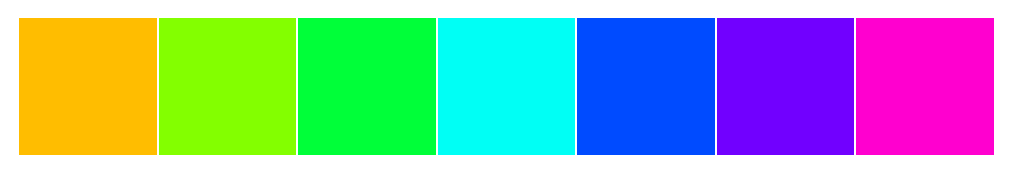

In [921]:
sns.palplot(sns.color_palette('hsv', n_colors=7))

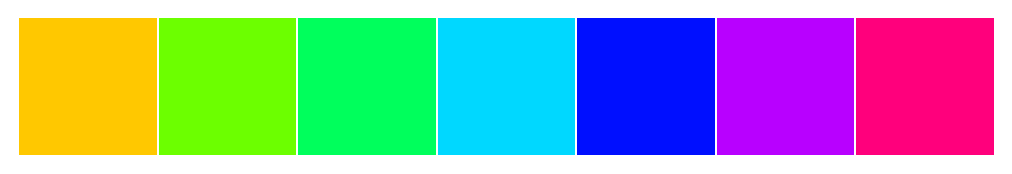

In [922]:
sns.palplot(get_palette('hsv', n_colors=7))

In [35]:
tmp = cedar_related.groupby('HLA').agg(count=('Peptide','count')).sort_values('count',ascending=False).head(20)
tmp['cumsum']= tmp[['count']].cumsum(axis=0)
tmp['perc_tot'] = 100*(tmp['count']/len(cedar_related))
tmp['sum_tot'] = 100*(tmp['cumsum']/len(cedar_related))
tmp['n_hla'] = range(1,len(tmp)+1)
tmp

count  cumsum   perc_tot    sum_tot  n_hla
HLA                                                  
HLA-A0201   1168    1168  38.509726  38.509726      1
HLA-B0702    307    1475  10.121991  48.631718      2
HLA-A2402    294    1769   9.693373  58.325091      3
HLA-A1101    252    2021   8.308605  66.633696      4
HLA-A0301    159    2180   5.242334  71.876030      5
HLA-B1501    149    2329   4.912628  76.788658      6
HLA-B3501    109    2438   3.593802  80.382460      7
HLA-B2705     53    2491   1.747445  82.129904      8
HLA-B0801     39    2530   1.285856  83.415760      9
HLA-A0101     38    2568   1.252885  84.668645     10
HLA-A3001     32    2600   1.055061  85.723706     11
HLA-C1203     27    2627   0.890208  86.613914     12
HLA-A0206     24    2651   0.791296  87.405209     13
HLA-B1801     23    2674   0.758325  88.163534     14
HLA-B3801     19    2693   0.626442  88.789977     15
HLA-A6801     17    2710   0.560501  89.350478     16
HLA-B4403     17    2727   0.560501  89.910979     17
HLA-A6802     17    2744   0.560501  90.471480     18
HLA-A3101     17    2761   0.560501  91.031982     19
HLA-B4001     17    2778   0.560501  91.592483     20

## Pos-neg distributions

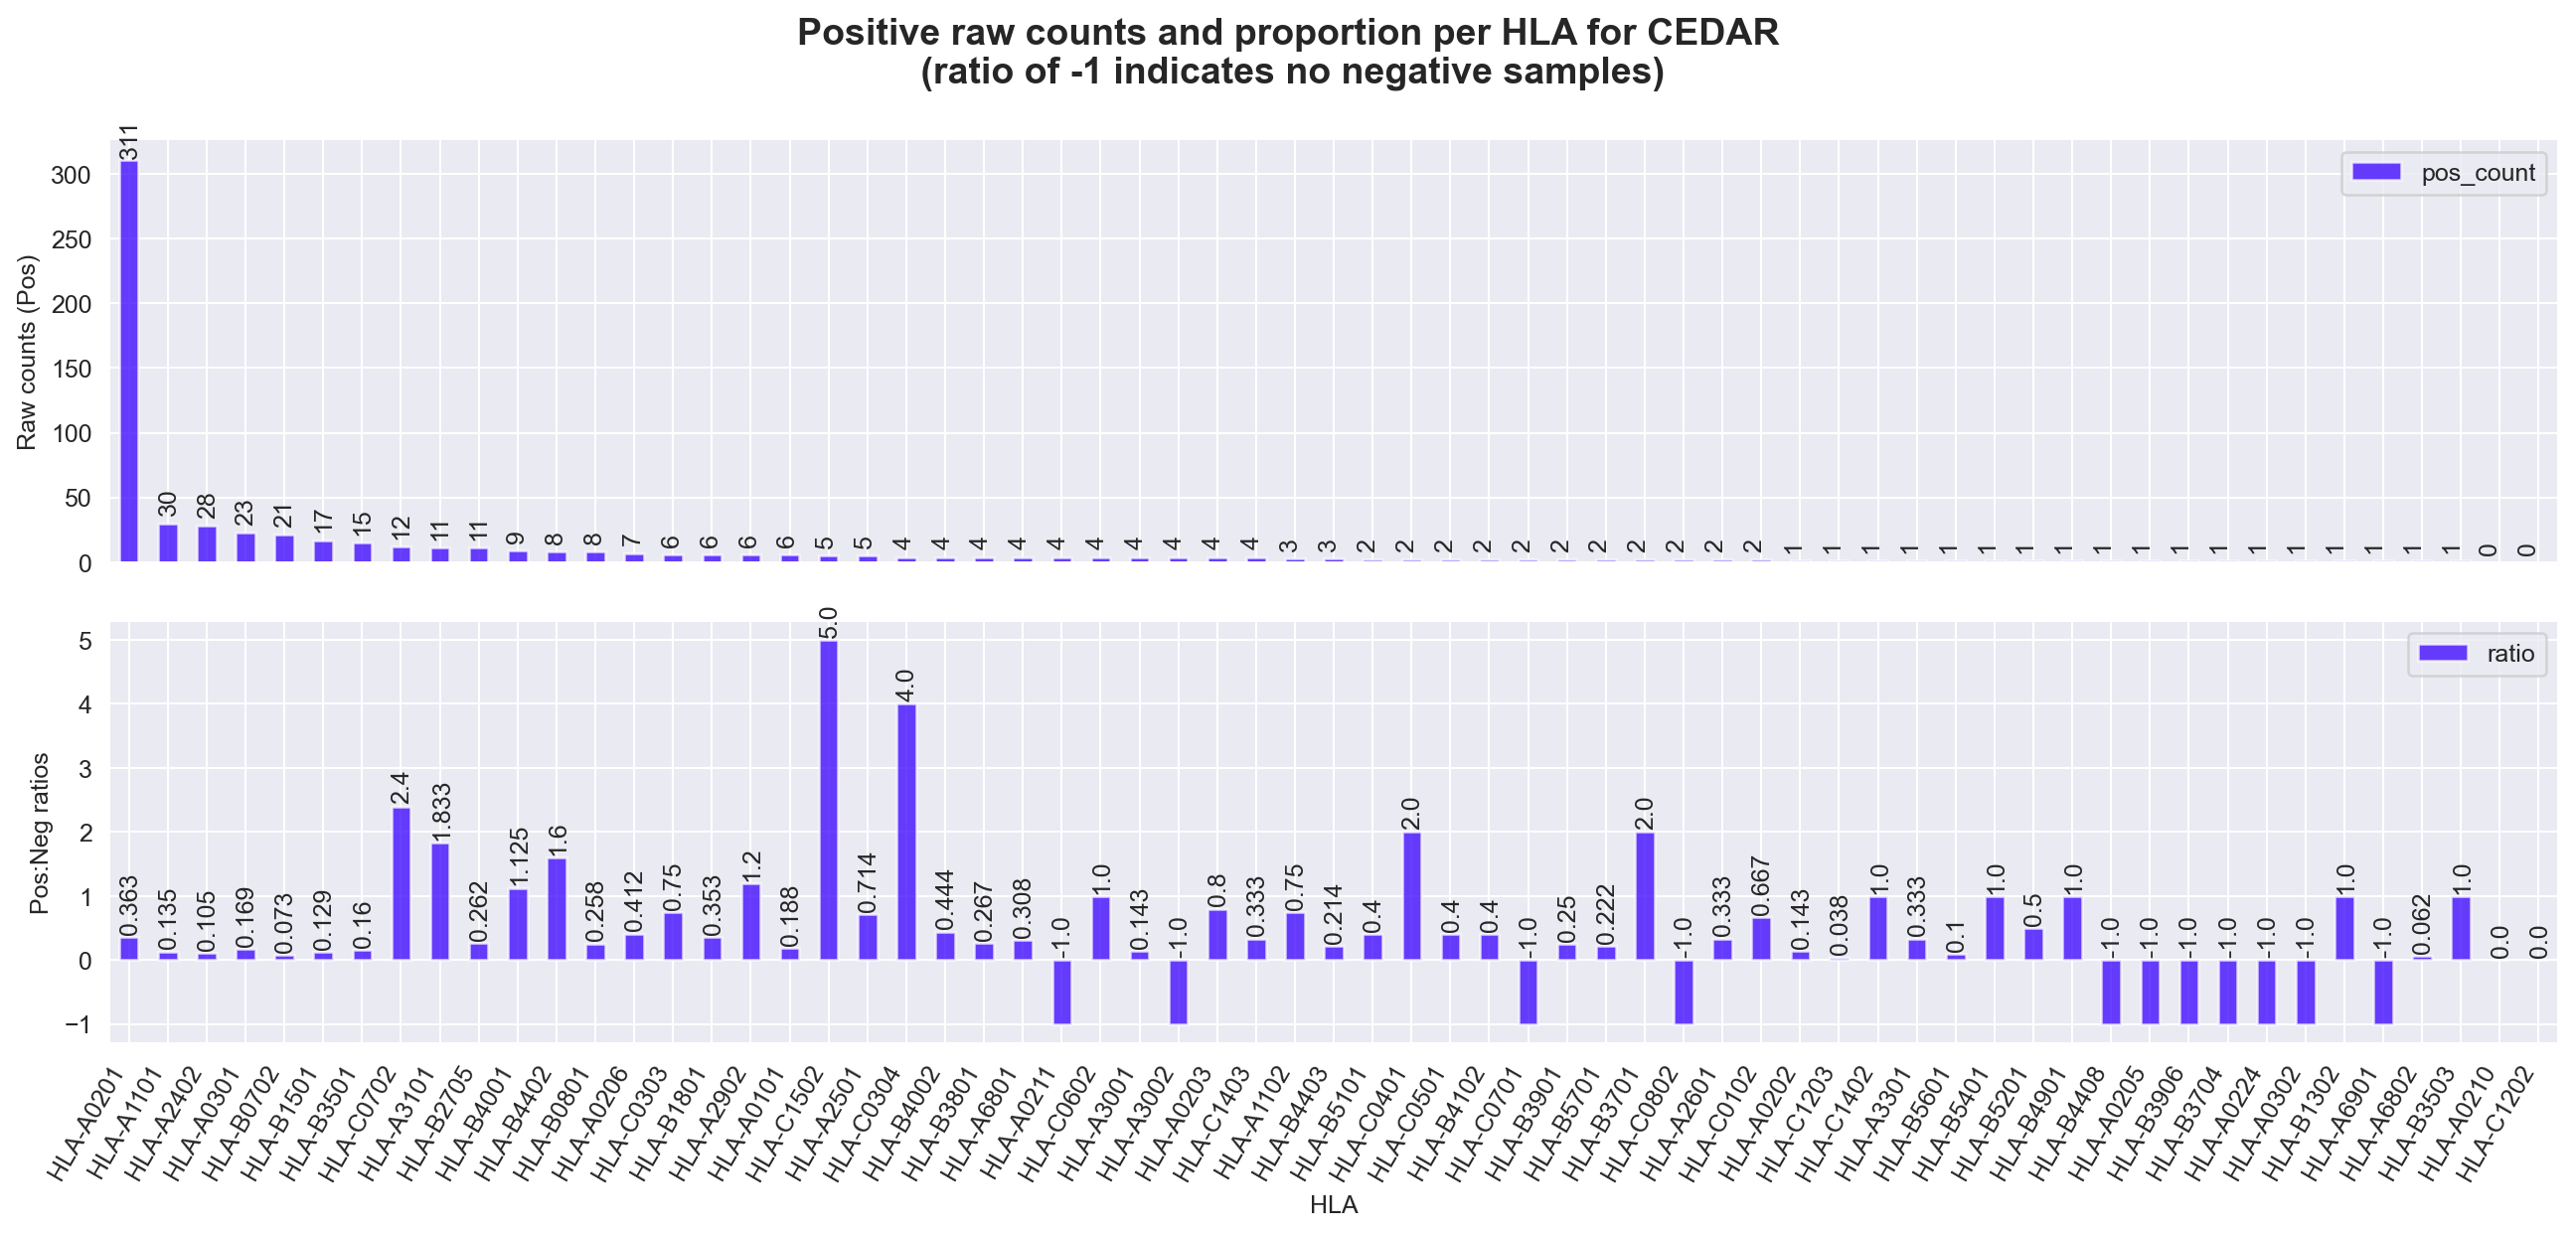

In [916]:
sns.set_palette(HSV)
cedar_pos_counts = cedar_related.query('agg_label==1').groupby(['HLA']).agg(pos_count=('Peptide','count')).sort_values('pos_count', ascending=False)
cedar_neg_counts = cedar_related.query('agg_label==0').groupby(['HLA']).agg(neg_count=('Peptide','count')).sort_values('neg_count', ascending=False)
cedar_counts = pd.concat([cedar_pos_counts, cedar_neg_counts], axis = 1)
cedar_counts['pos_count'].fillna(0)
cedar_counts['neg_count'].fillna(-1)
cedar_counts['ratio'] = cedar_counts.apply(lambda x : x.pos_count/x.neg_count if x.neg_count>0 else -1, axis=1)

f,a = plt.subplots(2,1, figsize=(14.5,7), sharex=True)
cedar_counts.plot(y='pos_count', ax=a[0], kind='bar', alpha = 0.75)
cedar_counts.plot(y='ratio', ax=a[1], kind='bar', alpha = 0.75)

for p in a[0].patches:
    y =  p.get_height()*1.015 if p.get_height()>100 else int(p.get_height()+10)
    a[0].annotate(str(int(p.get_height())), (p.get_x()*0.995, y), rotation=90)

for p in a[1].patches:
    y =  p.get_height()+0.125 if p.get_height()*-1.0 < 0 else 0.125
    a[1].annotate(str(round(p.get_height(), 3)), (p.get_x(), y), rotation=90)
    
    
a[1].set_xticklabels(a[1].get_xticklabels(), rotation=60, horizontalalignment='right');
f.suptitle('Positive raw counts and proportion per HLA for CEDAR\n (ratio of -1 indicates no negative samples)', fontweight='semibold', fontsize=15)
a[0].set_ylabel('Raw counts (Pos)')
a[1].set_ylabel('Pos:Neg ratios')
f.tight_layout()
# f.savefig('../output/hla_analysis/HLA_count-ratio_dist_CEDAR.png', dpi=200, bbox_inches = 'tight')

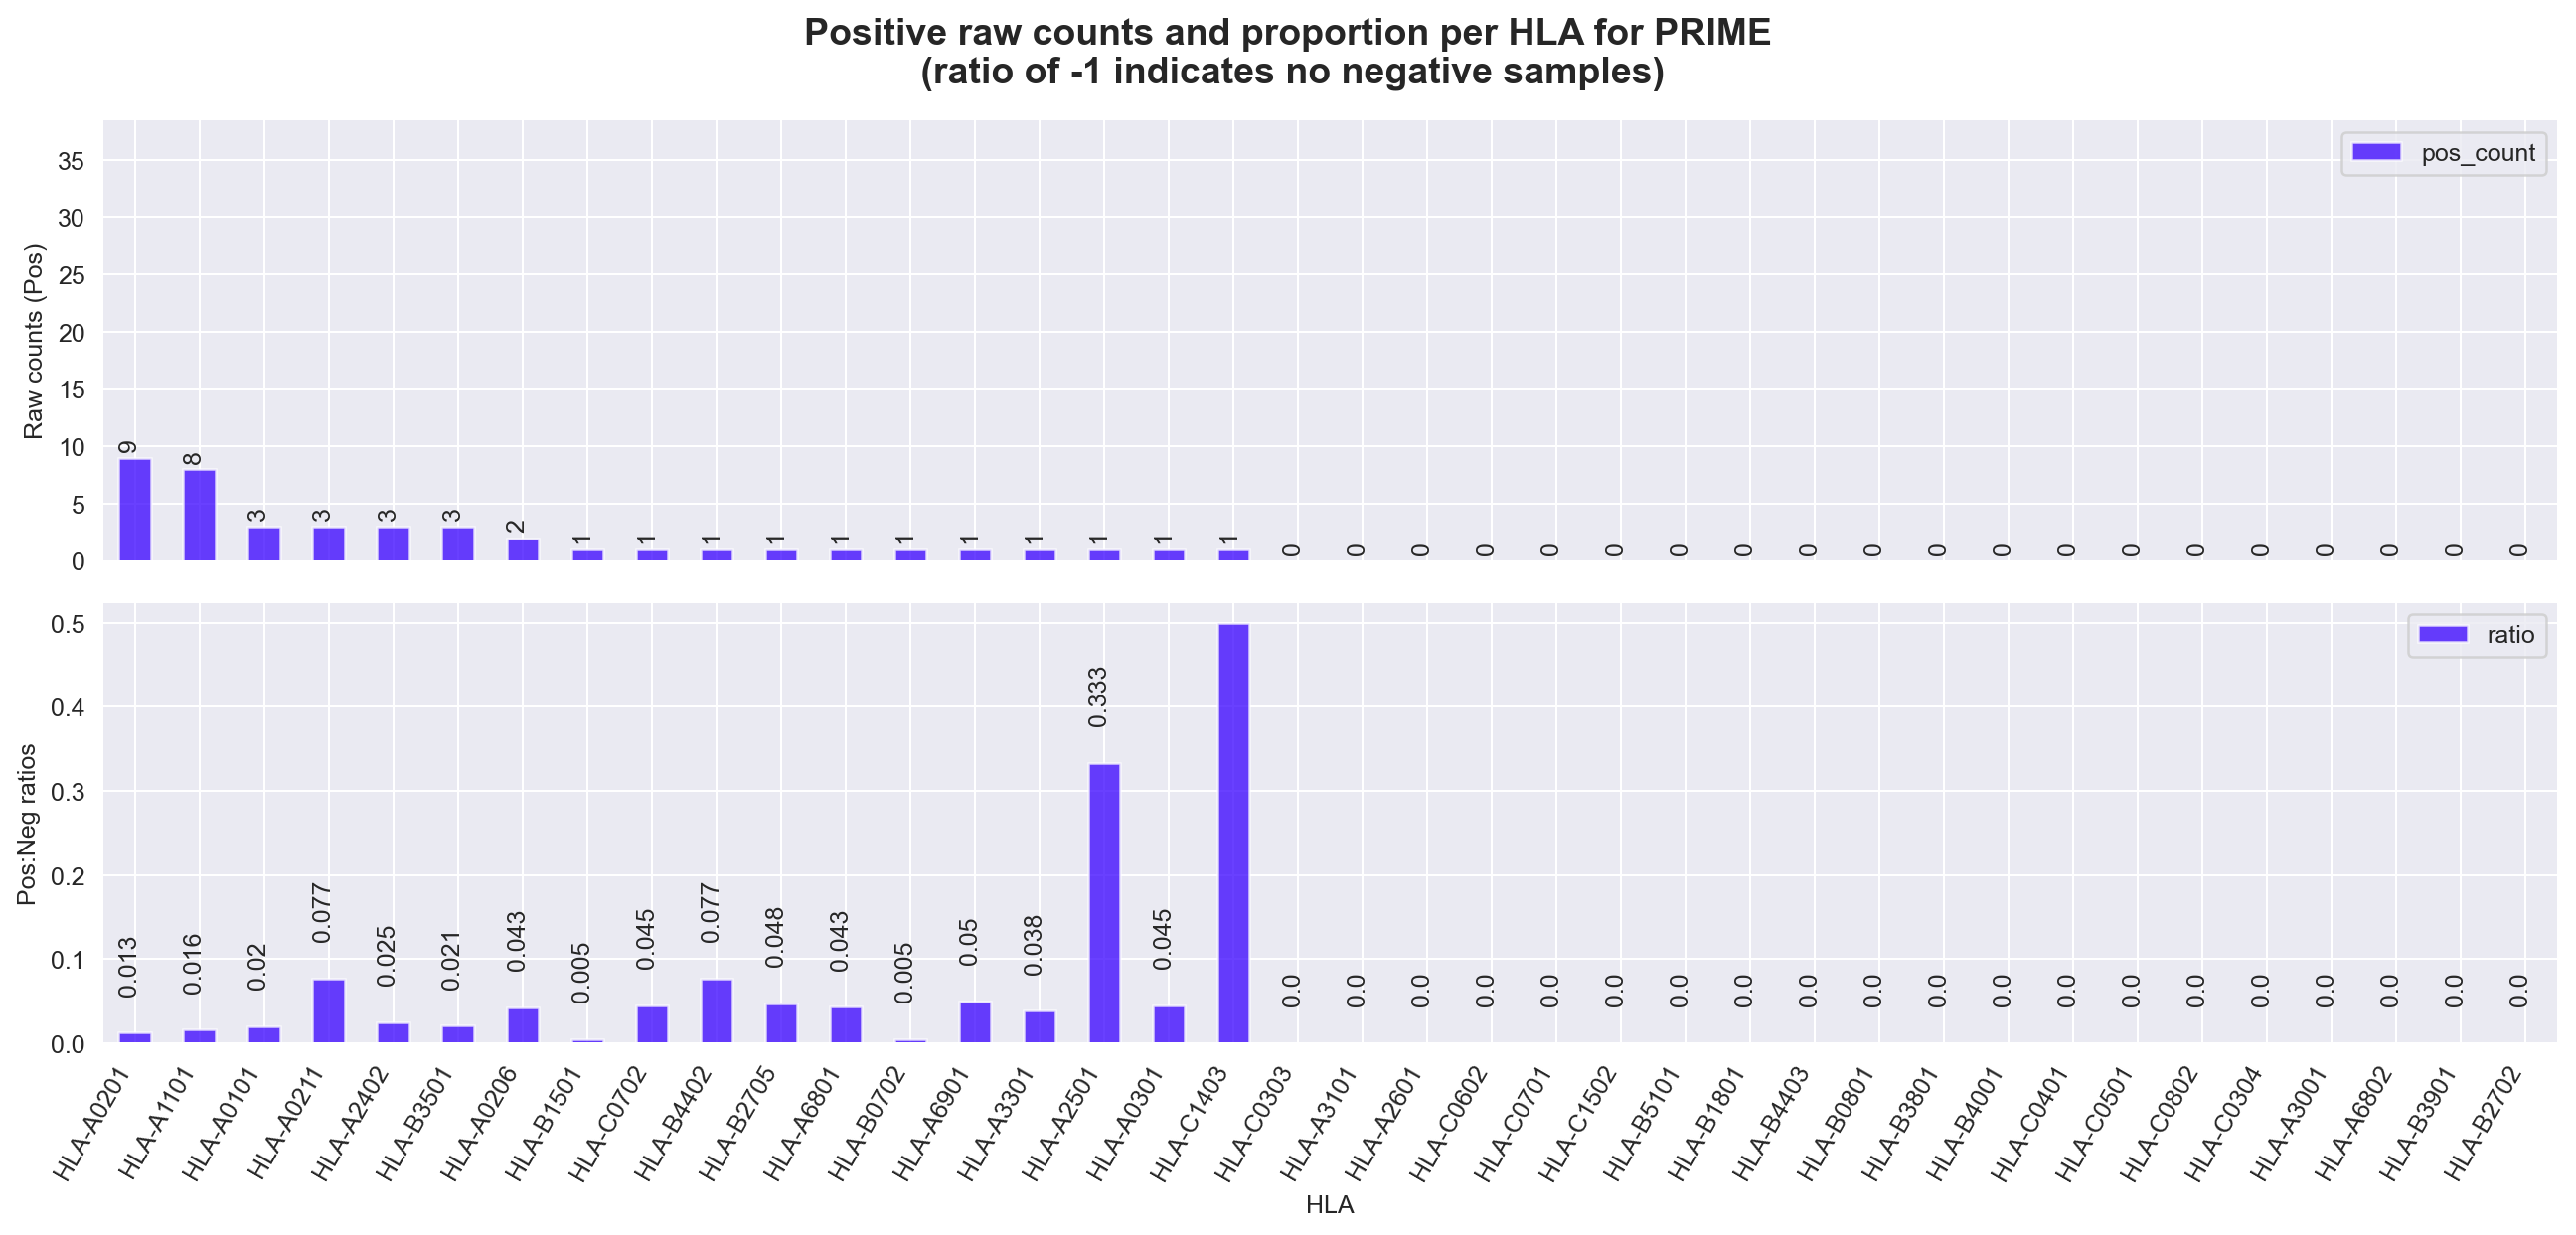

In [37]:
prime_pos_counts = prime_related.query('Peptide not in @cedar_related.Peptide.values').query('agg_label==1').groupby(['HLA']).agg(pos_count=('Peptide','count')).sort_values('pos_count', ascending=False)
prime_neg_counts = prime_related.query('Peptide not in @cedar_related.Peptide.values').query('agg_label==0').groupby(['HLA']).agg(neg_count=('Peptide','count')).sort_values('neg_count', ascending=False)
prime_counts = pd.concat([prime_pos_counts, prime_neg_counts], axis = 1)
prime_counts['pos_count'].fillna(0)
prime_counts['neg_count'].fillna(-1)
prime_counts['ratio'] = prime_counts.apply(lambda x : x.pos_count/x.neg_count if x.neg_count>0 else -1, axis=1)

f,a = plt.subplots(2,1, figsize=(14.5,7), sharex=True)
prime_counts.plot(y='pos_count', ax=a[0], kind='bar', alpha = 0.75)
prime_counts.plot(y='ratio', ax=a[1], kind='bar', alpha = 0.75)
a[0].set_ylim([0,38.5])
for p in a[0].patches:
    y =  int(p.get_height()+1.25)
    a[0].annotate(str(int(p.get_height())), (p.get_x(), y), rotation=90)
    
    
for p in a[1].patches:
    y =  p.get_height()+0.05 if p.get_height()*-1.0 < 0 else 0.05
    a[1].annotate(str(round(p.get_height(), 3)), (p.get_x(), y), rotation=90)
    
a[1].set_xticklabels(a[1].get_xticklabels(), rotation=60, horizontalalignment='right');
f.suptitle('Positive raw counts and proportion per HLA for PRIME\n (ratio of -1 indicates no negative samples)', fontweight='semibold', fontsize=15)
a[0].set_ylabel('Raw counts (Pos)')
a[1].set_ylabel('Pos:Neg ratios')
f.tight_layout()

# f.savefig('../output/hla_analysis/HLA_count-ratio_dist_PRIME.png', dpi=200, bbox_inches = 'tight')

In [38]:
list(filter(lambda x: 'wt' in x.lower(), cedar_aligned.columns))

['EL_rank_wt',
 'icore_wt_aligned',
 'icore_len_wt',
 'core_wt_aligned',
 'EL_rank_wt_aligned',
 'icore_wt',
 'Peptide_wt',
 'core_wt']

In [39]:
cedar_aligned['ratio_rank'] = cedar_aligned['EL_rank_wt'] / cedar_aligned['EL_rank_mut']

In [40]:
cedar_aligned.groupby('agg_label')['ratio_rank'].describe()

count       mean         std       min       25%       50%  \
agg_label                                                                
0          2402.0  10.031402   64.445235  0.003667  0.833333  1.241554   
1           631.0  21.568384  108.708468  0.011832  0.919403  1.474816   

                75%          max  
agg_label                         
0          2.720752  1646.264151  
1          4.400290  1420.000000

In [41]:
prime_aligned['ratio_rank'] = prime_aligned['EL_rank_wt'] / prime_aligned['EL_rank_mut']

In [42]:
prime_aligned.groupby('agg_label')['ratio_rank'].describe()

count       mean        std       min       25%       50%  \
agg_label                                                               
0          2981.0   7.281378  33.430104  0.003667  0.808633  1.186763   
1           128.0  14.193256  36.668076  0.011832  0.938526  1.397293   

                75%         max  
agg_label                        
0          2.227630  702.264563  
1          4.676635  245.000000

In [43]:
round(100*cedar_aligned.groupby('len').agg(count=('Peptide','count'))/len(cedar_aligned),2)

count
len       
9    50.48
10   28.85
11   20.61
12    0.07

In [44]:
round(100*cedar_aligned.groupby('len_icore_mut').agg(count=('Peptide','count'))/len(cedar_aligned),2)

count
len_icore_mut       
8               4.12
9              70.76
10             17.31
11              7.78
12              0.03

In [45]:
# Messed something up ; Need to get the "trueHLA_EL_rank" for the aligned wt icores:
prime_aligned['icore_wt_aligned'].to_csv('../../netmhcpan/score_full/data/230202_prime_aligned_wt_icore.pep', index=False)
cedar_aligned['icore_wt_aligned'].to_csv('../../netmhcpan/score_full/data/230202_cedar_aligned_wt_icore.pep', index=False)


## ranks AUC

### non filtered (CEDAR+rest)

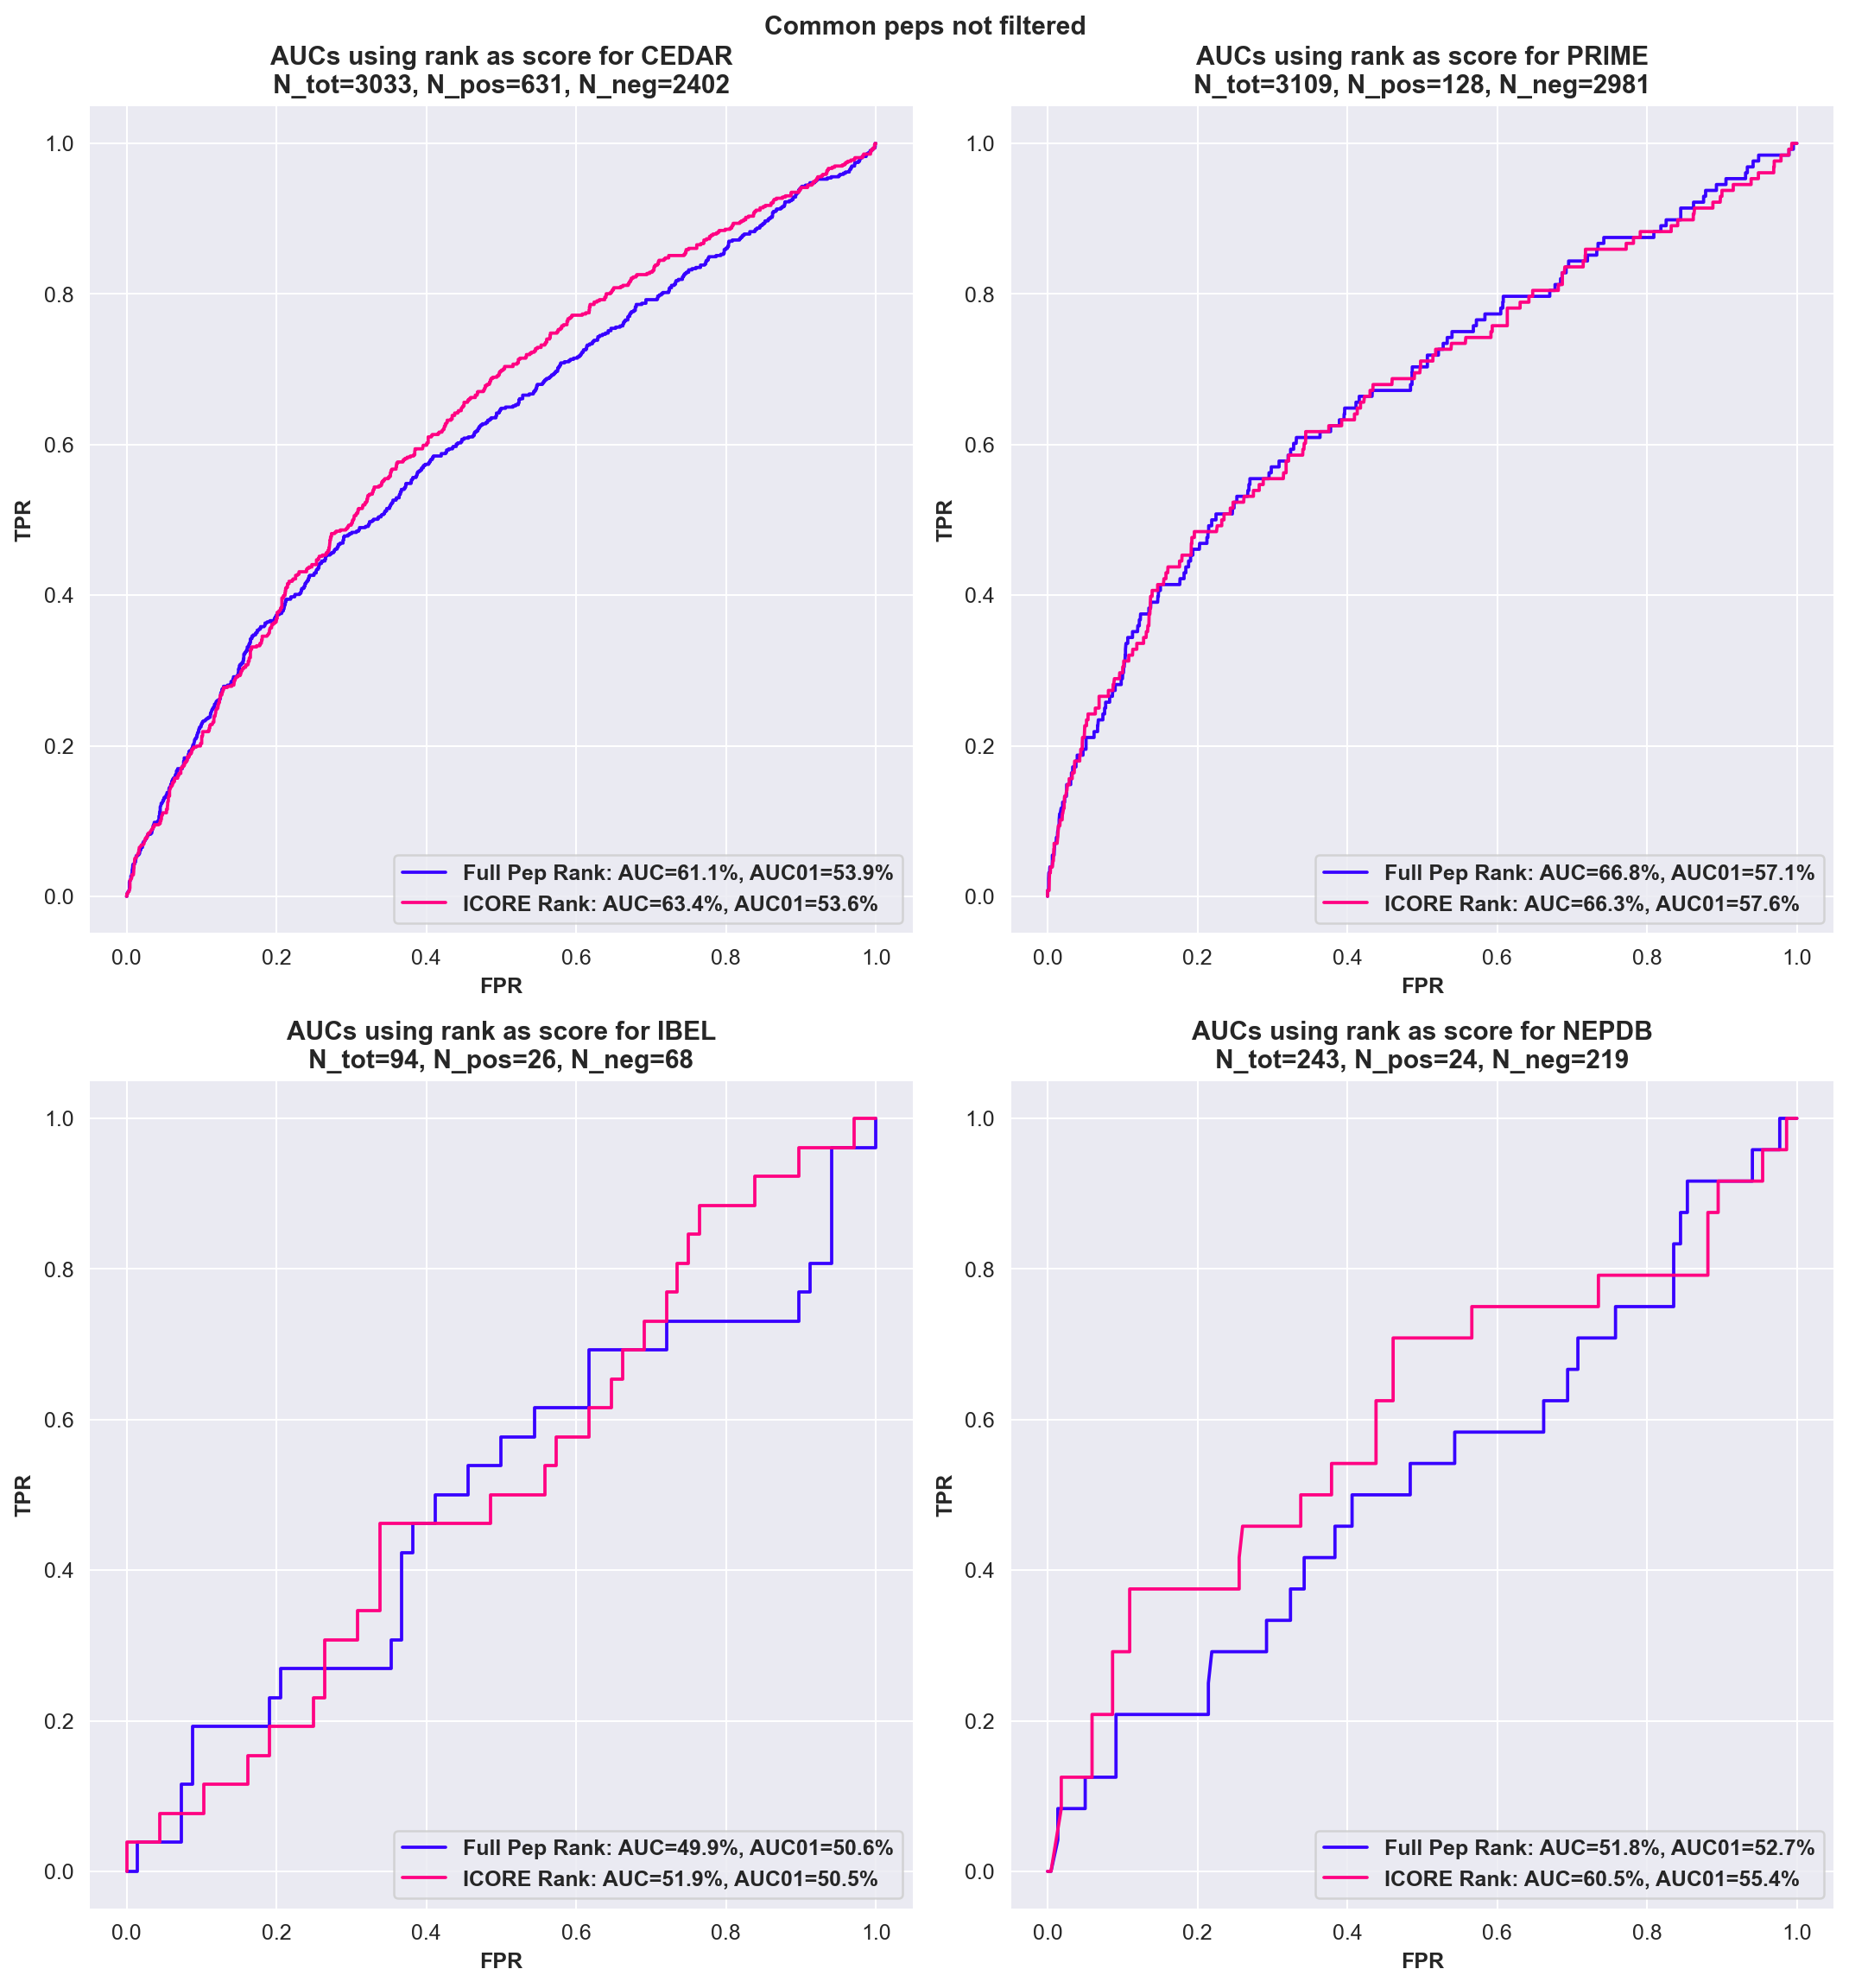

In [46]:
f,a = plt.subplots(2,2, figsize=(12,13))

for df, name, axis in zip([cedar_related, prime_related, ibel, nepdb],
                          ['CEDAR', 'PRIME', 'IBEL', 'NEPDB'],
                          a.ravel()):
    # full pep
    fpr, tpr, auc, auc01 = get_roc_curve_auc(df, 'agg_label', 'trueHLA_EL_rank', neg=True)
    sns.lineplot(x=fpr, y=tpr, label = f'Full Pep Rank: AUC={auc:.1%}, AUC01={auc01:.1%}', ax = axis, estimator=None)
    
    # icore
    fpr, tpr, auc, auc01 = get_roc_curve_auc(df, 'agg_label', 'EL_rank_mut', neg=True)
    sns.lineplot(x=fpr, y=tpr, label = f'ICORE Rank: AUC={auc:.1%}, AUC01={auc01:.1%}', ax = axis, estimator=None)
    
    axis.legend(loc='lower right', prop=dict(weight='semibold'))
    n_pos = len(df.query('agg_label==1'))
    n_neg = len(df.query('agg_label==0'))
    n = len(df)
    axis.set_title(f'AUCs using rank as score for {name}\nN_tot={n}, N_pos={n_pos}, N_neg={n_neg}', fontweight='semibold')
    axis.set_xlabel('FPR', fontweight='semibold')
    axis.set_ylabel('TPR', fontweight='semibold')
f.suptitle('Common peps not filtered', fontweight='bold')
f.tight_layout()

### filtered common peps (CEDAR+rest)

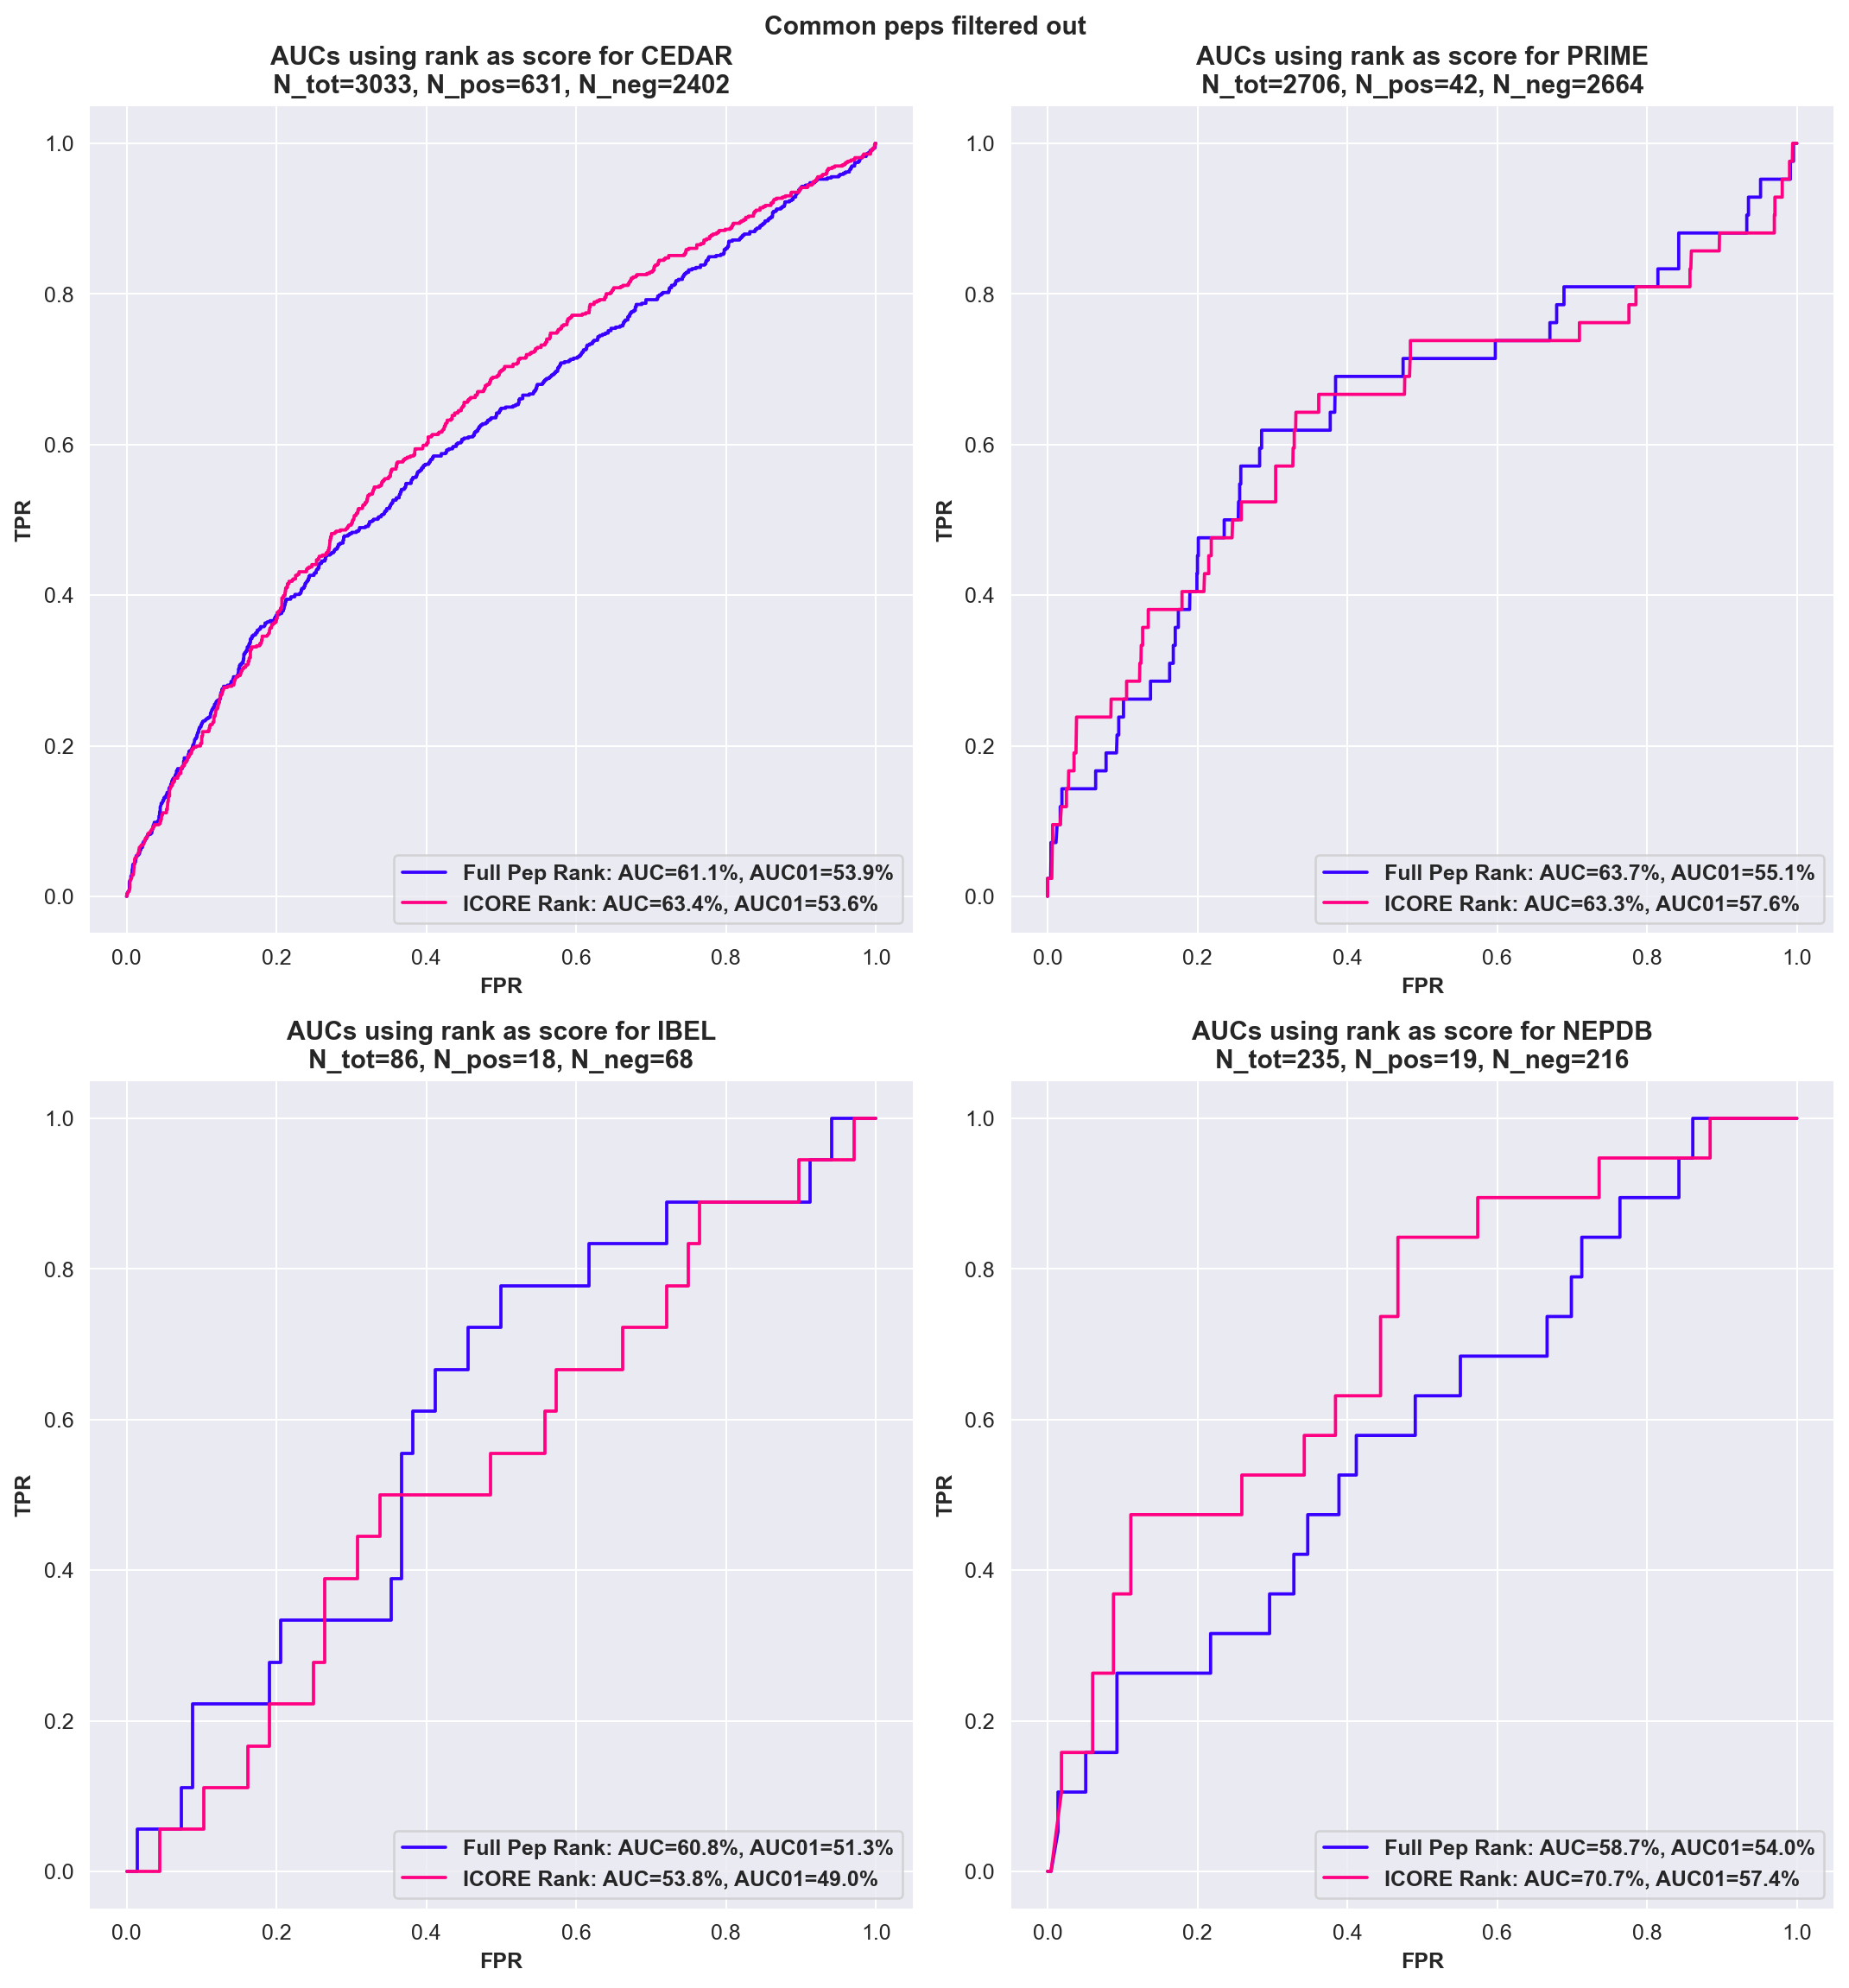

In [47]:
f,a = plt.subplots(2,2, figsize=(12,13))

for df, name, axis in zip([cedar_related, prime_related, ibel, nepdb],
                          ['CEDAR', 'PRIME', 'IBEL', 'NEPDB'],
                          a.ravel()):
    if name !='CEDAR':
        df = df.query('Peptide not in @cedar_related.Peptide.values')
    # full pep
    fpr, tpr, auc, auc01 = get_roc_curve_auc(df, 'agg_label', 'trueHLA_EL_rank', neg=True)
    sns.lineplot(x=fpr, y=tpr, label = f'Full Pep Rank: AUC={auc:.1%}, AUC01={auc01:.1%}', ax = axis, estimator=None)
    
    # icore
    fpr, tpr, auc, auc01 = get_roc_curve_auc(df, 'agg_label', 'EL_rank_mut', neg=True)
    sns.lineplot(x=fpr, y=tpr, label = f'ICORE Rank: AUC={auc:.1%}, AUC01={auc01:.1%}', ax = axis, estimator=None)
    
    axis.legend(loc='lower right', prop=dict(weight='semibold'))
    n_pos = len(df.query('agg_label==1'))
    n_neg = len(df.query('agg_label==0'))
    n = len(df)
    axis.set_xlabel('FPR', fontweight='semibold')
    axis.set_ylabel('TPR', fontweight='semibold')
    axis.set_title(f'AUCs using rank as score for {name}\nN_tot={n}, N_pos={n_pos}, N_neg={n_neg}', fontweight='semibold')
f.suptitle('Common peps filtered out', fontweight='bold')
f.tight_layout()

## Anc-non anc, improved binder vs not ?

Remaking some stats plots

In [48]:
from src.mutation_tools import pipeline_mutation_scores

In [49]:
len(cedar_related.query('agg_label==1'))/ len(cedar_related)

0.20804484009231783

In [50]:
cedar_ancs = pipeline_mutation_scores(cedar_aligned, mut_col='Peptide', wt_col = 'wild_type', ics_dict= ics_shannon, prefix = 'fullpep_')
prime_ancs = pipeline_mutation_scores(prime_aligned, mut_col='Peptide', wt_col = 'wild_type', ics_dict= ics_shannon, prefix = 'fullpep_')


In [51]:
len(cedar_related.Peptide.unique()), len(cedar_related.groupby(['Peptide', 'HLA']).count())

(2926, 3033)

In [52]:
# Some peptides in CEDAR are pos for one HLA and neg for another
non_unique = cedar_related.groupby(['Peptide', 'agg_label']).count().reset_index('agg_label').index[cedar_related.groupby(['Peptide', 'agg_label']).count().reset_index('agg_label').index.duplicated()]
cedar_related.groupby(['Peptide', 'agg_label', 'HLA']).count().loc[non_unique]

EL_rank_mut  fold  EL_rank_wt  PMIDs  \
Peptide    agg_label HLA                                               
AMAGSLVFL  0         HLA-A2402            1     1           1      1   
                     HLA-B0702            1     1           1      1   
           1         HLA-A0201            1     1           1      1   
ITDFGRAKL  0         HLA-C0401            1     1           1      1   
           1         HLA-C0102            1     1           1      1   
LTSTVQLIM  0         HLA-B3501            1     1           1      1   
           1         HLA-C1502            1     1           1      1   
RLIKHYPGI  0         HLA-A2402            1     1           1      1   
           1         HLA-A0201            1     1           1      1   
SLDLTTSPV  0         HLA-B0702            1     1           1      1   
           1         HLA-A0201            1     1           1      1   
SSLDLTTSPV 0         HLA-B0702            1     1           1      1   
           1         HLA-A0201            1     1           1      1   
VYALIAGATL 0         HLA-A0201            1     1           1      1   
           1         HLA-A2402            1     1           1      1   
YTSEILSPI  0         HLA-A2402            1     1           1      1   
           1         HLA-A0201            1     1           1      1   

                                Peptide_mut  Peptide_wt  Pos_mut  Pos_wt  \
Peptide    agg_label HLA                                                   
AMAGSLVFL  0         HLA-A2402            1           1        1       1   
                     HLA-B0702            1           1        1       1   
           1         HLA-A0201            1           1        1       1   
ITDFGRAKL  0         HLA-C0401            1           1        1       1   
           1         HLA-C0102            1           1        1       1   
LTSTVQLIM  0         HLA-B3501            1           1        1       1   
           1         HLA-C1502            1           1        1       1   
RLIKHYPGI  0         HLA-A2402            1           1        1       1   
           1         HLA-A0201            1           1        1       1   
SLDLTTSPV  0         HLA-B0702            1           1        1       1   
           1         HLA-A0201            1           1        1       1   
SSLDLTTSPV 0         HLA-B0702            1           1        1       1   
           1         HLA-A0201            1           1        1       1   
VYALIAGATL 0         HLA-A0201            1           1        1       1   
           1         HLA-A2402            1           1        1       1   
YTSEILSPI  0         HLA-A2402            1           1        1       1   
           1         HLA-A0201            1           1        1       1   

                                Related Object_Ending Position  \
Peptide    agg_label HLA                                         
AMAGSLVFL  0         HLA-A2402                               1   
                     HLA-B0702                               1   
           1         HLA-A0201                               1   
ITDFGRAKL  0         HLA-C0401                               1   
           1         HLA-C0102                               1   
LTSTVQLIM  0         HLA-B3501                               1   
           1         HLA-C1502                               1   
RLIKHYPGI  0         HLA-A2402                               1   
           1         HLA-A0201                               1   
SLDLTTSPV  0         HLA-B0702                               1   
           1         HLA-A0201                               1   
SSLDLTTSPV 0         HLA-B0702                               1   
           1         HLA-A0201                               1   
VYALIAGATL 0         HLA-A0201                               1   
           1         HLA-A2402                               1   
YTSEILSPI  0         HLA-A2402                               1   
           1         HLA-A0201

In [53]:
cedar_related.groupby(['agg_label']).count()

Peptide   HLA  EL_rank_mut  fold  EL_rank_wt  PMIDs  Peptide_mut  \
agg_label                                                                     
0             2402  2402         2402  2402        2402   2402         2402   
1              631   631          631   631         631    631          631   

           Peptide_wt  Pos_mut  Pos_wt  ...  wt_core  wt_true  \
agg_label                               ...                     
0                2402     2402    2402  ...     2402     2402   
1                 631      631     631  ...      631      631   

           aliphatic_index  boman  hydrophobicity  isoelectric_point  VHSE1  \
agg_label                                                                     
0                     2402   2402            2402               2402   2402   
1                      631    631             631                631    631   

           VHSE3  VHSE7  VHSE8  
agg_label                       
0           2402   2402   2402  
1            631    631    631  

[2 rows x 55 columns]

In [54]:
cedar_ancs.loc[cedar_ancs.apply(lambda x: ',' in x['icore_mutation_position'], axis=1)][['Peptide', 'wild_type', 'icore_mut', 'icore_wt_aligned', 'fullpep_mutation_position', 'icore_mutation_position', 'agg_label']]

Peptide    wild_type    icore_mut icore_wt_aligned  \
9       AAQARLQPV    IAMARLQPV    AAQARLQPV        IAMARLQPV   
287     CTDELLGAA    CTDQLFGAA    CTDELLGAA        CTDQLFGAA   
614    FRYYRVSILL   FRIYAVSTLL    FRYYRVSIL        FRIYAVSTL   
664    FVVPYMIYLL   YVVPYMIHLL    FVVPYMIYL        YVVPYMIHL   
805   GVSVFTLTADR  GVSVFTLTALS    SVFTLTADR        SVFTLTALS   
870     HQFHVHPLL    HRFHVHPKS    HQFHVHPLL        HRFHVHPKS   
975     ILPKVLILI    FLPKVLDLI    ILPKVLILI        FLPKVLDLI   
1016    IPSSQKVIF    IPSSQKQSF    IPSSQKVIF        IPSSQKQSF   
1034    ISIQRAQPL    LKLQRAQPL    ISIQRAQPL        LKLQRAQPL   
1073    IYVRPFSNF    IYVWPFTNF    IYVRPFSNF        IYVWPFTNF   
1232  KPPKAKPSPTY  KPPKAKPASTV  KPPKAKPSPTY      KPPKAKPASTV   
1260  KSDIGWIWELW  SSDIGWVLELP     KSDIGWIW         SSDIGWVL   
1367   LFRIKFKEPL   LYRIKFKESF     RIKFKEPL         RIKFKESF   
1428    LLHASFVTL    LLAASFETL    LLHASFVTL        LLAASFETL   
1429    LLHASFVTL    LLAASFETL    LLHASFVTL        LLAASFETL   
1430  LLHASFVTLGK  LSPACSVTLGK    HASFVTLGK        PACSVTLGK   
1535   LPSFRPPTAL   LPSLRPPTQP   LPSFRPPTAL       LPSLRPPTQP   
1560    LRNSGGEVF    LRDSGGEAF    LRNSGGEVF        LRDSGGEAF   
1581   LTFLERPREK   LTFLEKTREK   LTFLERPREK       LTFLEKTREK   
1651  MILTGILLIEI  MINTSILLIFI    MILTGILLI        MINTSILLI   
1711   MTFSSTKDYV   MTFSSTKDLC   MTFSSTKDYV       MTFSSTKDLC   
1736   NHARIDAAKV   NHARIDAAEG   NHARIDAAKV       NHARIDAAEG   
1766   NPLMCRLLGI   NPHVCRLLGI    PLMCRLLGI        PHVCRLLGI   
1795    NYWWRGQTL    NYWWRGQNT    NYWWRGQTL        NYWWRGQNT   
1914  QTDTRPWSGPY  RADTRPWSGPY  QTDTRPWSGPY      RADTRPWSGPY   
1916    QTKPASLLY    YTKGASLLY    QTKPASLLY        YTKGASLLY   
2061    RPAARGSRV    RPAARGSPR    RPAARGSRV        RPAARGSPR   
2125    RVALLSWTK    EGVLLSWTK    RVALLSWTK        EGVLLSWTK   
2147    RYPRYLYKL    MYIRYLYKL    RYPRYLYKL        MYIRYLYKL   
2154    RYYRVSILL    NPRRVSILL    RYYRVSILL        NPRRVSILL   
2383    SSCAPPLHR    SSCAPPPPP    SSCAPPLHR        SSCAPPPPP   
2429    SVFTLTADR    SVFTLTALS    SVFTLTADR        SVFTLTALS   
2430   SVFTLTADRY   SVFTLTALSA    SVFTLTADR        SVFTLTALS   
2606    TYGESFHII    TYGESFQVI    TYGESFHII        TYGESFQVI   
2625    VDNPLMCRL    VDNPHVCRL    VDNPLMCRL        VDNPHVCRL   

     fullpep_mutation_position icore_mutation_position  agg_label  
9                          0,2                     0,2          0  
287                        3,5                     3,5          0  
614                      2,4,7                   2,4,7          1  
664                        0,7                     0,7          1  
805                       9,10                     7,8          0  
870                      1,7,8                   1,7,8          0  
975                        0,6                     0,6          1  
1016                       6,7                     6,7          0  
1034                     0,1,2                   0,1,2          0  
1073                       3,6                     3,6          0  
1232                    7,8,10                  7,8,10          0  
1260                  0,6,7,10                   0,6,7          1  
1367                     1,8,9                     6,7          1  
1428                       2,6                     2,6          1  
1429                       2,6                     2,6          1  
1430                   1,2,4,5                   0,2,3          1  
1535                     3,8,9                   3,8,9          0  
1560                       2,7                     2,7          0  
1581                       5,6                     5,6          0  
1651                     2,4,9                     2,4          1  
1711                       8,9                     8,9          0  
1736                       8,9                     8,9          0  
1766                       2,3                     1,2          0  
1795                       7,8                     7,8          0  
1914 

In [55]:
out_icore = cedar_ancs.query('icore_mutation_position=="-1"')
in_icore = cedar_ancs.query('icore_mutation_position!="-1"')
anc_counts = in_icore.groupby(['icore_anchor_mutation']).agg(count=('Peptide', 'count'))


In [56]:
anc_counts['ratio'] = anc_counts / len(cedar_aligned)

In [57]:
anc_counts

count     ratio
icore_anchor_mutation                 
False                   1935  0.637982
True                     982  0.323772

In [58]:
out_icore.groupby('agg_label').count()

HLA  fold  Peptide  wild_type  icore_mut  core_mut  len  \
agg_label                                                            
0          105   105      105        105        105       105  105   
1           11    11       11         11         11        11   11   

           EL_rank_mut  EL_rank_wt  trueHLA_EL_rank  ...  Peptide_wt  core_wt  \
agg_label                                            ...                        
0                  105         105              105  ...         105      105   
1                   11          11               11  ...          11       11   

           ratio_rank  fullpep_len_mut  fullpep_len_wt  fullpep_anchor  \
agg_label                                                                
0                 105              105             105             105   
1                  11               11              11              11   

           fullpep_mutation_position  fullpep_anchor_mutation  \
agg_label                                                       
0                                105                      105   
1                                 11                       11   

           fullpep_mut_score  fullpep_blsm_mut_score  
agg_label                                             
0                        105                     105  
1                         11                      11  

[2 rows x 44 columns]

In [59]:
# mutation outside of icore
out_icore = cedar_ancs.query('icore_mutation_position=="-1"')
# mutation inside aligned icore
in_icore = cedar_ancs.query('icore_mutation_position!="-1"')
anc_counts = in_icore.groupby(['agg_label', 'icore_anchor_mutation']).agg(count=('Peptide', 'count'))
anc_counts['ratio'] = anc_counts / in_icore.groupby(['agg_label']).agg(count=('Peptide', 'count'))
print('Pos/tot and Neg/tot ratios for CEDAR: ', round(len(cedar_aligned.query('agg_label==1'))/len(cedar_aligned),3), round(len(cedar_aligned.query('agg_label==0'))/len(cedar_aligned),3))
anc_counts

Pos/tot and Neg/tot ratios for CEDAR:  0.208 0.792


count     ratio
agg_label icore_anchor_mutation                 
0         False                   1524  0.663474
          True                     773  0.336526
1         False                    411  0.662903
          True                     209  0.337097

In [60]:
411/(1524+411)

0.2124031007751938

In [61]:
top_hlas = ['HLA-A0201', 'HLA-A0301', 'HLA-A1101', 'HLA-B0702', 'HLA-B1501', 'HLA-B3501']
top_counts = in_icore.query('HLA in @top_hlas').groupby(['HLA', 'icore_anchor_mutation', 'agg_label']).agg(count=('Peptide','count'))
top_counts['ratio'] = 100*top_counts / in_icore.query('HLA in @top_hlas').groupby(['HLA', 'icore_anchor_mutation']).agg(count=('Peptide', 'count'))

In [62]:
per_hla = in_icore.query('HLA in @top_hlas').groupby(['HLA', 'icore_anchor_mutation']).agg(count=('Peptide', 'count'))
per_hla['ratio'] = 100*per_hla / in_icore.query('HLA in @top_hlas').groupby(['HLA']).agg(count=('Peptide', 'count'))
per_hla

count      ratio
HLA       icore_anchor_mutation                  
HLA-A0201 False                    664  59.551570
          True                     451  40.448430
HLA-A0301 False                    102  64.968153
          True                      55  35.031847
HLA-A1101 False                    180  73.170732
          True                      66  26.829268
HLA-B0702 False                    207  71.379310
          True                      83  28.620690
HLA-B1501 False                     94  65.277778
          True                      50  34.722222
HLA-B3501 False                     76  76.000000
          True                      24  24.000000

In [63]:
top_counts

count      ratio
HLA       icore_anchor_mutation agg_label                  
HLA-A0201 False                 0            457  68.825301
                                1            207  31.174699
          True                  0            351  77.827051
                                1            100  22.172949
HLA-A0301 False                 0             85  83.333333
                                1             17  16.666667
          True                  0             49  89.090909
                                1              6  10.909091
HLA-A1101 False                 0            157  87.222222
                                1             23  12.777778
          True                  0             59  89.393939
                                1              7  10.606061
HLA-B0702 False                 0            196  94.685990
                                1             11   5.314010
          True                  0             74  89.156627
                                1              9  10.843373
HLA-B1501 False                 0             86  91.489362
                                1              8   8.510638
          True                  0             41  82.000000
                                1              9  18.000000
HLA-B3501 False                 0             63  82.894737
                                1             13  17.105263
          True                  0             23  95.833333
                                1              1   4.166667

In [64]:
out_icore[['Peptide', 'wild_type', 'fullpep_anchor', 'len', 'HLA', 'agg_label', 'fullpep_anchor_mutation']]

Peptide    wild_type fullpep_anchor  len        HLA  agg_label  \
22    AEWRNGSTSSL  PEWRNGSTSSL         0,1,10   11  HLA-A6801          0   
23    AFLSTHLKLFL  AFLSTHLKLFP           1,10   11  HLA-A2402          0   
25    AFQTSEKKFYI  AFQTSEKKFHI           1,10   11  HLA-A2402          0   
39    AIYHTLNLFNI  AIYHTLNLCNI     0,1,3,5,10   11  HLA-A0201          0   
117   ALWSLSRHASL  ALWSLSRHAAL     0,1,3,5,10   11  HLA-A0201          0   
...           ...          ...            ...  ...        ...        ...   
2958  YQDKWAEKPAF  HQDKWAEKPAF         1,3,10   11  HLA-B3501          0   
2996  YTILRALEFHL  DTILRALEFHL     0,1,3,5,10   11  HLA-A0201          0   
3013  YVMASVFVCPL  YVMASVFVCLL     0,1,3,5,10   11  HLA-A0201          0   
3017  YVRVTVQARVM  CVRVTVQARVM       0,1,3,10   11  HLA-B0702          1   
3023  YVYSVAKTDSF  HVYSVAKTDSF       0,1,3,10   11  HLA-B0702          0   

      fullpep_anchor_mutation  
22                       True  
23                       True  
25                      False  
39                      False  
117                     False  
...                       ...  
2958                     True  
2996                     True  
3013                    False  
3017                     True  
3023                     True  

[116 rows x 7 columns]

In [65]:
out_icore.groupby(['agg_label', 'fullpep_anchor_mutation']).count()

HLA  fold  Peptide  wild_type  icore_mut  \
agg_label fullpep_anchor_mutation                                             
0         False                     17    17       17         17         17   
          True                      88    88       88         88         88   
1         False                      4     4        4          4          4   
          True                       7     7        7          7          7   

                                   core_mut  len  EL_rank_mut  EL_rank_wt  \
agg_label fullpep_anchor_mutation                                           
0         False                          17   17           17          17   
          True                           88   88           88          88   
1         False                           4    4            4           4   
          True                            7    7            7           7   

                                   trueHLA_EL_rank  ...  Peptide_mut  \
agg_label fullpep_anchor_mutation                   ...                
0         False                                 17  ...           17   
          True                                  88  ...           88   
1         False                                  4  ...            4   
          True                                   7  ...            7   

                                   Peptide_wt  core_wt  ratio_rank  \
agg_label fullpep_anchor_mutation                                    
0         False                            17       17          17   
          True                             88       88          88   
1         False                             4        4           4   
          True                              7        7           7   

                                   fullpep_len_mut  fullpep_len_wt  \
agg_label fullpep_anchor_mutation                                    
0         False                                 17              17   
          True                                  88              88   
1         False                                  4               4   
          True                                   7               7   

                                   fullpep_anchor  fullpep_mutation_position  \
agg_label fullpep_anchor_mutation                                              
0         False                                17                         17   
          True                                 88                         88   
1         False                                 4                          4   
          True                                  7                          7   

                                   fullpep_mut_score  fullpep_blsm_mut_score  
agg_label fullpep_anchor_mutation                                             
0         False                                   17                      17  
          True                                    88                      88  
1         False                                    4                       4  
          True                                     7                       7  

[4 rows x 43 columns]

In [66]:
# mutation outside of icore
out_icore = prime_ancs.query('icore_mutation_position=="-1"')
# mutation inside aligned icore
in_icore = prime_ancs.query('icore_mutation_position!="-1"')
anc_counts = in_icore.groupby(['icore_anchor_mutation', 'agg_label']).agg(count=('Peptide', 'count'))
anc_counts['ratio'] = anc_counts / in_icore.groupby(['icore_anchor_mutation']).agg(count=('Peptide', 'count'))
print('Pos/tot and Neg/tot ratios for PRIME: ',
      round(len(prime_aligned.query('agg_label==1'))/len(prime_aligned),3), 
      round(len(prime_aligned.query('agg_label==0'))/len(prime_aligned),3))
anc_counts

Pos/tot and Neg/tot ratios for PRIME:  0.041 0.959


count     ratio
icore_anchor_mutation agg_label                 
False                 0           1934  0.956006
                      1             89  0.043994
True                  0            916  0.960168
                      1             38  0.039832

# 2 ICORE vs Pep

In [ ]:
# Plots showing the weight preference for inverted weights in CEDAR
cedar_total_df = pd.read_csv('../output/221122_mutscore_cedar_fixed/total_df.csv').query('(not weight.str.contains("Shannon")) and key=="only_rank" and evalset!="PRIME_AC" and encoding=="BL62LO"')
cedar_total_df = cedar_total_df.query('(pep_col=="Peptide" and rank_col=="trueHLA_EL_rank") or (pep_col=="icore_mut" and rank_col=="EL_rank_mut") and evalset !="PRIME_AC"')
display(cedar_total_df.groupby(['pep_col', 'rank_col', 'evalset', 'encoding', 'key', 'weight']).count())

cedar_total_df['type'] = cedar_total_df['pep_col'].apply(lambda x: 'ICORE + ICORE %Rank' if x=='icore_mut' else "Peptide + Full pep %Rank")
display(cedar_total_df.sample(5))

In [ ]:
# Get p-values of weights difference for icore and pep, with their biologically relevant ranks
pep_full_rank = df_baseline_pep.query('rank_col == "trueHLA_EL_rank"')
icore_el_rank = df_baseline_icore.query('rank_col == "EL_rank_mut"')

weight_order = ['Inverted KL', 'Inverted Mask', 'None', 'Mask', 'KL']
f,a = plt.subplots(1,2, figsize=(20,7), sharey=True)

for df, axis, title in zip([pep_full_rank, icore_el_rank], a.ravel(), df_input_comp.type.unique()):
    sns.boxplot(data=df, x='weight', y='auc', order = weight_order, ax=axis, palette = color_order)
    add_median_labels(axis, fmt='.1%')
    # Getting pvals
    aucs_base = df.query('weight==@weight_order[0]').auc.values
    h0 = 0.01
    h = h0
    x0, x1 = 0, 1
    for i, comparison in enumerate(weight_order[1:]):
        median = round(df.query('weight==@comparison'), 4)
        aucs_comp = df.query('weight==@comparison').auc.values
        pval, sig = get_pval(aucs_base, aucs_comp)
        plot_pval(axis, pval, sig, x0, x1, y = max(aucs_base)+h, h=h0)
        x1 += 1
        h += 2*h0
    axis.set_xticklabels(axis.get_xticklabels(), fontweight='semibold', fontsize=13)
    axis.set_title(f'P-values for weights difference in weight for {title}', fontweight='semibold', fontsize=13)
    axis.set_ylabel('AUC', fontweight='semibold', fontsize=13)
    axis.set_xlabel('')
a[1].set_ylabel('')
f.tight_layout()
f.savefig('../../../meetings/slides/2301XX_CEDAR_meeting_update/weight_diff_pvals.png', bbox_inches='tight', dpi=200)

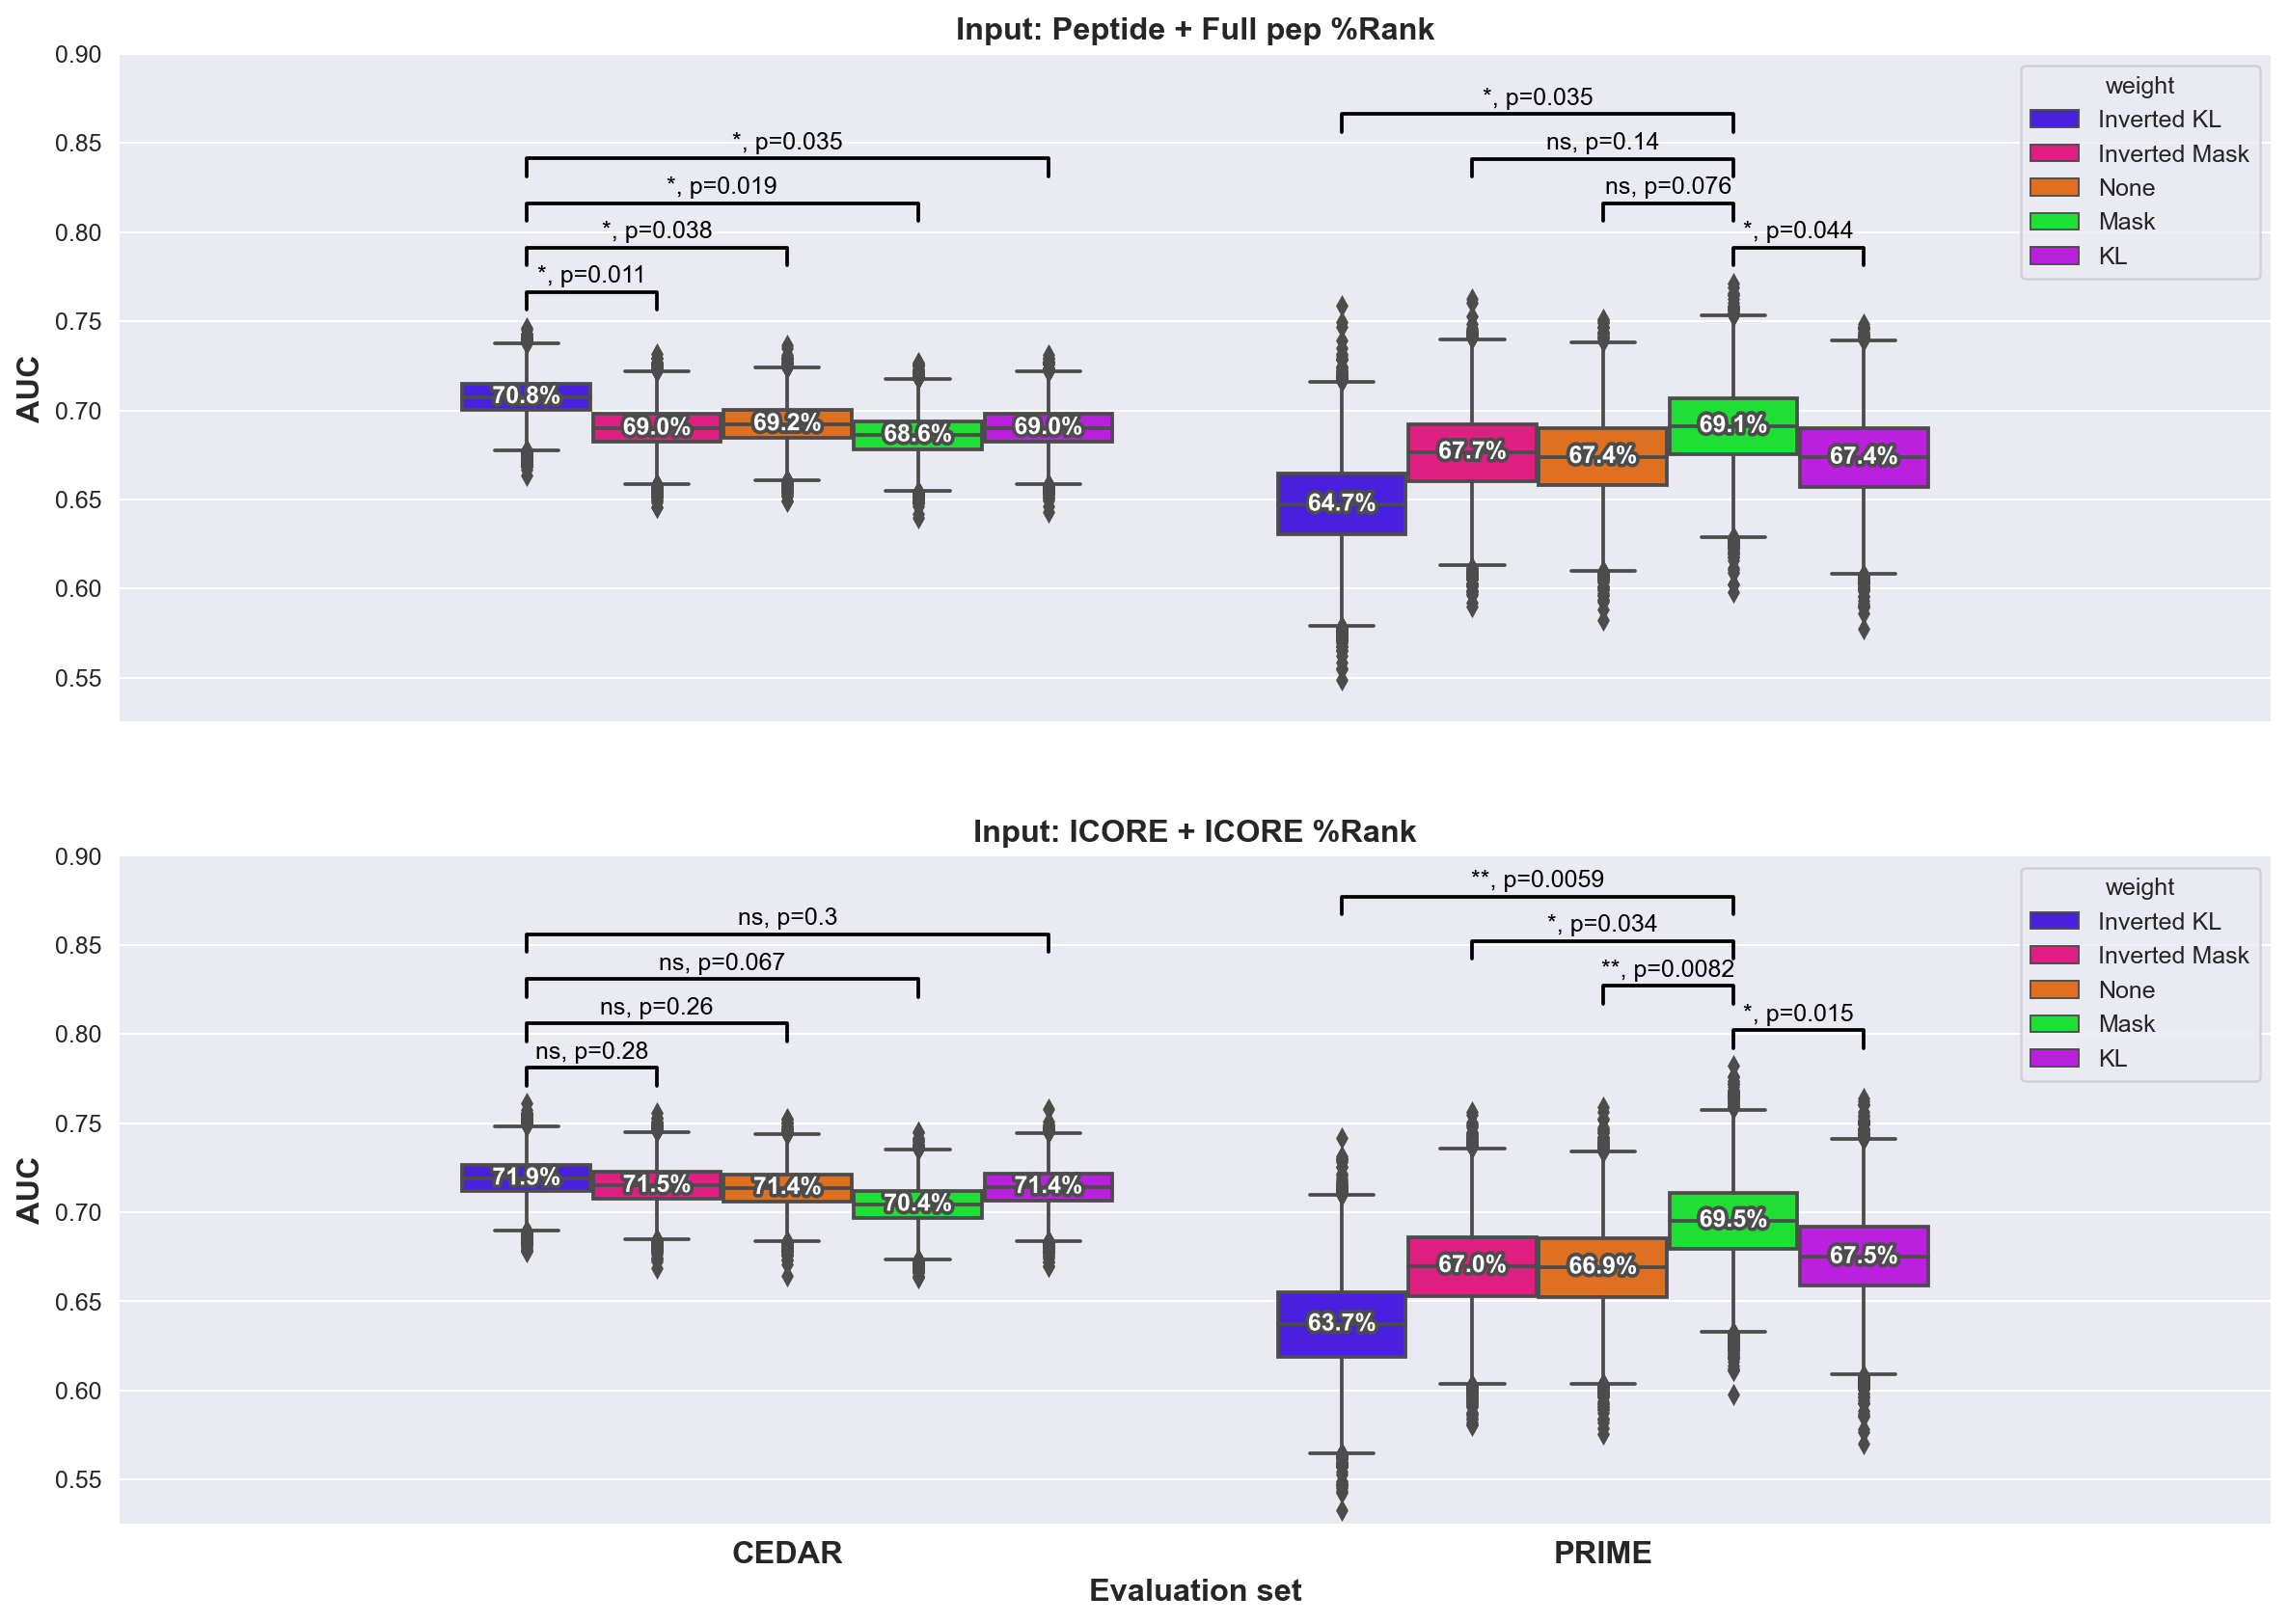

In [ ]:
f,a = plt.subplots(2,1, figsize=(16,11), sharex=True)
weight_order = ['Inverted KL', 'Inverted Mask', 'None', 'Mask', 'KL']
weight_color_order = {k:v for k,v in zip(weight_order, NEWPAL[:len(weight_order)])}
for type_, axis in zip(cedar_total_df['type'].unique(), a.ravel()):
    tmp = cedar_total_df.query('type==@type_ and evalset!="IBEL"')
    sns.boxplot(data= tmp, x='evalset', hue = 'weight', y = 'auc',
                hue_order = weight_order, palette = weight_color_order, ax=axis)
    add_median_labels(axis)
    
    axis.set_title(f'Input: {type_}', fontweight='semibold', fontsize=13)
    axis.set_xticklabels(axis.get_xticklabels(), fontweight='semibold', fontsize=13)
    axis.set_ylabel('AUC', fontweight='semibold', fontsize=13)
    
    # X0 (CEDAR) pvals
    dx = .16 # Because boxwidth = 0.8 by default, and we have 5 boxes -> .8/5 = .16
    x0 = 0
    xs = [x0-2*dx, x0-dx, x0, x0+dx, x0+2*dx]
    x1 = xs[weight_order.index('Inverted KL')]
    h, h0 = 0.01, 0.0125
    aucs_inv = tmp.query('evalset=="CEDAR" and weight=="Inverted KL"').auc.values
    for i, comp in enumerate(weight_order[1:]):
        x2 = xs[weight_order.index(comp)]
        aucs_comp = tmp.query('evalset=="CEDAR" and weight==@comp').auc.values
        pval, sig = get_pval(aucs_inv, aucs_comp)
        plot_pval(axis, pval, sig ,x1, x2, y=max(aucs_inv)+h,h=h0, color='k')
        # x1+=dx
        h+=2*h0
        
    # X1 (PRIME) pvals
    dx = .16 # Because boxwidth = 0.8 by default, and we have 5 boxes -> .8/5 = .16
    x0 = 1
    xs = [x0-2*dx, x0-dx, x0, x0+dx, x0+2*dx]
    x1 = xs[weight_order.index('Mask')]
    h, h0 = 0.01, 0.0125
    aucs_inv = tmp.query('evalset=="PRIME" and weight=="Mask"').auc.values
    for comp in reversed(list(filter(lambda x: x!='Mask', weight_order))):
        x2 = xs[weight_order.index(comp)]
        aucs_comp = tmp.query('evalset=="PRIME" and weight==@comp').auc.values
        pval, sig = get_pval(aucs_inv, aucs_comp)
        plot_pval(axis, pval, sig ,x1, x2, y=max(aucs_inv)+h,h=h0, color='k')
        # x1+=dx
        h+=2*h0
    axis.set_ylim([.525, .9])
a[0].set_xlabel('')
axis.set_xlabel('Evaluation set', fontweight='semibold', fontsize=13)

display_coordinates_1=[]
display_coordinates_2=[]

f.savefig('../../../meetings/slides/2301XX_CEDAR_meeting_update/inputs_comparison_weight_trend',
          bbox_inches='tight', dpi=200)

In [225]:
cedar_aligned.groupby('len').count()

HLA  agg_label  fold  Peptide  wild_type  icore_mut  core_mut  \
len                                                                   
9    1531       1531  1531     1531       1531       1531      1531   
10    875        875   875      875        875        875       875   
11    625        625   625      625        625        625       625   
12      2          2     2        2          2          2         2   

     EL_rank_mut  EL_rank_wt  trueHLA_EL_rank  ...  isoelectric_point  VHSE1  \
len                                            ...                             
9           1531        1531             1531  ...               1531   1531   
10           875         875              875  ...                875    875   
11           625         625              625  ...                625    625   
12             2           2                2  ...                  2      2   

     VHSE3  VHSE7  VHSE8  seq_id  core_wt_aligned  EL_rank_wt_aligned  \
len                                                                     
9     1531   1531   1531    1531             1531                1531   
10     875    875    875     875              875                 875   
11     625    625    625     625              625                 625   
12       2      2      2       2                2                   2   

     ratio_rank  foreignness_score  
len                                 
9          1531               1531  
10          875                875  
11          625                625  
12            2                  2  

[4 rows x 34 columns]

In [226]:
cedar_aligned['len_icore_mut'] = cedar_aligned['icore_mut'].apply(len)
cedar_aligned.groupby(['len_icore_mut']).count()

HLA  agg_label  fold  Peptide  wild_type  icore_mut  core_mut  \
len_icore_mut                                                                   
8               125        125   125      125        125        125       125   
9              2146       2146  2146     2146       2146       2146      2146   
10              525        525   525      525        525        525       525   
11              236        236   236      236        236        236       236   
12                1          1     1        1          1          1         1   

                len  EL_rank_mut  EL_rank_wt  ...  isoelectric_point  VHSE1  \
len_icore_mut                                 ...                             
8               125          125         125  ...                125    125   
9              2146         2146        2146  ...               2146   2146   
10              525          525         525  ...                525    525   
11              236          236         236  ...                236    236   
12                1            1           1  ...                  1      1   

               VHSE3  VHSE7  VHSE8  seq_id  core_wt_aligned  \
len_icore_mut                                                 
8                125    125    125     125              125   
9               2146   2146   2146    2146             2146   
10               525    525    525     525              525   
11               236    236    236     236              236   
12                 1      1      1       1                1   

               EL_rank_wt_aligned  ratio_rank  foreignness_score  
len_icore_mut                                                     
8                             125         125                125  
9                            2146        2146               2146  
10                            525         525                525  
11                            236         236                236  
12                              1           1                  1  

[5 rows x 34 columns]

In [228]:
# Redo performance per peptide length for full peptides and icore:
# To do so : Take preds for each input & weight, using only onehot and only_rank, for CEDAR & PRIME as evalsets
# then query the preds by length, bootstrap 10k times for each.
from src.bootstrap import bootstrap_eval
dir_ = '../output/221122_mutscore_cedar_fixed/raw/'

bdfs = []
for evalset in tqdm(['prime', 'cedar']):
    for weight in tqdm(['Inverted-KL', 'Inverted-Mask', 'None', 'Mask', 'KL']):
        for inputs in tqdm(['icore_mut_EL_rank_mut', 'Peptide_trueHLA_EL_rank']):
            df = pd.read_csv(f'{dir_}{evalset}_preds_onehot_{weight}_{inputs}_only_rank.csv')
            df['len_icore']=df['icore_mut'].apply(len)
            
            scorecol = 'pred' if 'pred' in df.columns else 'mean_pred'
            
            for len_ in tqdm(range(8,13)):
                if inputs.startswith('Peptide'):
                    tmp = df.query('len==@len_')
                else:
                    tmp = df.query('len_icore==@len_')
                if len(tmp)<100:continue
                bdf, _ = bootstrap_eval(tmp[scorecol].values, tmp['agg_label'].values, n_jobs=8)
                bdf['weight']=weight
                bdf['input']=inputs
                bdf['evalset']=evalset
                bdf['length']=len_
                bdfs.append(bdf)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Couldn't get AUCs/etc because there's only one class in the dataset
Only negatives: True, Only positives: False
Couldn't get AUCs/etc because there's only one class in the dataset
Only negatives: True, Only positives: False
Couldn't get AUCs/etc because there's only one class in the dataset
Only negatives: True, Only positives: False
Couldn't get AUCs/etc because there's only one class in the dataset
Only negatives: True, Only positives: False
Couldn't get AUCs/etc because there's only one class in the dataset
Only negatives: True, Only positives: False
Couldn't get AUCs/etc because there's only one class in the dataset
Only negatives: True, Only positives: False
Couldn't get AUCs/etc because there's only one class in the dataset
Only negatives: True, Only positives: False
Couldn't get AUCs/etc because there's only one class in the dataset
Only negatives: True, Only positives: False
Couldn't get AUCs/etc because there's only one class in the dataset
Only negatives: True, Only positives

ValueError: max() arg is an empty sequence

# 3. Weighting schemes difference

In [923]:
# See 230116_cedar_meeting_benchmark

# 4: Adding features to the base model

## reload redo gb/agg

### gbmeans

In [70]:
gb_merged = pd.read_csv('../output/230125_expr_mutscores/gb_merged.csv')
gb_merged.query('experiment=="aligned_mutscore"').sort_values('Compromise', ascending=False).head().set_index(['encoding', 'weight', 'key'])

pep_col  \
encoding weight        key                                                             
onehot   None          icore_dissimilarity_score-icore_blsm_mut_score-...  icore_mut   
                       icore_dissimilarity_score-icore_blsm_mut_score      icore_mut   
         Inverted Mask icore_dissimilarity_score-icore_blsm_mut_score      icore_mut   
                       icore_dissimilarity_score-icore_blsm_mut_score-...  icore_mut   
                       icore_dissimilarity_score-icore_mut_score           icore_mut   

                                                                                 experiment  \
encoding weight        key                                                                    
onehot   None          icore_dissimilarity_score-icore_blsm_mut_score-...  aligned_mutscore   
                       icore_dissimilarity_score-icore_blsm_mut_score      aligned_mutscore   
         Inverted Mask icore_dissimilarity_score-icore_blsm_mut_score      aligned_mutscore   
                       icore_dissimilarity_score-icore_blsm_mut_score-...  aligned_mutscore   
                       icore_dissimilarity_score-icore_mut_score           aligned_mutscore   

                                                                           mean_auc_CEDAR  \
encoding weight        key                                                                  
onehot   None          icore_dissimilarity_score-icore_blsm_mut_score-...        0.716155   
                       icore_dissimilarity_score-icore_blsm_mut_score            0.715718   
         Inverted Mask icore_dissimilarity_score-icore_blsm_mut_score            0.715523   
                       icore_dissimilarity_score-icore_blsm_mut_score-...        0.714779   
                       icore_dissimilarity_score-icore_mut_score                 0.715557   

                                                                           mean_precision_CEDAR  \
encoding weight        key                                                                        
onehot   None          icore_dissimilarity_score-icore_blsm_mut_score-...              0.502500   
                       icore_dissimilarity_score-icore_blsm_mut_score                  0.770911   
         Inverted Mask icore_dissimilarity_score-icore_blsm_mut_score                  0.638033   
                       icore_dissimilarity_score-icore_blsm_mut_score-...              0.601163   
                       icore_dissimilarity_score-icore_mut_score                       0.584657   

                                                                           mean_auc_PRIME  \
encoding weight        key                                                                  
onehot   None          icore_dissimilarity_score-icore_blsm_mut_score-...        0.706413   
                       icore_dissimilarity_score-icore_blsm_mut_score            0.706836   
         Inverted Mask icore_dissimilarity_score-icore_blsm_mut_score            0.705889   
                       icore_dissimilarity_score-icore_blsm_mut_score-...        0.705274   
                       icore_dissimilarity_score-icore_mut_score                 0.703406   

                                                                           mean_precision_PRIME  \
encoding weight        key                                                                        
onehot   None          icore_dissimilarity_score-icore_blsm_mut_score-...              0.000000   
                       icore_dissimilarity_score-icore_blsm_mut_score                  0.000000   
         Inverted Mask icore_dissimilarity_score-icore_blsm_mut_score                  0.000000   
                       icore_dissimilarity_score-icore_blsm_mut_score-...              0.000000   
                       icore_dissimilarity_score-icore_mut_score                       0.314842   

                                                                           mean_auc_IBEL  \
encoding w

In [71]:
from src.bootstrap import bootstrap_eval
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from sklearn.ensemble import RandomForestClassifier
# Missing the grouped cdt (aaprops + diss + blsm mut)
# retrain manually here and bootstrap

cols_ = ['aliphatic_index',
  'boman',
  'hydrophobicity',
  'isoelectric_point',
  'VHSE1',
  'VHSE3',
  'VHSE7',
  'VHSE8',
  'icore_dissimilarity_score',
 'icore_blsm_mut_score']

encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': True,
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True,
                   'invert':True,
                   'seq_col':'icore_mut',
                   'rank_col':'EL_rank_mut',
                  'mut_col':cols_}
model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                                           max_depth=8, ccp_alpha=9.945e-6)
# Training model and getting feature importances
print('Training')
trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_aligned, model,
                                                            ics_dict=ics_shannon,
                                                            encoding_kwargs=encoding_kwargs,
                                                            n_jobs=10)
fi = get_nested_feature_importance(trained_models)
fn = AA_KEYS + ['rank'] + cols_
# Saving Feature importances as dataframe
df_fi = pd.DataFrame(fi, index=fn).T
_, preds_df = evaluate_trained_models_sklearn(cedar_aligned, trained_models, ics_shannon,
                                                                           cedar_aligned,
                                                                           encoding_kwargs, concatenated=False,
                                                                           only_concat=False)
# p_col = 'pred' if 'pred' in preds.columns else 'mean_pred'

scores = preds_df.pred.values if 'pred' in preds_df.columns else preds_df['mean_pred'].values
targets = preds_df.agg_label.values if 'agg_label' in preds_df.columns else preds_df['Immunogenicity'].values

bootstrapped_df, mean_rocs = bootstrap_eval(y_score=scores,
                                            y_true=targets,
                                            n_rounds=10000, n_jobs=8)
bootstrapped_df.auc.mean()

Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


0.7337754737936023

(<Figure size 1260x1080 with 1 Axes>,
 <AxesSubplot:xlabel='Percentage importance [%]', ylabel='Feature name'>)

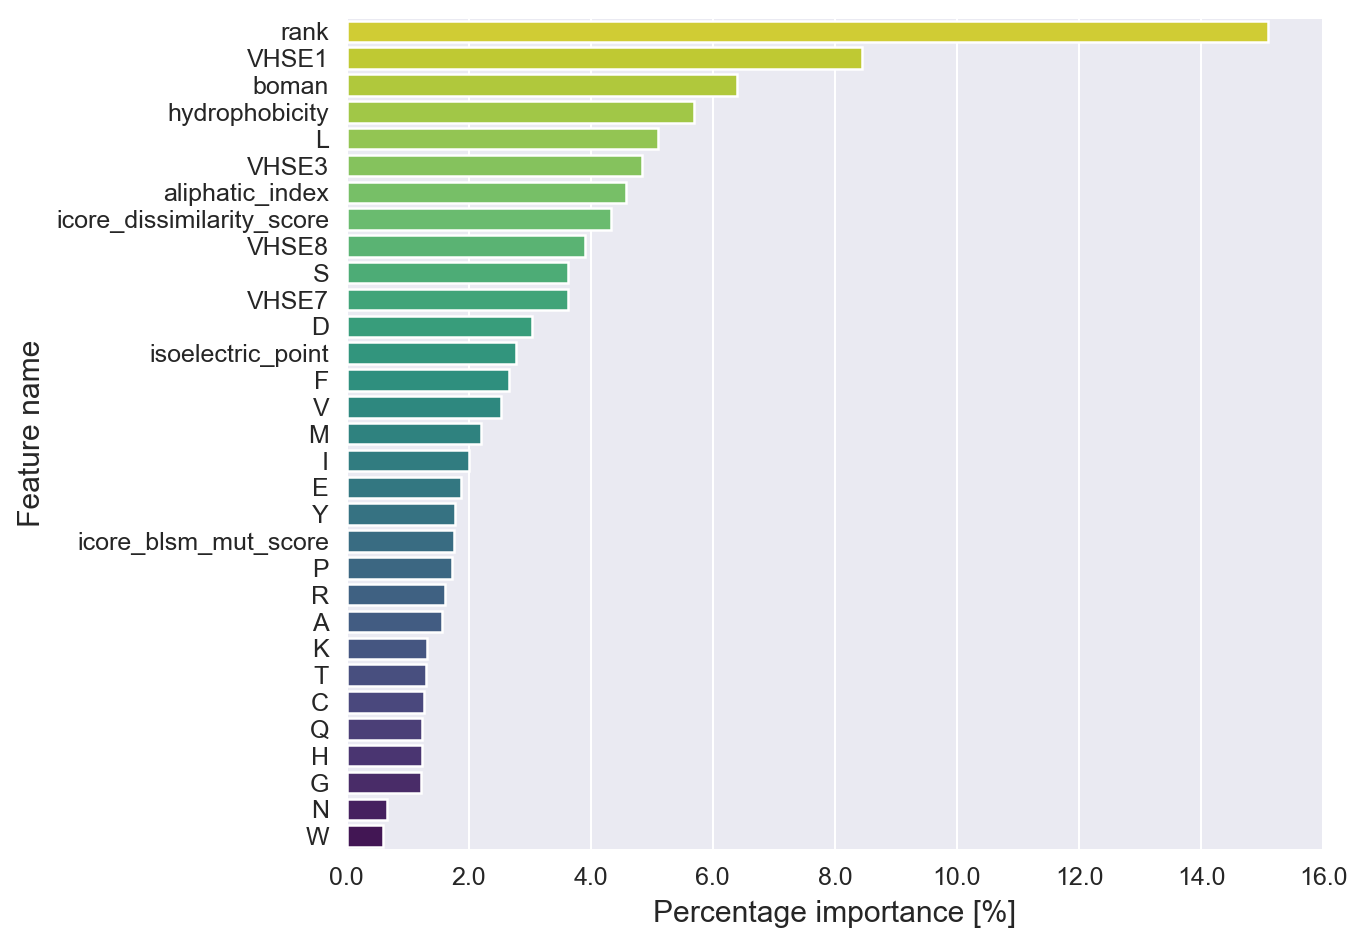

In [72]:
plot_feature_importance(df_fi.values.flatten(), df_fi.columns,)

## Redo ROCs plots 

In [73]:
len(NEWPAL)

6

In [74]:
cdt_cols = ['encoding', 'weight','pep_col','rank_col','key']
pdir = '../output/230125_aligned_icore_mutscore/raw/'
fs = sorted(filter(lambda x: ('Peptide_trueHLA' in x or 'icore_mut_EL_rank' in x) and 'featimp' not in x, os.listdir(pdir)))
cpeps = cedar_related_baseline.Peptide.values
ppeps = prime_related_baseline.Peptide.values
cp_common_peps = [x for x in cpeps if x in ppeps]
ommited = [x for x in ppeps if x not in pd.read_csv(f'{pdir}{fs[-1]}').Peptide.values]
len(ibel.query('Peptide not in @cpeps and Peptide not in @ppeps')), len(ibel)


(86, 94)

In [75]:
# Here, show ROCs, for a few conditions (Using only the inverted KL)
# --> AA props vs Dissimilarity score + blsm mut score
aa_map = {'aa_props':'aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8'}
# CEDAR
cedar_preds_base = pd.read_csv('../output/230125_aligned_icore_mutscore/raw/CEDAR_preds_cedar_onehot_None_icore_mut_EL_rank_mut_only_rank.csv')
cedar_preds_aaprops = pd.read_csv('../output/230125_aligned_icore_mutscore/raw/CEDAR_preds_cedar_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aa_props.csv')
cedar_preds_dissblsm = pd.read_csv('../output/230125_aligned_icore_mutscore/raw/CEDAR_preds_cedar_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_blsm_mut_score-icore_mut_score.csv')
cedar_preds_blsm = pd.read_csv('../output/230125_aligned_icore_mutscore/raw/CEDAR_preds_cedar_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_icore_blsm_mut_score.csv')
cedar_preds_opp_weight = pd.read_csv('../output/230125_aligned_icore_mutscore/raw/CEDAR_preds_cedar_onehot_Mask_icore_mut_EL_rank_mut_only_rank.csv')
cedar_preds_opp_best = pd.read_csv('../output/230125_aligned_icore_mutscore/raw/CEDAR_preds_cedar_onehot_Mask_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_blsm_mut_score.csv')
# PRIME
prime_preds_base = pd.read_csv('../output/230125_aligned_icore_mutscore/raw/PRIME_preds_cedar_onehot_None_icore_mut_EL_rank_mut_only_rank.csv')
prime_preds_aaprops = pd.read_csv('../output/230125_aligned_icore_mutscore/raw/PRIME_preds_cedar_onehot_Mask_icore_mut_EL_rank_mut_aa_props.csv')
prime_preds_dissblsm = pd.read_csv('../output/230125_aligned_icore_mutscore/raw/PRIME_preds_cedar_onehot_Mask_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_blsm_mut_score-icore_mut_score.csv')
prime_preds_blsm =pd.read_csv('../output/230125_aligned_icore_mutscore/raw/PRIME_preds_cedar_onehot_Mask_icore_mut_EL_rank_mut_icore_blsm_mut_score.csv')
prime_preds_opp_weight = pd.read_csv('../output/230125_aligned_icore_mutscore/raw/PRIME_preds_cedar_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_only_rank.csv')
prime_preds_opp_best = pd.read_csv('../output/230125_aligned_icore_mutscore/raw/PRIME_preds_cedar_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aa_props.csv')


In [76]:
fi_base = pd.read_csv('../output/230125_aligned_icore_mutscore/raw/featimps_cedar_onehot_None_icore_mut_EL_rank_mut_only_rank.csv')
fi_aaprops = pd.read_csv('../output/230125_aligned_icore_mutscore/raw/featimps_cedar_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aa_props.csv')
fi_dissblsm = pd.read_csv('../output/230125_aligned_icore_mutscore/raw/featimps_cedar_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_blsm_mut_score-icore_mut_score.csv')
fi_blsm = pd.read_csv('../output/230125_aligned_icore_mutscore/raw/featimps_cedar_onehot_Mask_icore_mut_EL_rank_mut_icore_blsm_mut_score.csv')

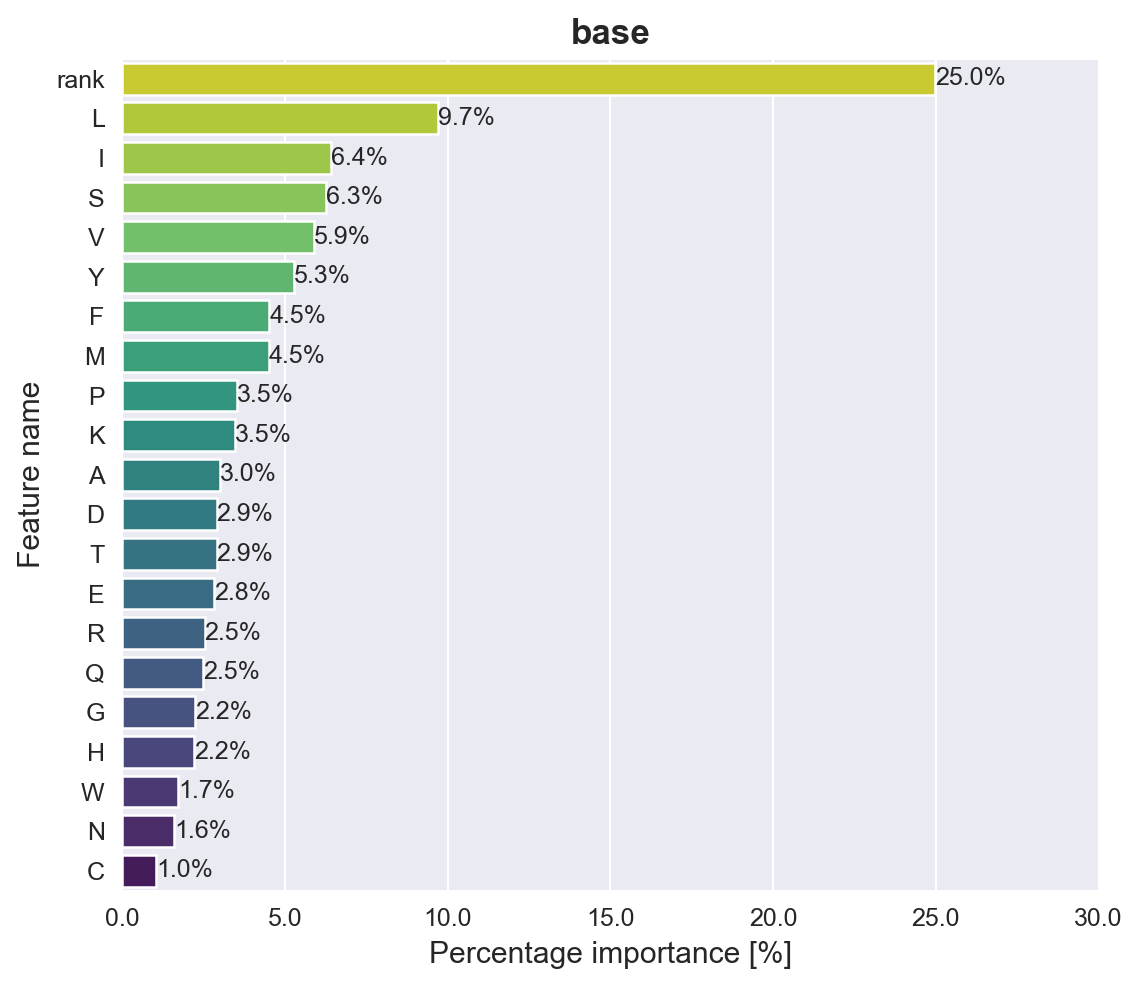

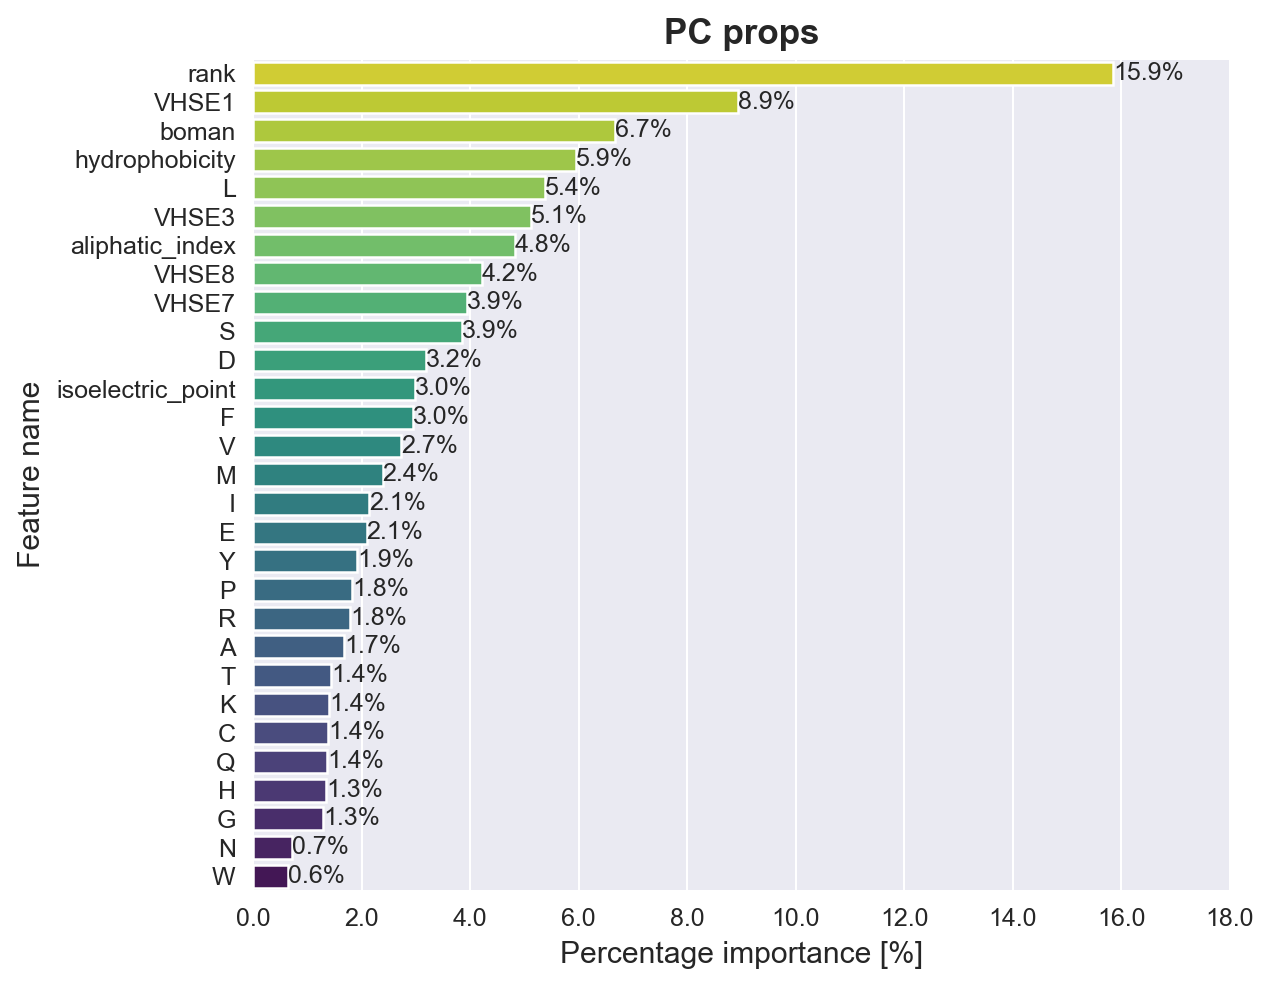

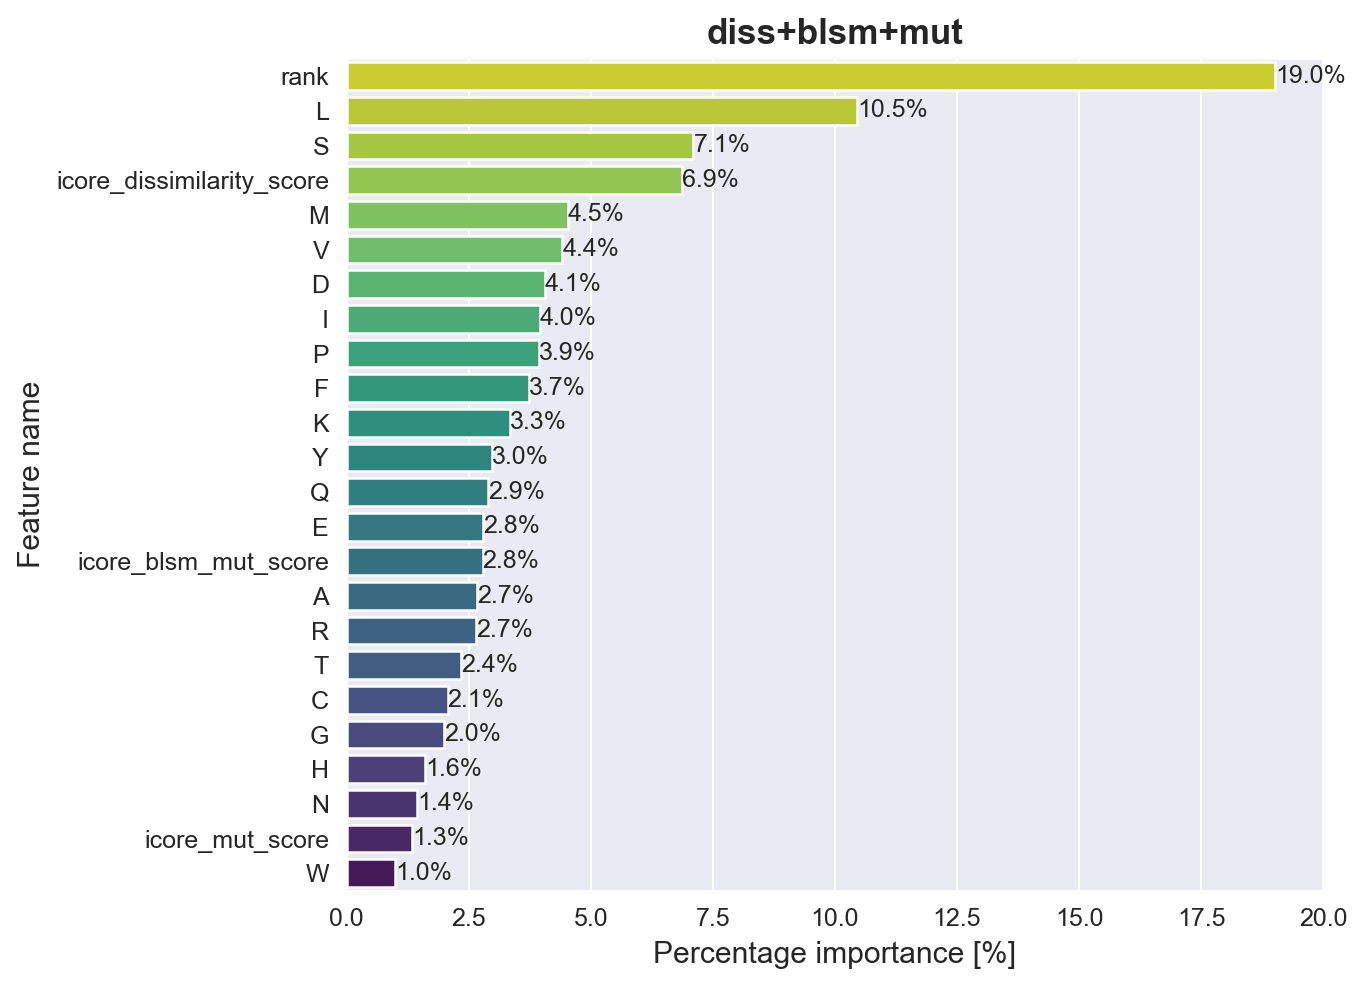

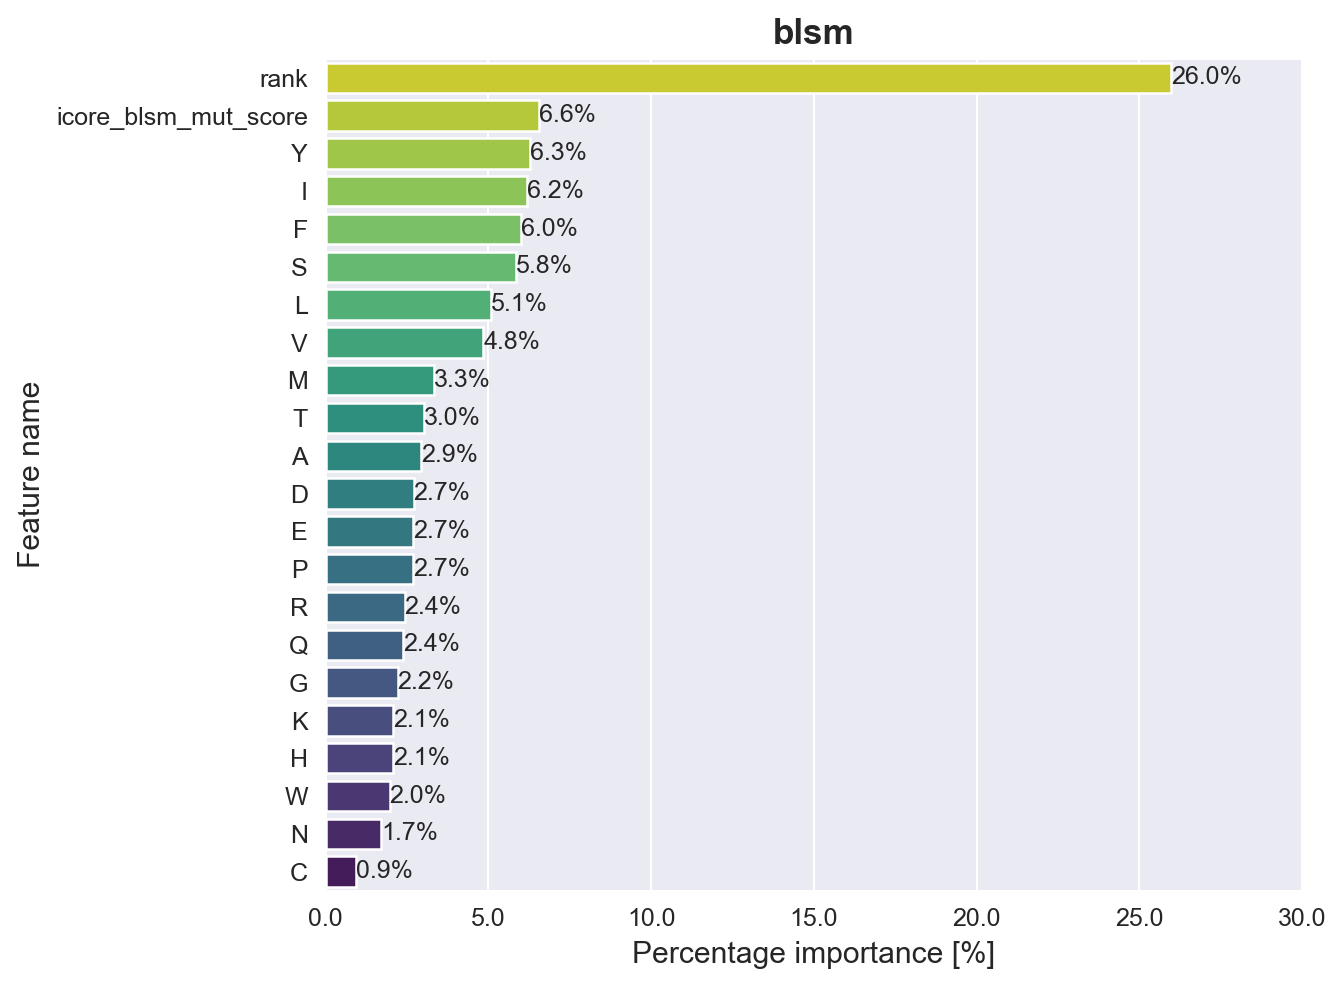

In [77]:
for fi, title in zip([fi_base, fi_aaprops, fi_dissblsm, fi_blsm], ['base', 'PC props', 'diss+blsm+mut', 'blsm']):
    plot_feature_importance(fi.values.flatten(), fi.columns, label_number=True, title =title )

In [78]:
# --> Bootstrap 10k times and report the rocs, aucs, auc01
results = {}
for evalset, dfs in zip(['CEDAR', 'PRIME'], [[cedar_preds_base, cedar_preds_aaprops, cedar_preds_dissblsm, cedar_preds_blsm, cedar_preds_opp_weight,cedar_preds_opp_best ],
                                             [prime_preds_base, prime_preds_aaprops, prime_preds_dissblsm, prime_preds_blsm, prime_preds_opp_weight,prime_preds_opp_best ]]):
    results[evalset]={}
    for key, df in zip(['Base model', 'PC props', 'Diss+BLSM+Mut scores', 'BLSM score', 'Opposite Weight', 'Opposite Best'], dfs):
        results[evalset][key]={}
        if evalset=='PRIME':
            df = df.query('Peptide not in @cp_common_peps')
        boot_df, boot_rocs = bootstrap_eval(df['mean_pred'], df['agg_label'], 10000, 10, True)
        results[evalset][key]['df'] = boot_df
        results[evalset][key]['fpr'] = boot_rocs[0]
        results[evalset][key]['tpr'] = boot_rocs[1]
        results[evalset][key]['lower'] = boot_rocs[2]
        results[evalset][key]['upper'] = boot_rocs[3]
        results[evalset][key]['auc'] = boot_rocs[4]
        results[evalset][key]['auc01'] = boot_rocs[5]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


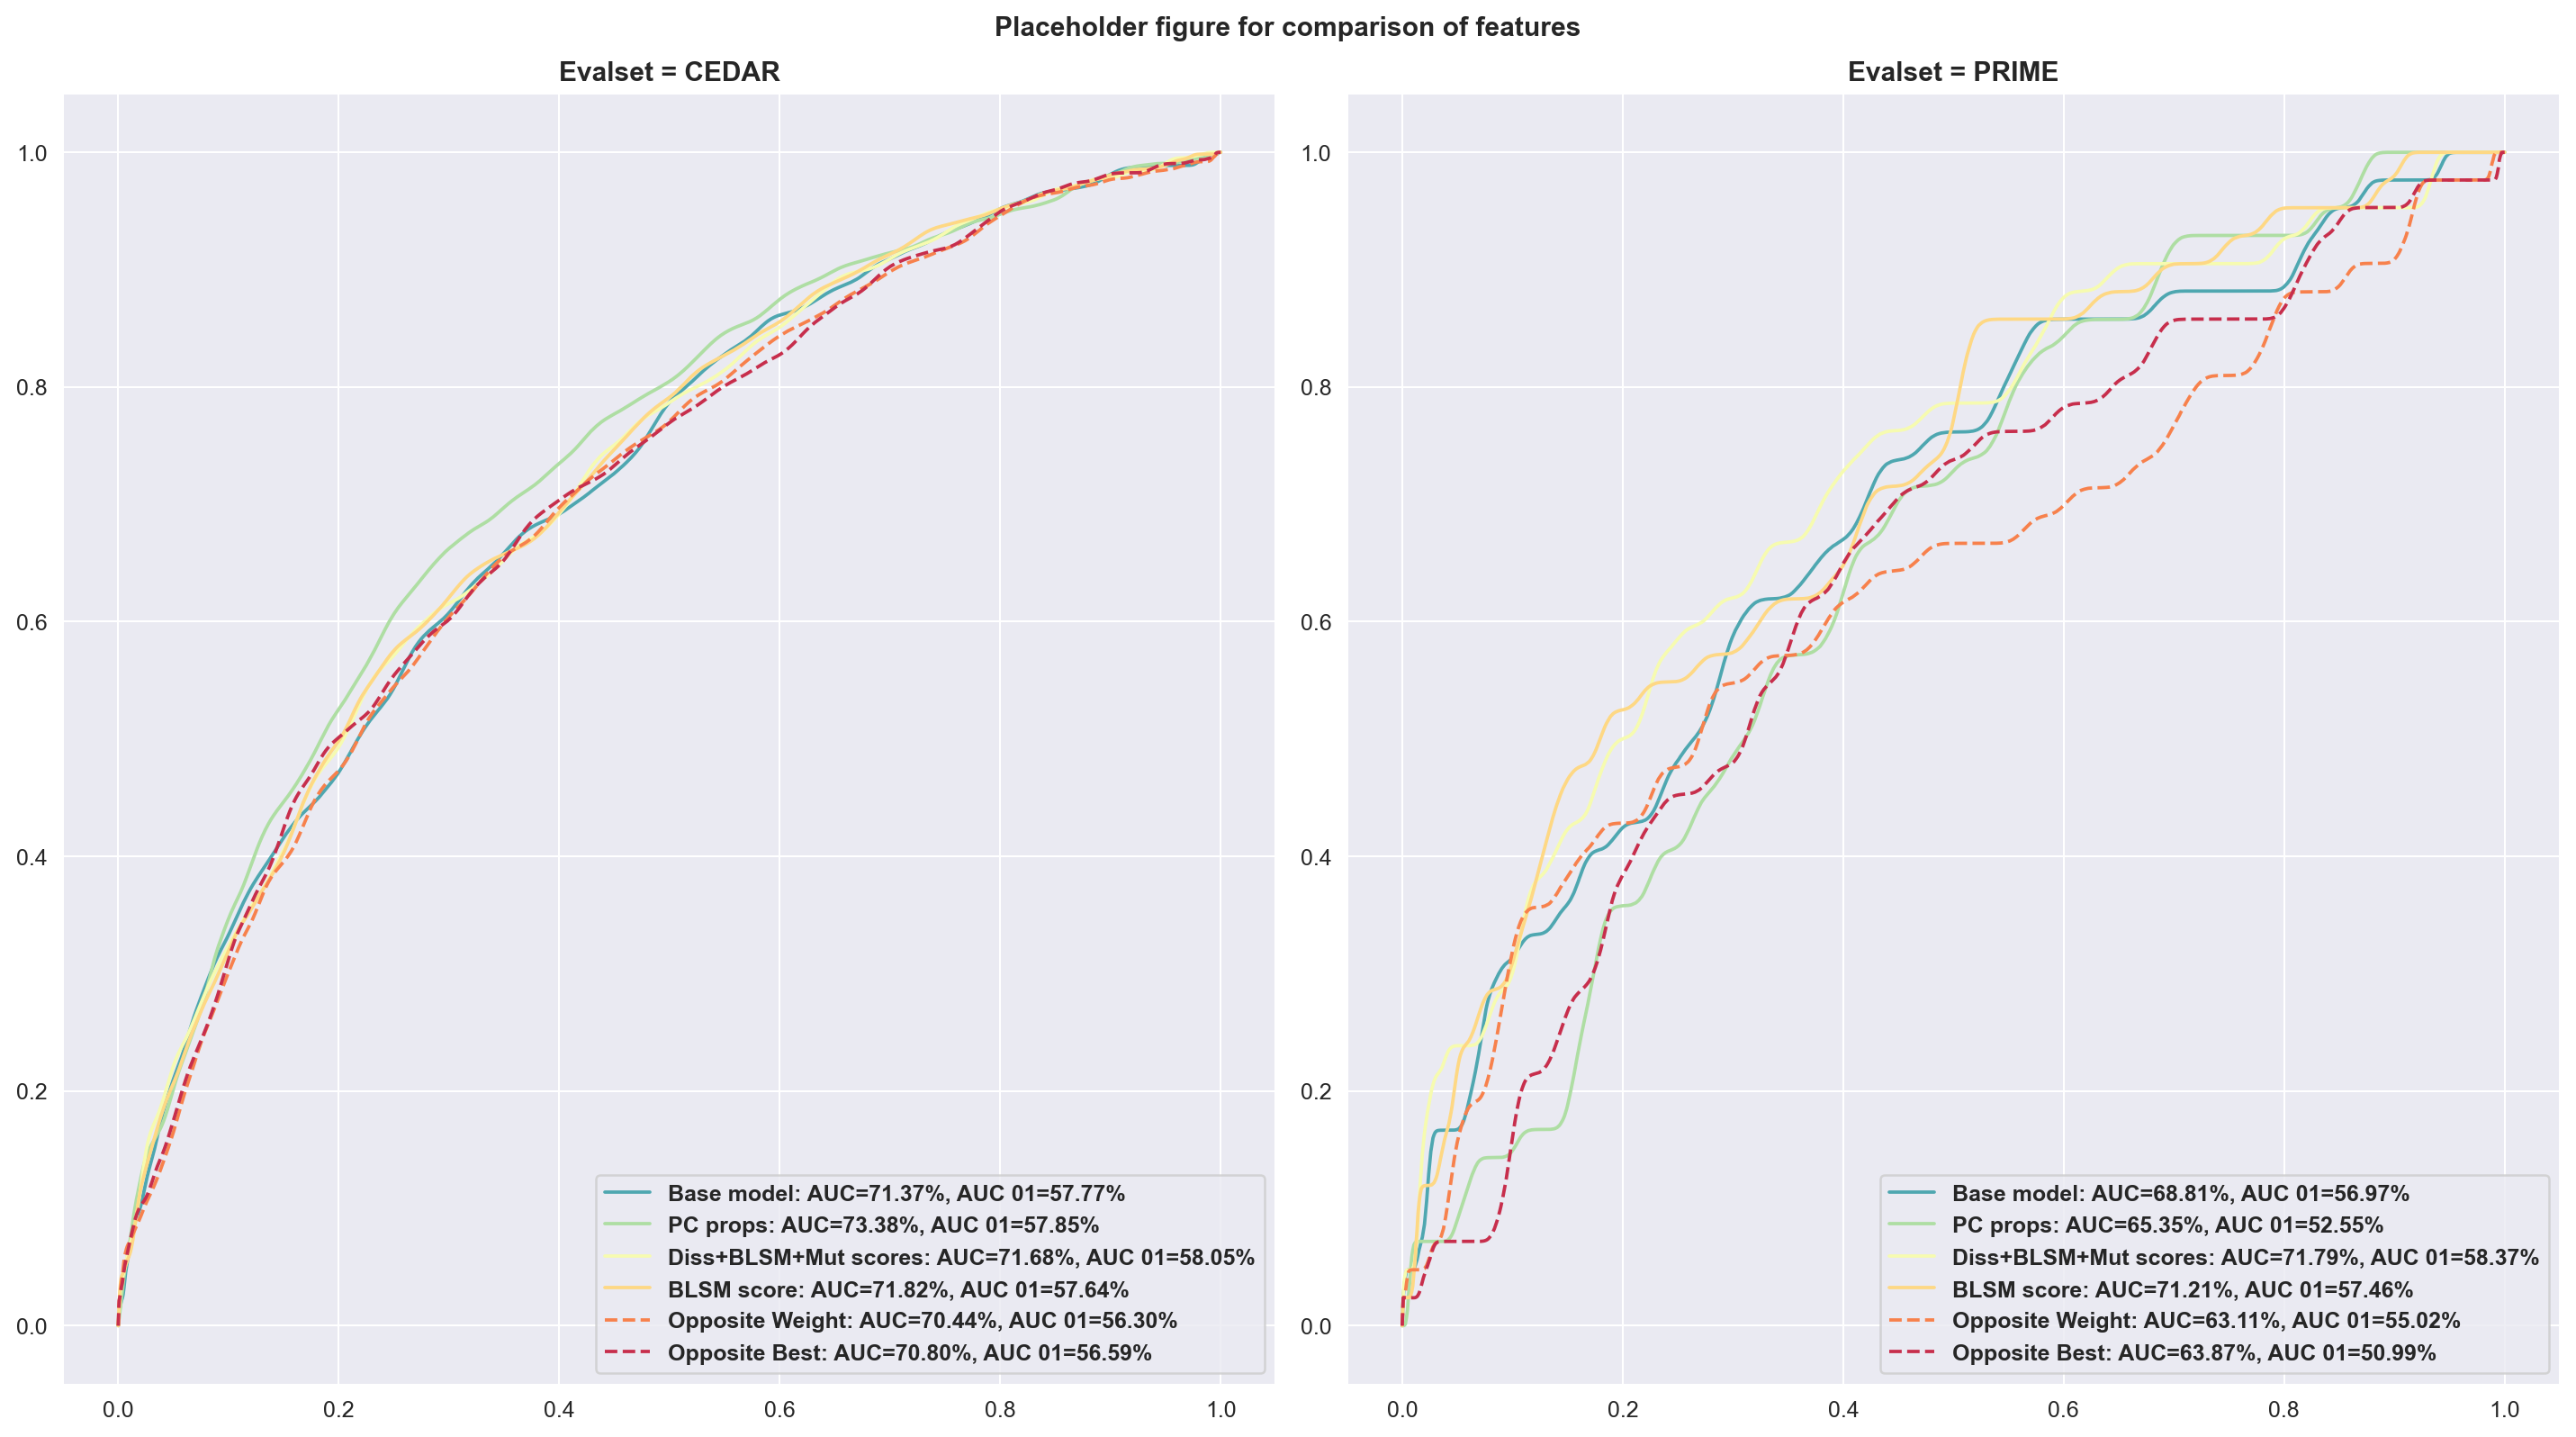

In [944]:
sns.set_palette(NEWPAL)
# sns.set_style('darkgrid')
sns.set_palette(get_palette('Spectral_r', n_colors=6))
f,a = plt.subplots(1,2, figsize=(16, 9))
for evalset, axis in zip(['CEDAR', 'PRIME'], a.ravel()):
    for k,v in results[evalset].items():
        if 'Opposite' in k:
            sns.lineplot(x=v['fpr'], y=v['tpr'], label = f'{k}: AUC={v["auc"]:.2%}, AUC 01={v["auc01"]:.2%}',
                     ax=axis, estimator=None, ls='--')
        else:
            sns.lineplot(x=v['fpr'], y=v['tpr'], label = f'{k}: AUC={v["auc"]:.2%}, AUC 01={v["auc01"]:.2%}', ax=axis, estimator=None)
    axis.set_title(f'Evalset = {evalset}', fontweight='semibold')
    axis.legend(loc='lower right', prop=dict(weight='semibold'))
f.suptitle('Placeholder figure for comparison of features', fontweight='bold')
f.tight_layout()
f.savefig('../../../writing/230131_cedar_paper_1/figures/rocs_features_comparison_basemodel.png',
          bbox_inches='tight', dpi=200)

In [81]:
results['CEDAR'].keys()

dict_keys(['Base model', 'PC props', 'Diss+BLSM+Mut scores', 'BLSM score', 'Opposite Weight', 'Opposite Best'])

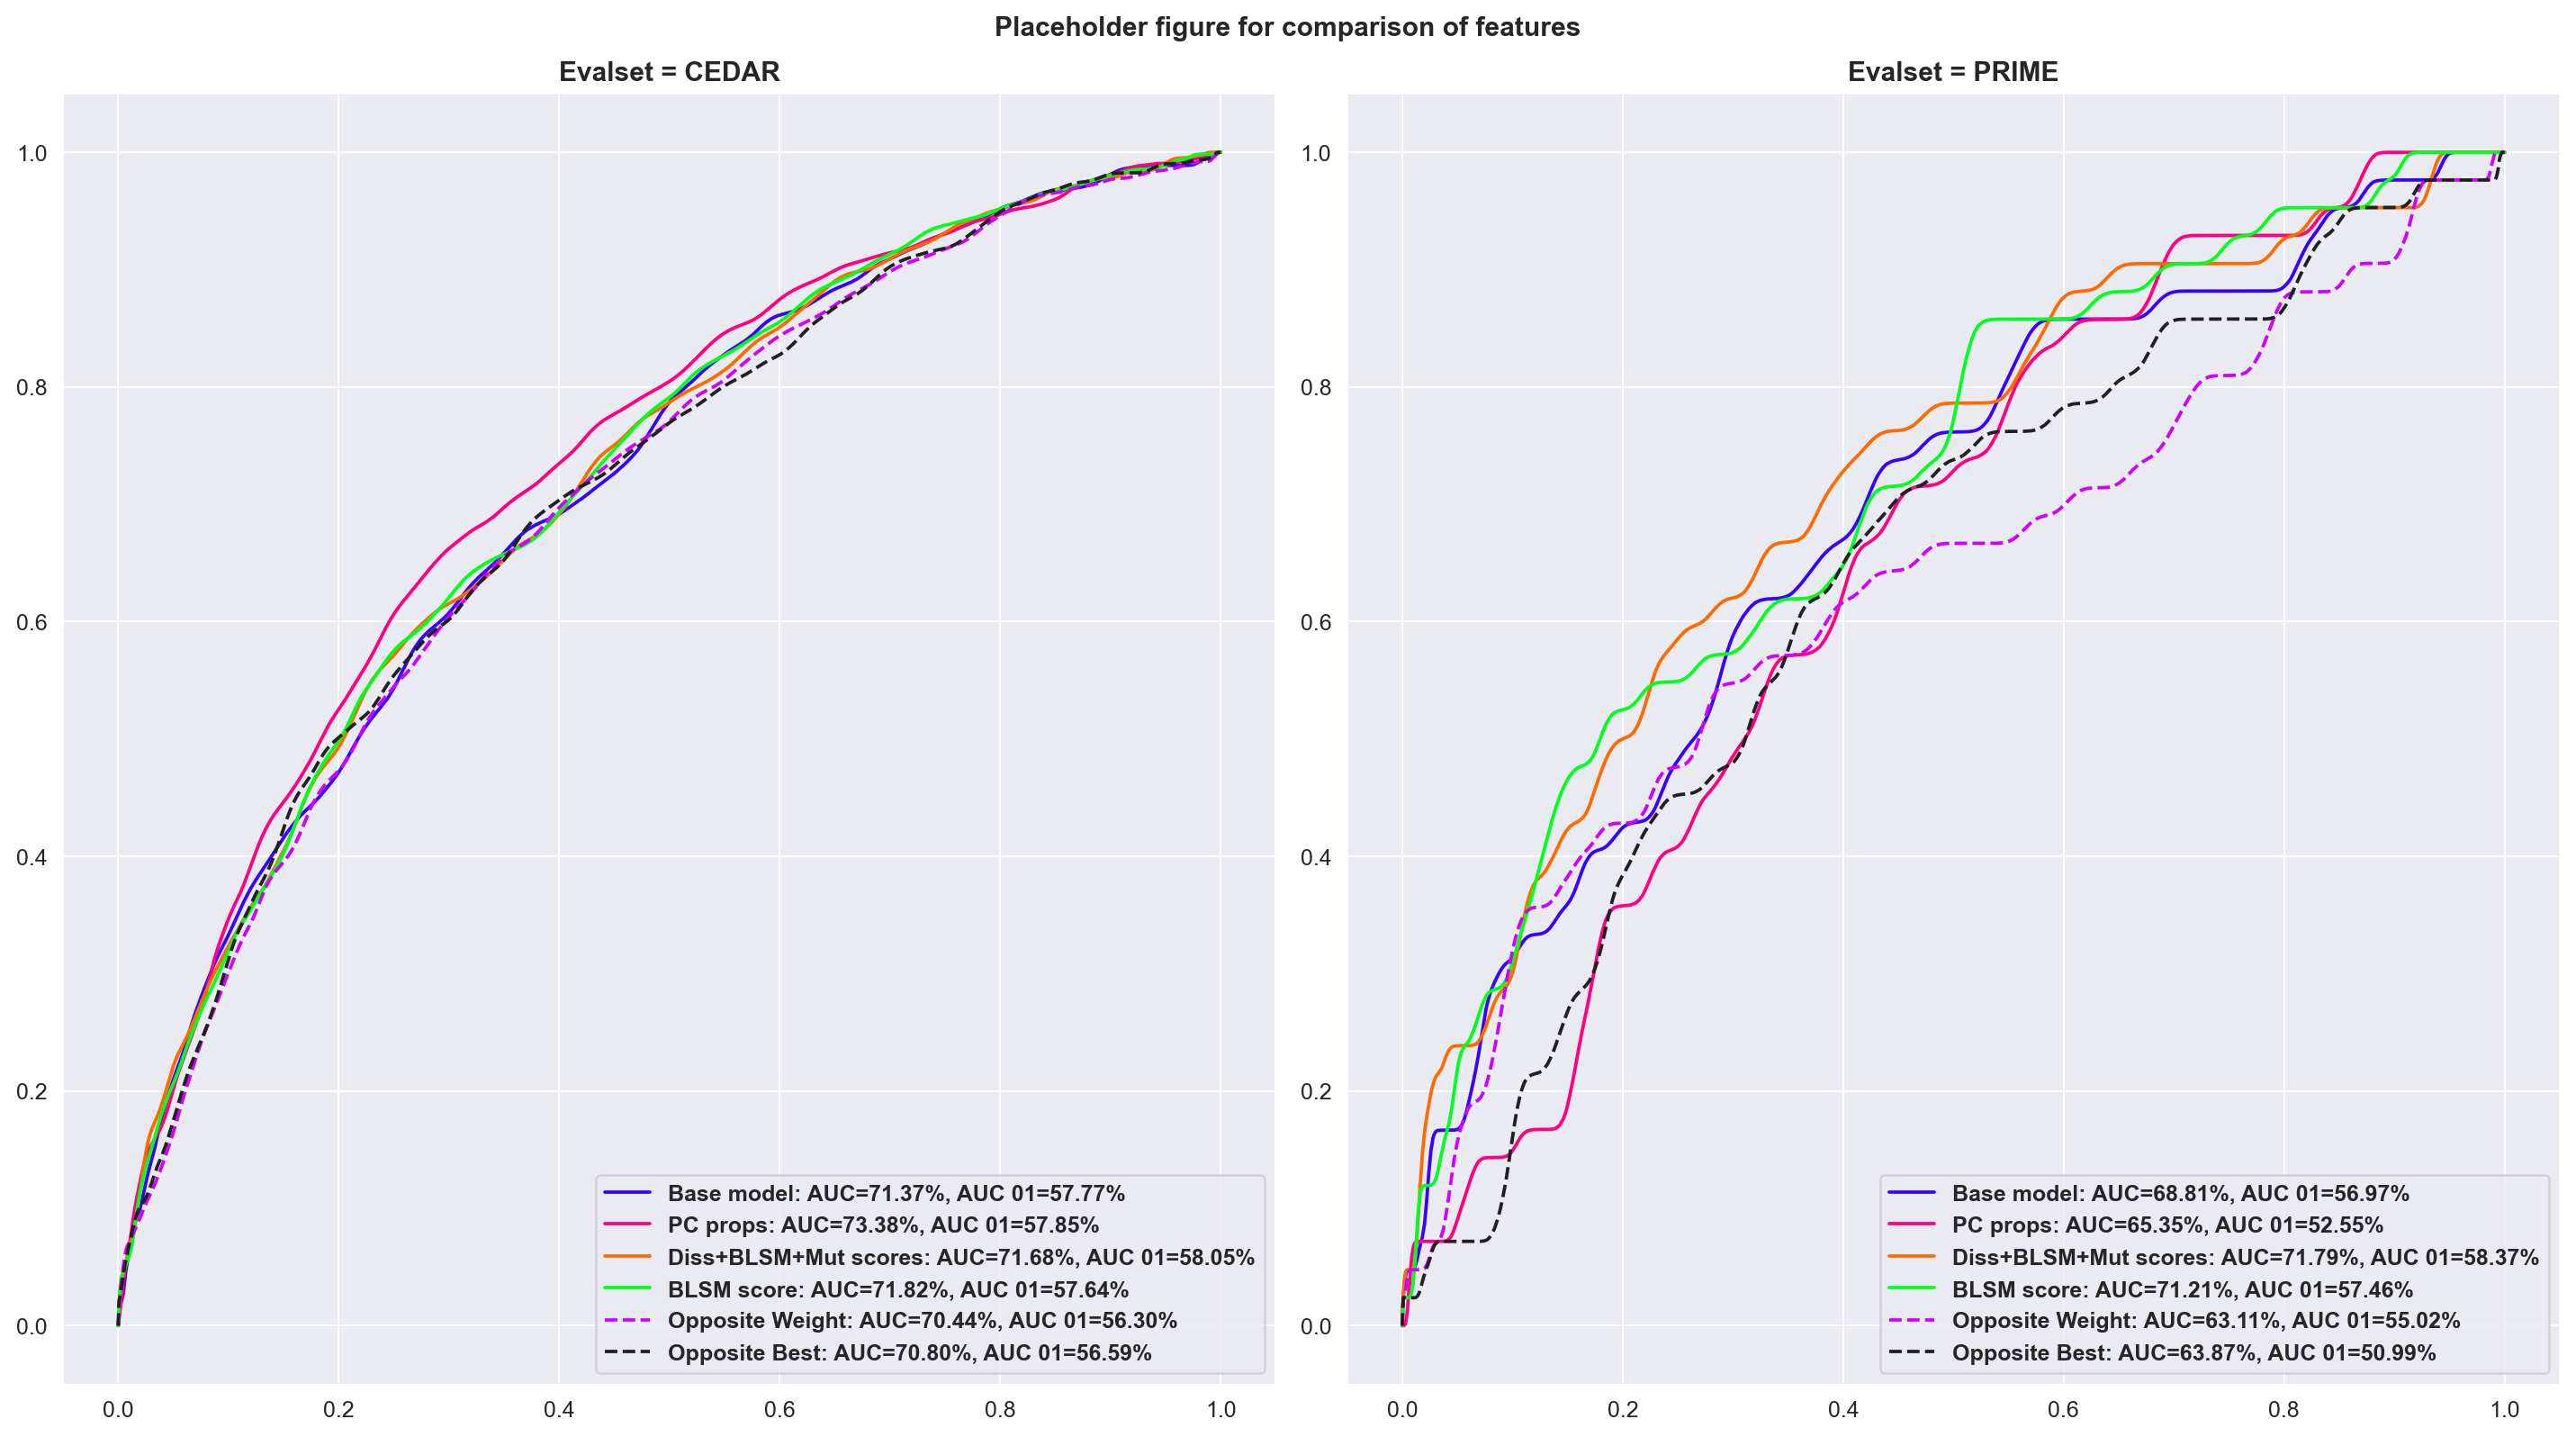

In [971]:
from copy import deepcopy
pal2 = deepcopy(NEWPAL)
pal2[-1] = (.125,.125,.125)

sns.set_palette(pal2)

f,a = plt.subplots(1,2, figsize=(16, 9))
for evalset, axis in zip(['CEDAR', 'PRIME'], a.ravel()):
    for k,v in results[evalset].items():
        if k=='Opposite Weight':
            sns.lineplot(x=v['fpr'], y=v['tpr'], label = f'{k}: AUC={v["auc"]:.2%}, AUC 01={v["auc01"]:.2%}', ax=axis, estimator=None, ls='--')
        elif k=='Opposite Best':
            sns.lineplot(x=v['fpr'], y=v['tpr'], label = f'{k}: AUC={v["auc"]:.2%}, AUC 01={v["auc01"]:.2%}', ax=axis, estimator=None, ls='--')
        else:
            sns.lineplot(x=v['fpr'], y=v['tpr'], label = f'{k}: AUC={v["auc"]:.2%}, AUC 01={v["auc01"]:.2%}', ax=axis, estimator=None)
    axis.set_title(f'Evalset = {evalset}', fontweight='semibold')
    axis.legend(loc='lower right', prop=dict(weight='semibold'))
f.suptitle('Placeholder figure for comparison of features', fontweight='bold')
f.tight_layout()
f.savefig('../../../writing/230131_cedar_paper_1/figures/feats_comparison_rocs.png', dpi=200, bbox_inches='tight')


## Differences P values

In [ ]:
results['CEDAR'].keys()

In [ ]:
from src.bootstrap import get_pval
# CEDAR comparisons:
print('# Comparison between only rank and AA props:')
p1 = get_pval(results['CEDAR']['PC props']['df']['auc'].values, results['CEDAR']['Only %Rank']['df']['auc'].values)
print(p1, 1-p1[0])
print('# Comparison between only rank vs Diss BLSM Mut scores')
p2 = get_pval(results['CEDAR']['Diss+BLSM+Mut scores']['df']['auc'].values, results['CEDAR']['Only %Rank']['df']['auc'].values)
print(p2, 1-p2[0])
print('# Comparison between only rank and BLSM score')
p3 = get_pval(results['CEDAR']['BLSM score']['df']['auc'].values, results['CEDAR']['Only %Rank']['df']['auc'].values)
print(p3, 1-p3[0])
print('# Comparison between only rank and opposite weight')
p4 = get_pval(results['CEDAR']['Opposite Weight']['df']['auc'].values, results['CEDAR']['Only %Rank']['df']['auc'].values)
print(p4, 1-p4[0])
print('# Comparison between only rank and opposite best')
p5 = get_pval(results['CEDAR']['Opposite Best']['df']['auc'].values, results['CEDAR']['Only %Rank']['df']['auc'].values)
print(p5, 1-p5[0])
print('# Finally, comparison between best CEDAR (PC props) vs Diss+BLSM+MUT')
p6 = get_pval(results['CEDAR']['PC props']['df']['auc'].values, results['CEDAR']['Diss+BLSM+Mut scores']['df']['auc'].values)
print(p6, 1-p6[0])
# print(p1,/p2,p3,p4,p5,p6)

In [ ]:
get_pval(results['CEDAR']['PC props']['df']['auc'].values, results['CEDAR']['Opposite Best']['df']['auc'].values)

In [ ]:
# PRIME comparisons:

print('# Comparison between only rank and AA props (Rank better)')
q1 = get_pval(results['PRIME']['Only %Rank']['df']['auc'].values, results['PRIME']['PC props']['df']['auc'].values)
print(q1, 1-q1[0])

print('# Comparison between only rank vs Diss BLSM Mut scores (Rank worse)')
q2 = get_pval(results['PRIME']['Diss+BLSM+Mut scores']['df']['auc'].values, results['PRIME']['Only %Rank']['df']['auc'].values)
print(q2, 1-q2[0])

print('# Comparison between only rank and BLSM score (Rank worse)')
q3 = get_pval(results['PRIME']['BLSM score']['df']['auc'].values, results['PRIME']['Only %Rank']['df']['auc'].values)
print(q3, 1-q3[0])

print('# Comparison between only rank and opposite weight (Rank better)')
q4 = get_pval(results['PRIME']['Only %Rank']['df']['auc'].values, results['PRIME']['Opposite Weight']['df']['auc'].values)
print(q4, 1-q4[0])

print('# Comparison between only rank and opposite best (Rank better)')
q5 = get_pval(results['PRIME']['Only %Rank']['df']['auc'].values, results['PRIME']['Opposite Best']['df']['auc'].values)
print(q5, 1-q5[0])

print('# Finally, comparison between best CEDAR (PC props) vs Diss+BLSM+MUT (PC props worse)')
q6 = get_pval(results['PRIME']['Diss+BLSM+Mut scores']['df']['auc'].values, results['PRIME']['PC props']['df']['auc'].values)
print(q6, 1-q6[0])
# print(q1,q2,q3,q4,q5,q6)


In [ ]:
results['PRIME'].keys()

In [ ]:
get_pval(results['PRIME']['Diss+BLSM+Mut scores']['df']['auc'].values, results['PRIME']['Opposite Best']['df']['auc'].values)

# 4.5: Compromise model 

Remake same plot as in presentation, without Expression features for now

In [84]:
aligned_df = pd.read_csv('../output/230125_aligned_icore_mutscore/total_df.csv')

## finding best models

In [164]:
from src.bootstrap import get_pval, plot_pval, bootstrap_eval

In [87]:
aligned_df_cedar = aligned_df.query('evalset=="CEDAR"').groupby(['encoding','weight','pep_col', 'rank_col','key']).agg(mean_auc_CEDAR=('auc','mean'))
aligned_df_prime = aligned_df.query('evalset=="PRIME"').groupby(['encoding','weight','pep_col', 'rank_col','key']).agg(mean_auc_PRIME=('auc','mean'))
aligned_df_ibel = aligned_df.query('evalset=="IBEL"').groupby(['encoding','weight','pep_col', 'rank_col','key']).agg(mean_auc_IBEL=('auc','mean'))
aligned_df_nepdb = aligned_df.query('evalset=="NEPDB"').groupby(['encoding','weight','pep_col', 'rank_col','key']).agg(mean_auc_NEPDB=('auc','mean'))
gb_agg = pd.concat([aligned_df_cedar, aligned_df_prime, aligned_df_ibel, aligned_df_nepdb], axis=1)
gb_agg['mean_auc_agg'] = .5*(gb_agg['mean_auc_CEDAR']+gb_agg['mean_auc_PRIME'])
gb_agg['mean_auc_std'] = gb_agg.apply(lambda x: np.std([x['mean_auc_CEDAR'],x['mean_auc_PRIME']]), axis=1)
gb_agg['Compromise'] = gb_agg.apply(lambda x: .5*x['mean_auc_CEDAR']+.25 * x['mean_auc_agg'] + .25 * (1-x['mean_auc_std']), axis = 1)
gb_agg.sort_values('Compromise', ascending=False).head(3)

mean_auc_CEDAR  \
encoding weight        pep_col   rank_col    key                                                                  
onehot   None          icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score-...        0.716155   
                                             icore_dissimilarity_score-icore_blsm_mut_score            0.715718   
         Inverted Mask icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score            0.715523   

                                                                                                 mean_auc_PRIME  \
encoding weight        pep_col   rank_col    key                                                                  
onehot   None          icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score-...        0.706413   
                                             icore_dissimilarity_score-icore_blsm_mut_score            0.706836   
         Inverted Mask icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score            0.705889   

                                                                                                 mean_auc_IBEL  \
encoding weight        pep_col   rank_col    key                                                                 
onehot   None          icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score-...       0.598351   
                                             icore_dissimilarity_score-icore_blsm_mut_score           0.590328   
         Inverted Mask icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score           0.584874   

                                                                                                 mean_auc_NEPDB  \
encoding weight        pep_col   rank_col    key                                                                  
onehot   None          icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score-...        0.674389   
                                             icore_dissimilarity_score-icore_blsm_mut_score            0.680309   
         Inverted Mask icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score            0.696149   

                                                                                                 mean_auc_agg  \
encoding weight        pep_col   rank_col    key                                                                
onehot   None          icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score-...      0.711284   
                                             icore_dissimilarity_score-icore_blsm_mut_score          0.711277   
         Inverted Mask icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score          0.710706   

                                                                                                 mean_auc_std  \
encoding weight        pep_col   rank_col    key                                                                
onehot   None          icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score-...      0.004871   
                                             icore_dissimilarity_score-icore_blsm_mut_score          0.004441   
         Inverted Mask icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score          0.004817   

                                                                                                 Compromise  
encoding weight        pep_col   rank_col    key                                                             
onehot   None          icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score-...    0.784680  
                                             icore_dissimilarity_score-icore_blsm_mut_score        0.784568  
         Inverted Mask icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score        0.784234

In [163]:
def get_fn(encoding, weight, pep_col, rank_col, key):
    fn = f"cedar_{encoding}_{weight.replace(' ','-')}_{pep_col}_{rank_col}_{key}"
    return fn
def get_fi(encoding, weight, pep_col, rank_col, key, pdir='../output/230125_aligned_icore_mutscore/raw/'):
    fn = f"featimps_{get_fn(encoding, weight, pep_col, rank_col, key)}.csv".replace('BL62LO','blosum').replace('BL62FREQ','blosum')
    return pd.read_csv(f'{pdir}{fn}')
def get_pred(evalset, encoding, weight, pep_col, rank_col, key, pdir='../output/230125_aligned_icore_mutscore/raw/'):
    fn = f"{evalset}_preds_{get_fn(encoding, weight, pep_col, rank_col, key)}.csv"
    return pd.read_csv(f'{pdir}{fn}')

In [89]:
best_models = {}
for col in filter(lambda x: x!='mean_auc_agg' and x !='mean_auc_std' and 'IBEL' not in x and 'NEPDB' not in x, gb_agg.columns):
    print(col)
    display(gb_agg.sort_values(col, ascending=False).head(3))
    c = col.replace('mean_auc_', 'Best for ')
    best_models[c] = {}
    best_models[c]['cdt'] = gb_agg.reset_index().query('not key.str.contains("VHSE8-")').sort_values(col, ascending=False).head(1)[cdt_cols].squeeze().to_dict()
best_models['Base model'] = {}
best_models['Base model']['cdt'] = {'encoding':'onehot', 'weight':'None','pep_col':'icore_mut', 'rank_col':'EL_rank_mut', 'key':'only_rank'}


mean_auc_CEDAR


mean_auc_CEDAR  \
encoding weight           pep_col   rank_col    key                                                                  
onehot   Inverted Shannon icore_mut EL_rank_mut aliphatic_index-boman-hydrophobicity-isoelectri...        0.734538   
                                                aa_props                                                  0.733766   
                                                aliphatic_index-boman-hydrophobicity-isoelectri...        0.733566   

                                                                                                    mean_auc_PRIME  \
encoding weight           pep_col   rank_col    key                                                                  
onehot   Inverted Shannon icore_mut EL_rank_mut aliphatic_index-boman-hydrophobicity-isoelectri...        0.642276   
                                                aa_props                                                  0.638693   
                                                aliphatic_index-boman-hydrophobicity-isoelectri...        0.647921   

                                                                                                    mean_auc_IBEL  \
encoding weight           pep_col   rank_col    key                                                                 
onehot   Inverted Shannon icore_mut EL_rank_mut aliphatic_index-boman-hydrophobicity-isoelectri...       0.579488   
                                                aa_props                                                 0.565024   
                                                aliphatic_index-boman-hydrophobicity-isoelectri...       0.558486   

                                                                                                    mean_auc_NEPDB  \
encoding weight           pep_col   rank_col    key                                                                  
onehot   Inverted Shannon icore_mut EL_rank_mut aliphatic_index-boman-hydrophobicity-isoelectri...        0.624505   
                                                aa_props                                                  0.640115   
                                                aliphatic_index-boman-hydrophobicity-isoelectri...        0.651262   

                                                                                                    mean_auc_agg  \
encoding weight           pep_col   rank_col    key                                                                
onehot   Inverted Shannon icore_mut EL_rank_mut aliphatic_index-boman-hydrophobicity-isoelectri...      0.688407   
                                                aa_props                                                0.686230   
                                                aliphatic_index-boman-hydrophobicity-isoelectri...      0.690744   

                                                                                                    mean_auc_std  \
encoding weight           pep_col   rank_col    key                                                                
onehot   Inverted Shannon icore_mut EL_rank_mut aliphatic_index-boman-hydrophobicity-isoelectri...      0.046131   
                                                aa_props                                                0.047537   
                                                aliphatic_index-boman-hydrophobicity-isoelectri...      0.042823   

                                                                                                    Compromise  
encoding weight           pep_col   rank_col    key                                                             
onehot   Inverted Shannon icore_mut EL_rank_mut aliphatic_index-boman-hydrophobicity-isoelectri...    0.777838  
                                                aa_props                                              0.776556  
                                                aliphatic_index-boman-hydrophobicity-isoelectri...    0.778763

mean_auc_PRIME


mean_auc_CEDAR  \
encoding weight pep_col   rank_col    key                                                                  
onehot   Mask   icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score            0.707952   
                                      icore_dissimilarity_score-icore_blsm_mut_score-...        0.707998   
                                      icore_dissimilarity_score                                 0.705416   

                                                                                          mean_auc_PRIME  \
encoding weight pep_col   rank_col    key                                                                  
onehot   Mask   icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score            0.719480   
                                      icore_dissimilarity_score-icore_blsm_mut_score-...        0.717929   
                                      icore_dissimilarity_score                                 0.712240   

                                                                                          mean_auc_IBEL  \
encoding weight pep_col   rank_col    key                                                                 
onehot   Mask   icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score           0.571522   
                                      icore_dissimilarity_score-icore_blsm_mut_score-...       0.572276   
                                      icore_dissimilarity_score                                0.548696   

                                                                                          mean_auc_NEPDB  \
encoding weight pep_col   rank_col    key                                                                  
onehot   Mask   icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score            0.694717   
                                      icore_dissimilarity_score-icore_blsm_mut_score-...        0.689075   
                                      icore_dissimilarity_score                                 0.698117   

                                                                                          mean_auc_agg  \
encoding weight pep_col   rank_col    key                                                                
onehot   Mask   icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score          0.713716   
                                      icore_dissimilarity_score-icore_blsm_mut_score-...      0.712964   
                                      icore_dissimilarity_score                               0.708828   

                                                                                          mean_auc_std  \
encoding weight pep_col   rank_col    key                                                                
onehot   Mask   icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score          0.005764   
                                      icore_dissimilarity_score-icore_blsm_mut_score-...      0.004965   
                                      icore_dissimilarity_score                               0.003412   

                                                                                          Compromise  
encoding weight pep_col   rank_col    key                                                             
onehot   Mask   icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score        0.780964  
                                      icore_dissimilarity_score-icore_blsm_mut_score-...    0.780999  
                                      icore_dissimilarity_score                             0.779062

Compromise


mean_auc_CEDAR  \
encoding weight        pep_col   rank_col    key                                                                  
onehot   None          icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score-...        0.716155   
                                             icore_dissimilarity_score-icore_blsm_mut_score            0.715718   
         Inverted Mask icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score            0.715523   

                                                                                                 mean_auc_PRIME  \
encoding weight        pep_col   rank_col    key                                                                  
onehot   None          icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score-...        0.706413   
                                             icore_dissimilarity_score-icore_blsm_mut_score            0.706836   
         Inverted Mask icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score            0.705889   

                                                                                                 mean_auc_IBEL  \
encoding weight        pep_col   rank_col    key                                                                 
onehot   None          icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score-...       0.598351   
                                             icore_dissimilarity_score-icore_blsm_mut_score           0.590328   
         Inverted Mask icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score           0.584874   

                                                                                                 mean_auc_NEPDB  \
encoding weight        pep_col   rank_col    key                                                                  
onehot   None          icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score-...        0.674389   
                                             icore_dissimilarity_score-icore_blsm_mut_score            0.680309   
         Inverted Mask icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score            0.696149   

                                                                                                 mean_auc_agg  \
encoding weight        pep_col   rank_col    key                                                                
onehot   None          icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score-...      0.711284   
                                             icore_dissimilarity_score-icore_blsm_mut_score          0.711277   
         Inverted Mask icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score          0.710706   

                                                                                                 mean_auc_std  \
encoding weight        pep_col   rank_col    key                                                                
onehot   None          icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score-...      0.004871   
                                             icore_dissimilarity_score-icore_blsm_mut_score          0.004441   
         Inverted Mask icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score          0.004817   

                                                                                                 Compromise  
encoding weight        pep_col   rank_col    key                                                             
onehot   None          icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score-...    0.784680  
                                             icore_dissimilarity_score-icore_blsm_mut_score        0.784568  
         Inverted Mask icore_mut EL_rank_mut icore_dissimilarity_score-icore_blsm_mut_score        0.784234

In [90]:
for k in best_models:
    print(k, best_models[k]['cdt'])

Best for CEDAR {'encoding': 'onehot', 'weight': 'Inverted Shannon', 'pep_col': 'icore_mut', 'rank_col': 'EL_rank_mut', 'key': 'aa_props'}
Best for PRIME {'encoding': 'onehot', 'weight': 'Mask', 'pep_col': 'icore_mut', 'rank_col': 'EL_rank_mut', 'key': 'icore_dissimilarity_score-icore_blsm_mut_score'}
Compromise {'encoding': 'onehot', 'weight': 'None', 'pep_col': 'icore_mut', 'rank_col': 'EL_rank_mut', 'key': 'icore_dissimilarity_score-icore_blsm_mut_score-icore_mut_score'}
Base model {'encoding': 'onehot', 'weight': 'None', 'pep_col': 'icore_mut', 'rank_col': 'EL_rank_mut', 'key': 'only_rank'}


## Get preds + ROC

Need to agree on filtering: 

For CEDAR, check differences between removing common peps and not on performance of bestCEDAR vs general

In [91]:
prime_nnalign_redo = pd.read_csv('../../nnalign_cedar/NNALIGN_evalPRIME_with_BaselineCEDAR_model.txt', sep='\t')
prime_related_baseline=prime_related_baseline.merge(prime_nnalign_redo.rename(columns={'Prediction':'NNAlign_score'})[['Peptide','NNAlign_score']], 
                             left_index=True, right_index=True)
prime_related_baseline.drop(columns=['nnalign_score'],inplace=True)
                             #left_on='Peptide', right_on='Peptide')
prime_related_baseline.rename(columns={'Peptide_x':'Peptide'}, inplace=True)
prime_related_baseline.drop(columns=['Peptide_y'], inplace=True)
prime_related_baseline.rename(columns={'NNAlign_score':'nnalign_score'}, inplace=True)


In [ ]:
from sklearn.metrics import roc_curve
sns.set_palette(HSV)
for evalset,baseline in zip(['cedar', 'prime'],
                            [cedar_related_baseline, prime_related_baseline]):
    f,a = plt.subplots(1,1,figsize=(10,10))
    query = 'Peptide not in @cp_common_peps and Peptide not in @ommited' if (evalset =='cedar' or evalset=='prime') \
            else 'Peptide not in @cpeps and Peptide not in @ppeps and Peptide not in @ommited'
    
    for k in best_models:
        print(k)
        best_models[k][evalset] = get_pred(evalset, **best_models[k]['cdt'])
        pcol = 'pred' if 'pred' in best_models[k][evalset].columns else 'mean_pred'
        tmp = best_models[k][evalset].query(query)
        auc = roc_auc_score(tmp['agg_label'].astype(int), tmp[pcol].values)
        auc01 = roc_auc_score(tmp['agg_label'].astype(int), tmp[pcol].values, max_fpr=0.1)
        fpr, tpr, _ = roc_curve(tmp['agg_label'].astype(int), tmp[pcol].values)
        sns.lineplot(x=fpr, y=tpr, label = f'{k}: AUC={auc:.2%}, AUC01={auc01:.2%}', ax=a)
    
    bs = baseline.query(query + ' and Peptide in @tmp.Peptide.values')
    plot_related_baseline_roc(a, bs, auc01=True)
    a.legend(loc='lower right', prop=dict(weight='semibold'))
    a.set_title(f'Filtered Evalset; Evalset={evalset}, '\
                f'npos={len(bs.query("agg_label==1"))}, '\
                f'nneg={len(bs.query("agg_label==0"))}', fontweight='semibold')
    a.set_xlabel('FPR')
    a.set_ylabel('TPR')
    # f.savefig(f'../../../meetings/slides/2301XX_CEDAR_meeting_update/filtered_evalset_{evalset}_vs_baselines_rocs.png',
    #           bbox_inches='tight', dpi=200)

## rebootstrap + Boxplot

In [ ]:
from src.bootstrap import bootstrap_eval
# Here, for each of the evalsets and conditions, 
# gets pvalues with the best cdt vs the rests
# Rebootstrap the AUCs
rebootstrapped_best = {}


for evalname, evalset in zip(['cedar', 'prime'], [cedar_related_baseline, prime_related_baseline]):
    tmp = []
    for k in best_models:
        pcol = 'pred' if 'pred' in best_models[k][evalname].columns else 'mean_pred'
        scores = best_models[k][evalname][pcol].values
        labels = best_models[k][evalname]['agg_label'].astype(int)
        bootstrapped_df = bootstrap_eval(scores, labels, n_rounds=10000, n_jobs=8)[0].assign(evalset=evalname, key=k)
        tmp.append(bootstrapped_df)
    peps=best_models[k][evalname].Peptide.values
    evalset_copy = evalset.query('Peptide in @peps')
    # Bootstrap PRIME and NN align as baseline on the boxplots?    
    for baseline in [x for x in cedar_related_baseline.columns if 'score' in x.lower()]:
        
        scores = evalset_copy[baseline].values
        labels = evalset_copy['agg_label'].astype(int).values
        bootstrapped_baseline = bootstrap_eval(scores, labels, n_rounds=10000, n_jobs=8)[0].assign(evalset=evalname, key=baseline)
        tmp.append(bootstrapped_baseline)
    rebootstrapped_best[evalname] = pd.concat(tmp)

In [162]:
def rename_key(key):
    if "Best for" in key:
        return f"Optimal {key.replace('Best for ', '')} model"
    if key == "Compromise":
        return "General model"
    else:
        return key
for evalset in rebootstrapped_best:
    rebootstrapped_best[evalset]['key']=rebootstrapped_best[evalset]['key'].apply(lambda x : x.replace('_score', ''))
    rebootstrapped_best[evalset]['key']=rebootstrapped_best[evalset]['key'].apply(rename_key)
sorted_order = rebootstrapped_best[evalset].groupby('key').agg(mean_auc=('auc','mean'))\
                                               .sort_values('mean_auc', ascending=False).index.str.replace('agg_selection', 'Compromise_model').tolist()



NameError: name 'rebootstrapped_best' is not defined

In [ ]:
from src.bootstrap import get_pval, plot_pval
# Redo the plot but keeping the order and redo not all the p-values

f,a = plt.subplots(1,2, figsize=(14.5,8), sharey=True)
order = ['Optimal CEDAR model', 'Optimal PRIME model', 'General model', 'Base model', 'NNAlign', 'PRIME']
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
color_order = {k:v for k,v in zip(order, NEWPAL)}
for evalset,axis in zip(rebootstrapped_best, a):
    sorted_order = rebootstrapped_best[evalset].groupby('key').agg(mean_auc=('auc','mean'))\
                                               .sort_values('mean_auc', ascending=False).index.str.replace('nnalign', 'NNAlign').tolist()
    # Sort order by decreasing performance
    tmp = rebootstrapped_best[evalset].copy()
    tmp['key'] = tmp['key'].replace('nnalign', 'NNAlign')
    sns.boxplot(data = tmp , x = 'key', y = 'auc', width=.65, ax=axis, 
                palette = color_order, order = order, hue = 'key', dodge=False)
    # Add median and remove legend / ylabel
    add_median_labels(axis, fmt = '.1%');
    axis.legend([], frameon=False);
    axis.set_ylabel('');
    axis.set_xlabel('');
    # axis.set_xticklabels(axis.get_xticklabels(), fontweight = 'semibold', fontsize=13, rotation=45, ha='center')
    axis.set_xticklabels([])
    axis.set_title(f'Performance of various models on {evalset.upper()} ', fontweight='semibold')
    # Comparing with aucs_base, which is the best one
    best = tmp.groupby('key').agg(mean_auc=('auc','mean')).idxmax().item()
    aucs_base = tmp.query('key == @best').auc.values
    h, h0 = 0.01, 0.02
    x0 = order.index(best)
    comp_list = reversed([x for x in order if x != best]) if x0 >= 4 else [x for x in order if x != best]
    for i, comparison in enumerate(comp_list):
        x1 = order.index(comparison)
        aucs_comp = tmp.query('key == @comparison').auc.values
        pval, sig = get_pval(aucs_base, aucs_comp)
        # print(evalset,best, 'here',comparison, round(pval,3))
        plot_pval(axis, pval, sig, x0, x1, y = max(aucs_base)+h, h=h0, color='k')
        h += 2 * h0
        
    # Comparing "agg_selection" with the lower 2
    new_order = [x for x in order if x != best and x != 'General model']
    new_order = ['General model'] + new_order
    aucs_agg = tmp.query('key == "General model"').auc.values
    x0 = order.index('General model')
    h += 2*h0
    for i, comparison in enumerate(new_order[1:]):
        x1 = order.index(comparison)
        aucs_comp = tmp.query('key == @comparison').auc.values
        pval, sig = get_pval(aucs_base, aucs_comp)
        print(comparison, f'{pval:.3e}')
        # print(evalset,best, 'there',comparison, round(pval,3))
        plot_pval(axis, pval, sig, x0, x1, y = max(aucs_agg)+h, h=h0, color = 'b')
        h += 2*h0

a[0].set_ylabel('AUC', fontweight='semibold', fontsize=13);

h, l = a[1].get_legend_handles_labels()
bbox = (0, 0.59)
a[1].legend(h, l, bbox_to_anchor = bbox,prop=dict(weight='semibold', size = 14));
f.tight_layout()
f.savefig('../../../writing/230131_cedar_paper_1/figures/redone_best_models_compromise.png', bbox_inches='tight', dpi=200)

In [ ]:
from src.bootstrap import bootstrap_eval
# Here, for each of the evalsets and conditions, 
# gets pvalues with the best cdt vs the rests
# Rebootstrap the AUCs
rebootstrapped_best = {}


for evalname, evalset in zip(['cedar', 'prime'], [cedar_related_baseline, prime_related_baseline]):
    tmp = []
    for k in best_models:
        pcol = 'pred' if 'pred' in best_models[k][evalname].columns else 'mean_pred'
        scores = best_models[k][evalname].query('Peptide not in @cp_common_peps')[pcol].values
        labels = best_models[k][evalname].query('Peptide not in @cp_common_peps')['agg_label'].astype(int).values
        bootstrapped_df = bootstrap_eval(scores, labels, n_rounds=10000, n_jobs=8)[0].assign(evalset=evalname, key=k)
        tmp.append(bootstrapped_df)
    peps=best_models[k][evalname].Peptide.values
    evalset_copy = evalset.query('Peptide not in @cp_common_peps and Peptide in @peps')
    # Bootstrap PRIME and NN align as baseline on the boxplots?    
    for baseline in [x for x in cedar_related_baseline.columns if 'score' in x.lower()]:
        scores = evalset_copy[baseline].values
        labels = evalset_copy['agg_label'].astype(int).values
        bootstrapped_baseline = bootstrap_eval(scores, labels, n_rounds=10000, n_jobs=8)[0].assign(evalset=evalname, key=baseline)
        tmp.append(bootstrapped_baseline)
    rebootstrapped_best[evalname] = pd.concat(tmp)

In [ ]:
def rename_key(key):
    if "Best for" in key:
        return f"Optimal {key.replace('Best for ', '')} model"
    if key == "Compromise":
        return "General model"
    else:
        return key
for evalset in rebootstrapped_best:
    rebootstrapped_best[evalset]['key']=rebootstrapped_best[evalset]['key'].apply(lambda x : x.replace('_score', ''))
    rebootstrapped_best[evalset]['key']=rebootstrapped_best[evalset]['key'].apply(rename_key)
sorted_order = rebootstrapped_best[evalset].groupby('key').agg(mean_auc=('auc','mean'))\
                                               .sort_values('mean_auc', ascending=False).index.str.replace('agg_selection', 'Compromise_model').tolist()



In [ ]:
from src.bootstrap import get_pval, plot_pval
# Redo the plot but keeping the order and redo not all the p-values

f,a = plt.subplots(1,2, figsize=(14.5,8), sharey=True)
order = ['Optimal CEDAR model', 'Optimal PRIME model', 'General model', 'NNAlign', 'PRIME']
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
color_order = {k:v for k,v in zip(order, NEWPAL)}
for evalset,axis in zip(rebootstrapped_best, a):
    sorted_order = rebootstrapped_best[evalset].groupby('key').agg(mean_auc=('auc','mean'))\
                                               .sort_values('mean_auc', ascending=False).index.str.replace('nnalign', 'NNAlign').tolist()
    # Sort order by decreasing performance
    tmp = rebootstrapped_best[evalset].copy()
    tmp['key'] = tmp['key'].replace('nnalign', 'NNAlign')
    sns.boxplot(data = tmp , x = 'key', y = 'auc', width=.65, ax=axis, 
                palette = color_order, order = order, hue = 'key', dodge=False)
    # Add median and remove legend / ylabel
    add_median_labels(axis, fmt = '.1%');
    axis.legend([], frameon=False);
    axis.set_ylabel('');
    axis.set_xlabel('');
    # axis.set_xticklabels(axis.get_xticklabels(), fontweight = 'semibold', fontsize=13, rotation=45, ha='center')
    axis.set_xticklabels([])
    axis.set_title(f'Performance of various models on {evalset.upper()} ', fontweight='semibold')
    # Comparing with aucs_base, which is the best one
    best = tmp.groupby('key').agg(mean_auc=('auc','mean')).idxmax().item()
    aucs_base = tmp.query('key == @best').auc.values
    h, h0 = 0.01, 0.02
    x0 = order.index(best)
    comp_list = reversed([x for x in order if x != best]) if x0 >= 4 else [x for x in order if x != best]
    for i, comparison in enumerate(comp_list):
        x1 = order.index(comparison)
        aucs_comp = tmp.query('key == @comparison').auc.values
        pval, sig = get_pval(aucs_base, aucs_comp)
        # print(evalset,best, 'here',comparison, round(pval,3))
        plot_pval(axis, pval, sig, x0, x1, y = max(aucs_base)+h, h=h0, color='k')
        h += 2 * h0
        
    # Comparing "agg_selection" with the lower 2
    new_order = [x for x in order if x != best and x != 'General model']
    new_order = ['General model'] + new_order
    aucs_agg = tmp.query('key == "General model"').auc.values
    x0 = order.index('General model')
    h += 2*h0
    for i, comparison in enumerate(new_order[1:]):
        x1 = order.index(comparison)
        aucs_comp = tmp.query('key == @comparison').auc.values
        pval, sig = get_pval(aucs_base, aucs_comp)
        # print(evalset,best, 'there',comparison, round(pval,3))
        plot_pval(axis, pval, sig, x0, x1, y = max(aucs_agg)+h, h=h0, color = 'b')
        h += 2*h0

a[0].set_ylabel('AUC', fontweight='semibold', fontsize=13);

h, l = a[1].get_legend_handles_labels()
bbox = (0, 0.59)
a[1].legend(h, l, bbox_to_anchor = bbox,prop=dict(weight='semibold', size = 14));
f.tight_layout()
f.savefig('../../../writing/230131_cedar_paper_1/figures/redone_best_models_compromise_WITHCEDARFILTERING.png', bbox_inches='tight', dpi=200)

# 5: Expr scores

In [165]:
cedar_cdt='cedar_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_blsm_mut_score-Total Gene TPM'
prime_cdt='cedar_onehot_Mask_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_blsm_mut_score'
comp_cdt = 'cedar_onehot_None_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_blsm_mut_score-Total Gene TPM'

df_fi_expr_comp=pd.read_csv(f'../output/230125_aligned_icore_exprscore_mutscore/raw/featimps_{comp_cdt}.csv')
df_fi_expr_cedar=pd.read_csv(f'../output/230125_aligned_icore_exprscore_mutscore/raw/featimps_{cedar_cdt}.csv')
df_fi_expr_prime=pd.read_csv(f'../output/230125_aligned_icore_exprscore_mutscore/raw/featimps_{prime_cdt}.csv')

In [ ]:
'EL_rank_exp', 'foreignness_score'

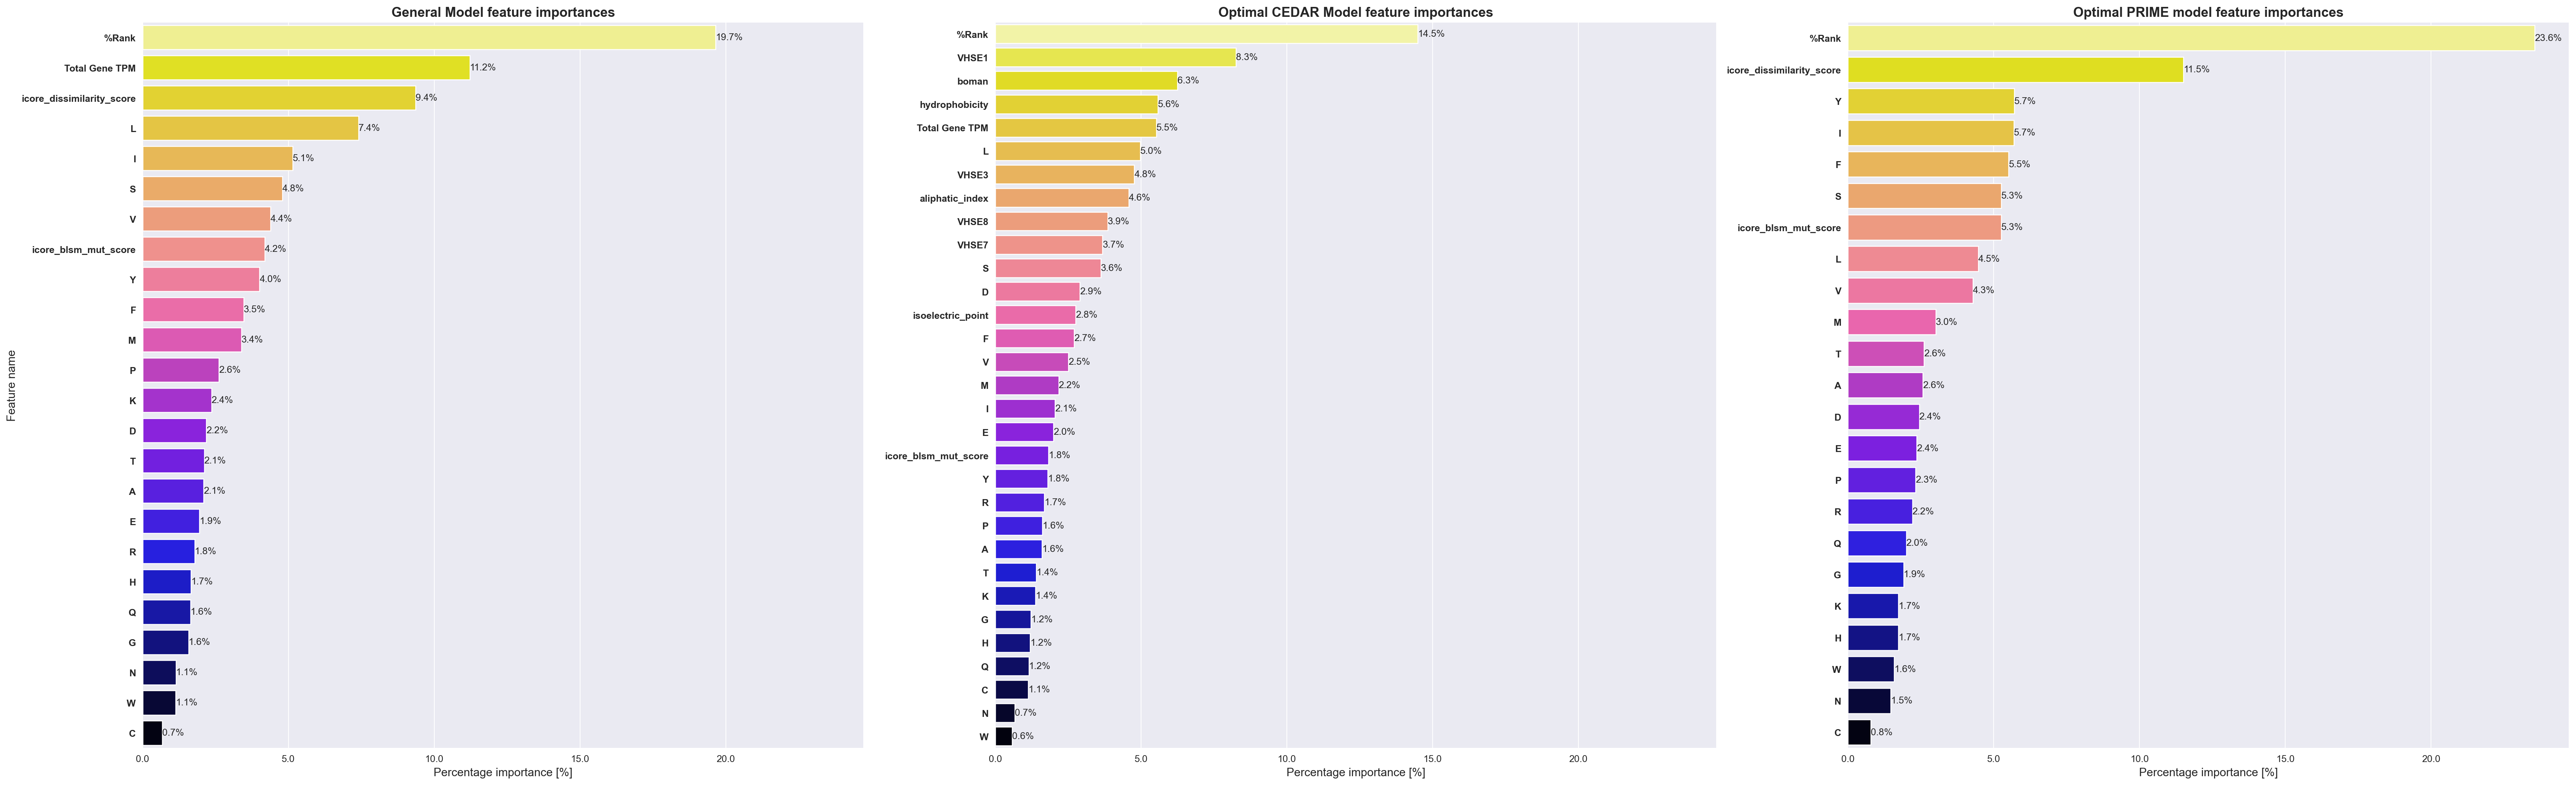

In [176]:
from src.metrics import plot_feature_importance
f,a = plt.subplots(1,3, figsize=(37.5,11.5), sharex=True)
plot_feature_importance(df_fi_expr_cedar.values.flatten(), df_fi_expr_cedar.columns.str.replace('rank','%Rank'), palette='gnuplot2_r', ax=a[1], title='Optimal CEDAR Model feature importances', label_number=True)
plot_feature_importance(df_fi_expr_comp.values.flatten(), df_fi_expr_comp.columns.str.replace('rank','%Rank'), palette='gnuplot2_r', ax=a[0], title='General Model feature importances', label_number=True)
plot_feature_importance(df_fi_expr_prime.values.flatten(), df_fi_expr_prime.columns.str.replace('rank','%Rank'), palette='gnuplot2_r', ax=a[2], title='Optimal PRIME model feature importances', label_number=True)
a[1].set_ylabel(None)
a[2].set_ylabel(None)
for ax in a.ravel():
    ax.set_yticklabels(ax.get_yticklabels(), fontweight='semibold')
f.tight_layout()
f.savefig('../../../writing/230131_cedar_paper_1/figures/featimps_allmodels.png', bbox_inches='tight', dpi=250)

## Filter Expr score & non Expr to the same peptides and get AUC

In [92]:
gb_merged = pd.read_csv('../output/230125_aligned_icore_exprscore_mutscore/gb_merged.csv')

In [93]:
# Starting with CEDAR
display(gb_merged.query('experiment=="aligned_mutscore"').sort_values('mean_auc_CEDAR', ascending=False).head(1))
display(gb_merged.query('experiment!="aligned_mutscore"').sort_values('mean_auc_CEDAR', ascending=False).head(1))

encoding            weight                            key    pep_col  \
193   onehot  Inverted Shannon  aa_props-icore_blsm_mut_score  icore_mut   

           experiment  mean_auc_CEDAR  mean_precision_CEDAR  mean_auc_PRIME  \
193  aligned_mutscore        0.734538              0.641071        0.642276   

     mean_precision_PRIME  mean_auc_IBEL  mean_precision_IBEL  mean_auc_NEPDB  \
193              0.030747       0.579488                  0.0        0.624505   

     mean_precision_NEPDB  mean_auc_agg  mean_auc_std  Compromise  
193              0.331922      0.688407      0.046131    0.777838

encoding            weight                      key    pep_col  \
1024   onehot  Inverted Shannon  aa_props-Total Gene TPM  icore_mut   

                 experiment  mean_auc_CEDAR  mean_precision_CEDAR  \
1024  aligned_expr_mutscore        0.738947               0.63671   

      mean_auc_PRIME  mean_precision_PRIME  mean_auc_IBEL  \
1024        0.642066              0.030175       0.527349   

      mean_precision_IBEL  mean_auc_NEPDB  mean_precision_NEPDB  mean_auc_agg  \
1024                  0.0         0.68659              0.332541      0.690506   

      mean_auc_std  Compromise  
1024      0.048441     0.77999

In [ ]:
cedar_best_expr = pd.read_csv('../output/230125_aligned_icore_exprscore_mutscore/raw/CEDAR_preds_cedar_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-Total Gene TPM.csv')
cedar_best_ali = pd.read_csv('../output/221122_mutscore_cedar_fixed/raw/cedar_preds_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aa_props.csv')
wtf = pd.read_csv('../output/230125_aligned_icore_exprscore_mutscore/raw/CEDAR_preds_cedar_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aa_props.csv')

filt = cedar_best_ali.query('Peptide in @cedar_best_expr.Peptide.values')
print(len(cedar_best_expr), len(filt), len(wtf))
roc_auc_score(filt['agg_label'], filt['pred']), roc_auc_score(cedar_best_expr['agg_label'], cedar_best_expr['mean_pred']), roc_auc_score(wtf['agg_label'], wtf['mean_pred'])

In [ ]:
# Then with PRIME
display(gb_merged.query('experiment=="aligned_mutscore"').sort_values('mean_auc_PRIME', ascending=False).head(2))
display(gb_merged.query('experiment!="aligned_mutscore"').sort_values('mean_auc_PRIME', ascending=False).head(2))

In [ ]:
prime_best_expr = pd.read_csv('../output/230125_aligned_icore_exprscore_mutscore/raw/PRIME_preds_cedar_onehot_Mask_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_blsm_mut_score-Total Gene TPM.csv')
prime_best_ali = pd.read_csv('../output/230125_aligned_icore_mutscore/raw/PRIME_preds_cedar_onehot_Mask_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_blsm_mut_score.csv')
wtf = pd.read_csv('../output/230125_aligned_icore_exprscore_mutscore/raw/PRIME_preds_cedar_onehot_Mask_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_blsm_mut_score.csv')
filt = prime_best_ali.query('Peptide in @prime_best_expr.Peptide.values')

# How does this happen ?? The same model with same features (prime_best_ali, wtf), from two different experiments (aligned mutscore vs Aligned Exprscore), should have the same AUCs when 
# Filtering on the same peptides ; but that is not the case ??? 
roc_auc_score(filt['agg_label'], filt['mean_pred']), roc_auc_score(prime_best_expr['agg_label'], prime_best_expr['mean_pred']), roc_auc_score(wtf['agg_label'], wtf['mean_pred'])

# Only explanation : 
# Model trained on the reduced dataset (i.e. without the datapoints without expression) is somehow better then the model trained on the full dataset,
# then evaluated on the subset/filtered preds with only the expr scores

In [ ]:
gb_merged.sort_values('mean_auc_NEPDB',ascending=False).head()

## just checking tops

In [ ]:
gb_merged.set_index(['encoding', 'weight', 'key', 'pep_col'], inplace=True)

In [ ]:
gb_merged.query('experiment=="aligned_mutscore"').sort_values('mean_auc_PRIME', ascending=False).head(3)*100

In [ ]:
for col in filter(lambda x: 'mean_auc_' in x, gb_merged.columns):
    print(col)
    display(gb_merged.sort_values(col, ascending=False).head(5)[['experiment', col]])

## Make a boxplot comparison for adding exprscore vs not

In [ ]:
df1 = pd.read_csv('../output/230125_aligned_icore_exprscore_mutscore/raw/CEDAR_preds_cedar_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aa_props.csv')
df2 = pd.read_csv('../output/230125_aligned_icore_mutscore/raw/CEDAR_preds_cedar_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aa_props.csv')

In [ ]:
roc_auc_score(df1['agg_label'].values, df1['mean_pred'].values), roc_auc_score(df2['agg_label'].values, df2['mean_pred'].values)

(0.7350486461539506, 0.7337816742783021)

In [130]:
random_prime = pd.read_csv('../output/230125_aligned_icore_exprscore_mutscore/raw/PRIME_preds_cedar_BL62FREQ_Inverted-KL_icore_mut_EL_rank_mut_aa_props.csv')
random_cedar = pd.read_csv('../output/230125_aligned_icore_exprscore_mutscore/raw/CEDAR_preds_cedar_BL62FREQ_Inverted-KL_icore_mut_EL_rank_mut_aa_props.csv')

len(random_prime), len(random_cedar)

(2591, 2988)

In [94]:
total_expr = pd.read_csv('../output/230125_aligned_icore_exprscore_mutscore/total_df.csv')
total_expr['key'] = total_expr['key'].str.replace('aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8', 'aa_props')

In [95]:
base_model = total_expr.query('(evalset=="CEDAR" or evalset=="PRIME") and weight=="None" and (key=="only_rank" or key.str.startswith("Total")) and encoding=="onehot" and pep_col=="icore_mut"')
compromise = total_expr.query('(evalset=="CEDAR" or evalset=="PRIME") and (weight == "None" and key.str.contains("icore_dissimilarity_score-icore_blsm_mut_score")) and encoding=="onehot" and pep_col=="icore_mut"', engine='python')
best_cedar = total_expr.query('(evalset=="CEDAR" or evalset=="PRIME") and (weight == "Inverted Shannon" and key.str.contains("aa_props")) and encoding=="onehot" and pep_col=="icore_mut"')
best_prime = total_expr.query('(evalset=="CEDAR" or evalset=="PRIME") and (weight == "Mask" and key.str.contains("icore_dissimilarity_score-icore_blsm_mut_score")) and encoding=="onehot" and pep_col=="icore_mut"')

In [111]:
best_cedar = best_cedar.query('key=="aa_props" or key=="aa_props-Total Gene TPM"')
best_prime = best_prime.query('key=="icore_dissimilarity_score-icore_blsm_mut_score" or key=="icore_dissimilarity_score-icore_blsm_mut_score-Total Gene TPM"')
base_model_comp = base_model.query('key == "only_rank" or key=="Total Gene TPM"')

In [118]:
compromise['model'] = 'General model'
compromise['add_expr'] = compromise['key'].apply(lambda x: 'TPM' in x)
best_cedar['model'] = 'Optimal CEDAR model'
best_cedar['add_expr'] = best_cedar['key'].apply(lambda x: 'TPM' in x)
best_prime['model'] = 'Optimal PRIME model'
best_prime['add_expr'] = best_prime['key'].apply(lambda x: 'TPM' in x)
base_model_comp['model'] = 'Base model'
base_model_comp['add_expr'] = base_model_comp['key'].apply(lambda x: 'TPM' in x)


In [125]:
total_expr_cedar = pd.concat([compromise, best_cedar, best_prime, base_model_comp]).query('evalset=="CEDAR"')
total_expr_prime = pd.concat([compromise, best_cedar, best_prime, base_model_comp]).query('evalset=="PRIME"')

In [ ]:
sns.palplot('gnuplot

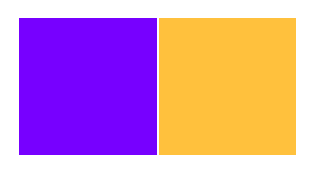

In [968]:
sns.palplot(get_palette('gnuplot2',n_colors=2))

CEDAR General model 2.200e-03, **
CEDAR Optimal CEDAR model 8.460e-02, ns
CEDAR Optimal PRIME model 1.860e-02, *
CEDAR Base model 4.650e-02, *
PRIME General model 6.299e-01, ns
PRIME Optimal CEDAR model 2.627e-01, ns
PRIME Optimal PRIME model 5.973e-01, ns
PRIME Base model 4.931e-01, ns


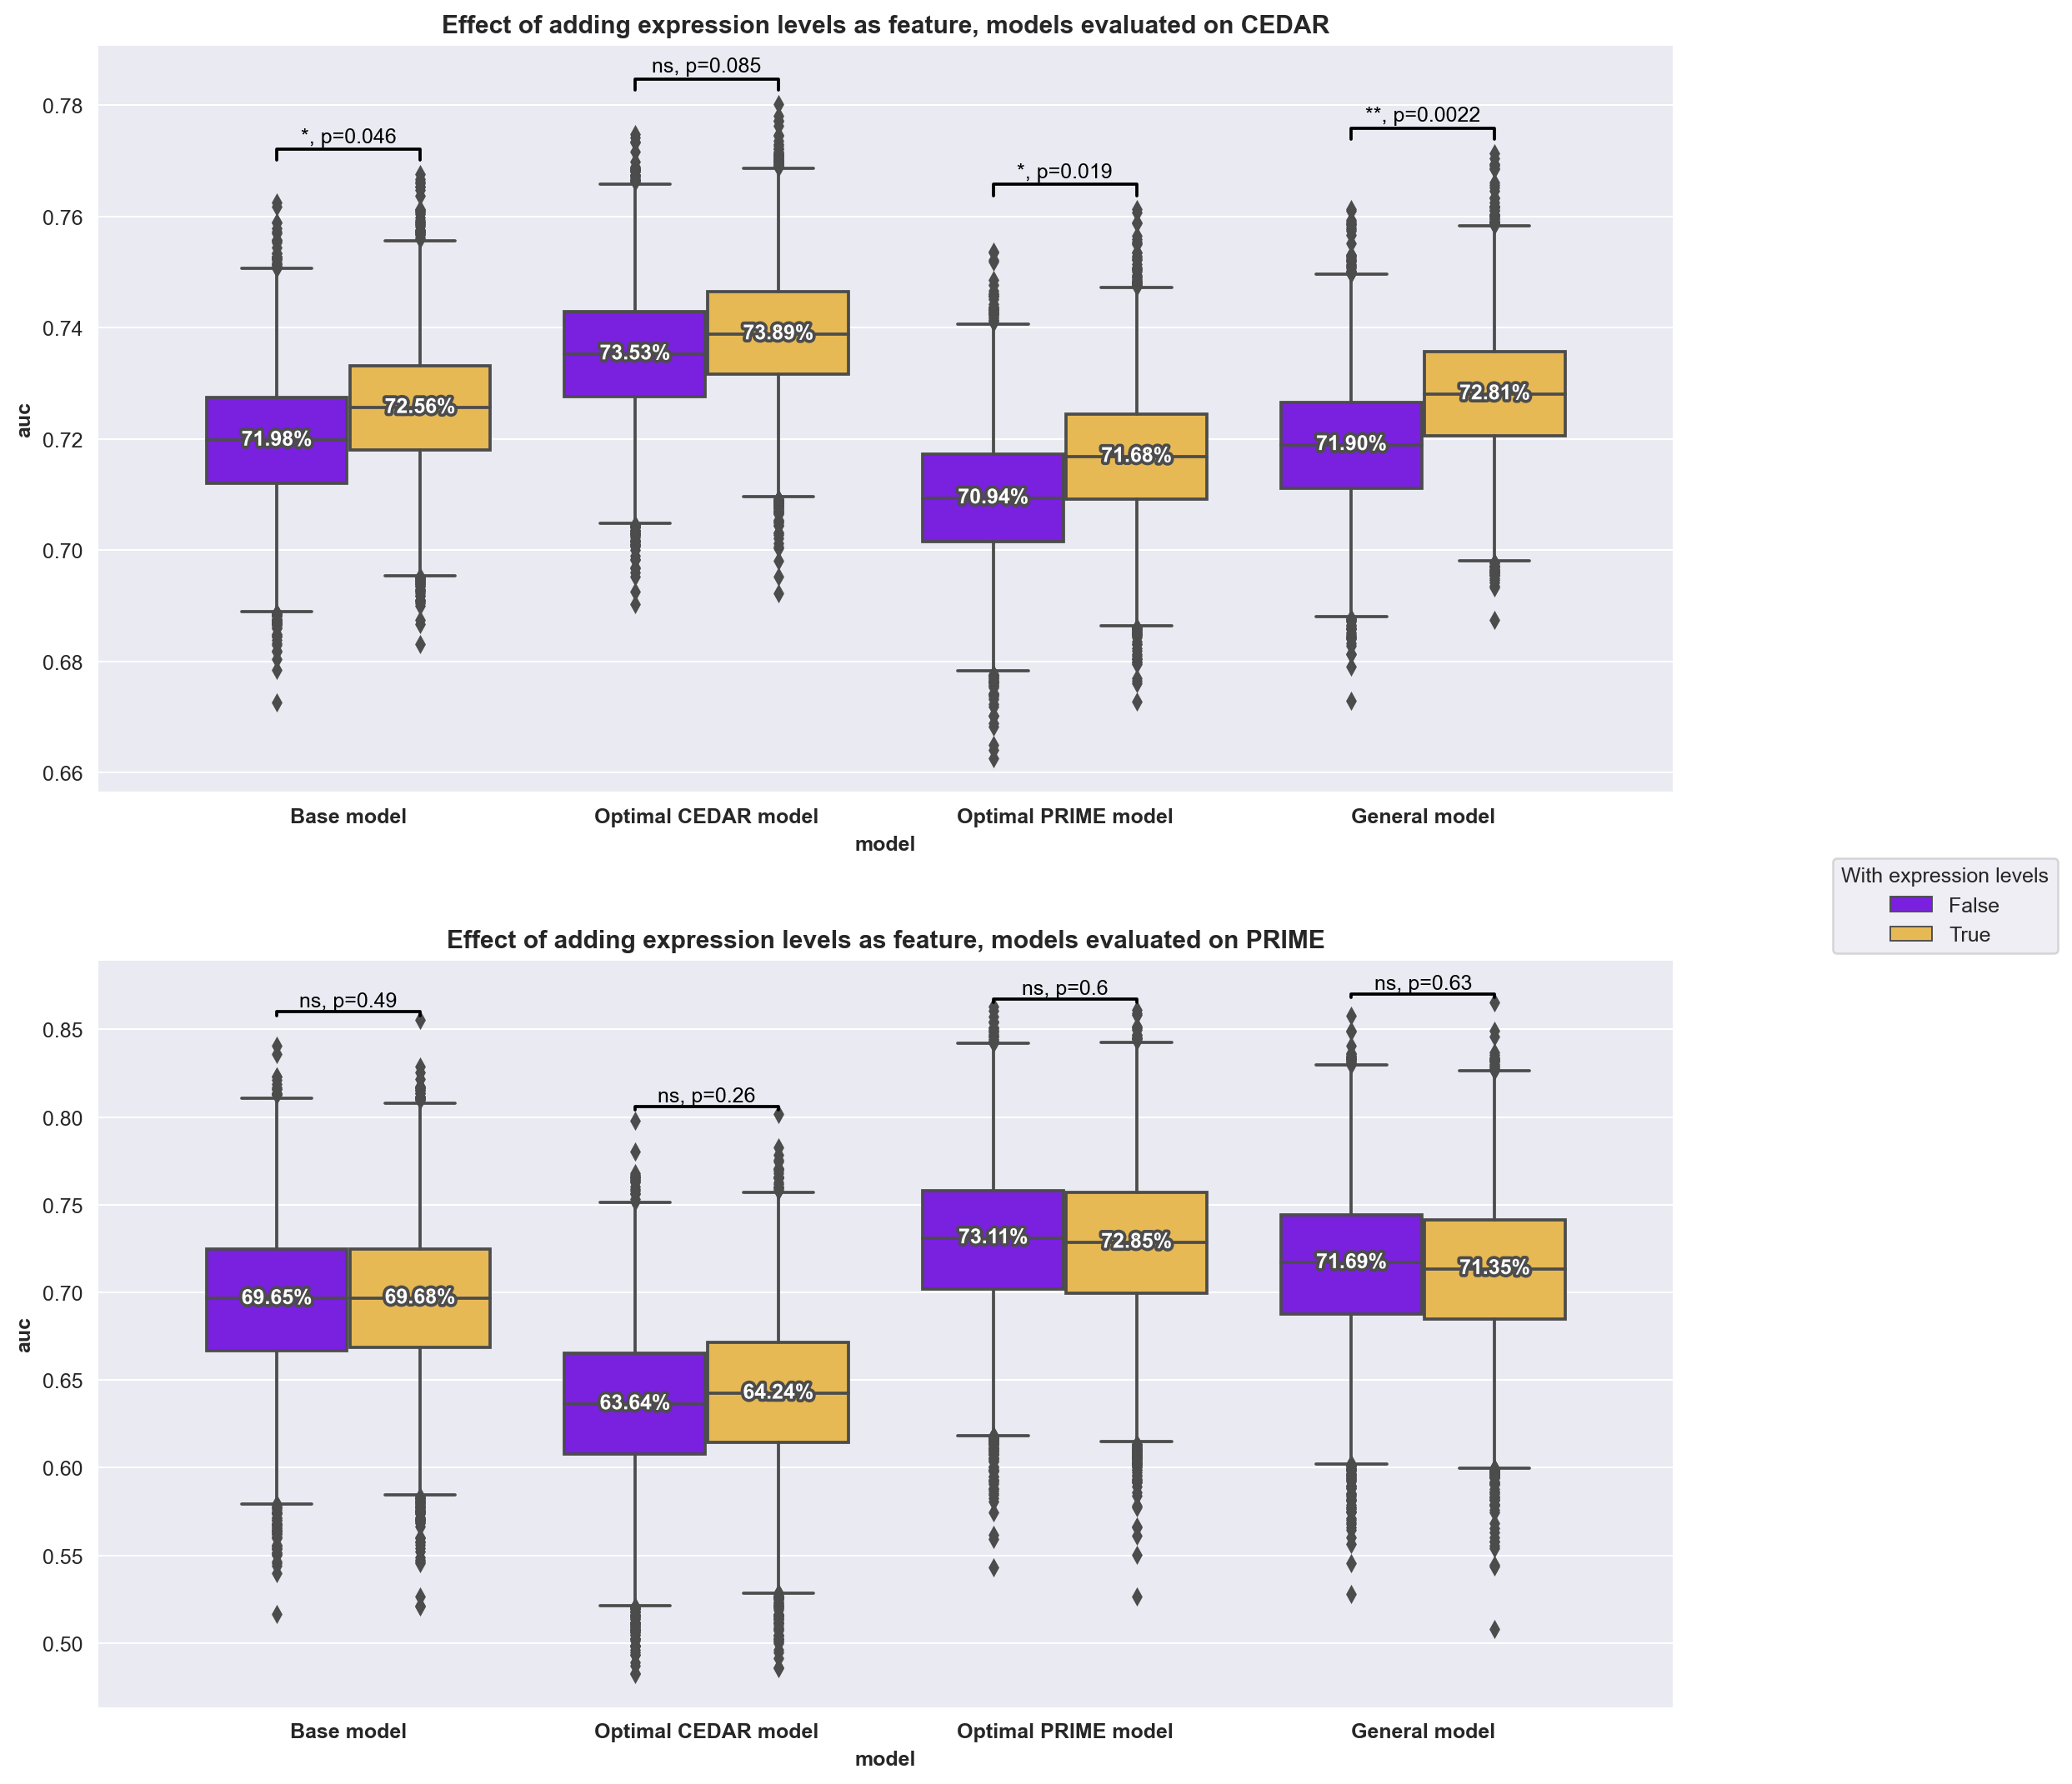

In [969]:
from src.utils import add_median_labels
order = ['Base model', 'Optimal CEDAR model', 'Optimal PRIME model', 'General model']

sns.set_palette(get_palette('gnuplot2',n_colors=2))
f,a = plt.subplots(2,1, figsize=(14,12))
for df, axis, nm in zip([total_expr_cedar, total_expr_prime], a.ravel(), ['CEDAR', 'PRIME']):
    if 'add_expr' in df.columns:
        df.rename(columns = {'add_expr':'With expression levels'}, inplace=True)
    sns.boxplot(data=df, x='model', hue='With expression levels', y='auc', ax=axis, order=order)
    add_median_labels(axis, fmt='.2%')
    for m in df.model.unique():
        tmp = df.query('model==@m')
        a = tmp.query('`With expression levels`').auc.values
        b = tmp.query('not `With expression levels`').auc.values
        # By default, box width=0.8
        pv,sig=get_pval(a,b)
        x_base = order.index(m)
        x0 = x_base-.4/2
        x1 = x_base+.4/2
        h = 0.0025
        y = max(a.max(),b.max())+h
        plot_pval(axis, pv, sig, x0, x1, y, h)
        print(nm, m, f'{pv:.3e}, {sig}')
    axis.legend([], frameon=False)
    axis.set_xticklabels(axis.get_xticklabels(), fontweight='semibold')
    axis.set_title(f'Effect of adding expression levels as feature, models evaluated on {nm}',
                  fontweight='semibold')
    axis.set_ylabel(axis.get_ylabel(), fontweight='semibold')
    axis.set_xlabel(axis.get_xlabel(), fontweight='semibold')

axis.legend(title='With expression levels', bbox_to_anchor=(1.25,1.15))
f.tight_layout()
f.savefig('../../../writing/230131_cedar_paper_1/figures/expression.png', 
          bbox_inches='tight', dpi=200)

# final results : BENCHMARK


## reload/saev

In [ ]:
cedar_aligned.to_csv('../../benchmark/data/cedar.pep', index=False,header=False,columns=['Peptide'])

In [ ]:
nepdb=nepdb.merge(pd.read_csv('../../gfeller_tools/PRIME-master/output/nepdb_prime.out', sep='\t',
                        comment='#')['Score_bestAllele'],
            left_index=True,right_index=True).rename(columns={'Score_bestAllele':'PRIME_score'})

In [ ]:
nepdb.to_csv('../../nnalign_cedar/nepdb_nnalign.pep', columns=['Peptide'], header=False, index=False)

In [ ]:
nepdb=nepdb.merge(pd.read_csv('../../nnalign_cedar/NNALIGN_evalNEPDB_with_BaselineCEDAR_model.txt', sep='\t')['Prediction'],
            left_index=True,right_index=True).rename(columns={'Prediction':'nnalign_score'})

In [ ]:
nepdb_copy = nepdb.copy() # backup
nepdb = nepdb.query('Peptide not in @cedar_aligned.Peptide.values')

## Process data and run various tools

Do on CEDAR - PRIME - NEPDB - IBEL(?)


- PRIME 

- NNAlign

- HLAthena

- AXEL-F

- IEDB 

- MHCFlurry

- Ineo-Epp

- TAP antigen

In [194]:
cedar_related_baseline['seq_id'] = [f'>seq_{i}' for i in range(1,len(cedar_related_baseline)+1)]
nepdb['seq_id'] = [f'>seq_{i}' for i in range(1,len(nepdb)+1)]
prime_related_baseline['seq_id'] = [f'>seq_{i}' for i in range(1,len(prime_related_baseline)+1)]

In [197]:
# Saving in fasta format (iTTCA-RF)
with open('../../benchmark/data/cedar.fa', 'w') as f:
    for i,row in cedar_related_baseline.iterrows():
        f.write(row['seq_id'])
        f.write('\n')
        f.write(row['Peptide'])
        f.write('\n')
        
with open('../../benchmark/data/prime.fa', 'w') as f:
    for i,row in prime_related_baseline.iterrows():
        f.write(row['seq_id'])
        f.write('\n')
        f.write(row['Peptide'])
        f.write('\n')
with open('../../benchmark/data/nepdb.fa', 'w') as f:
    for i,row in nepdb.iterrows():
        f.write(row['seq_id'])
        f.write('\n')
        f.write(row['Peptide'])
        f.write('\n')

In [199]:
# Saving for ineo epp 
cedar_aligned[['wild_type','Peptide']].to_csv('../../benchmark/data/cedar_wt_mut_ineo.pep',
                                              sep='\t', index=False,header=False)
prime_aligned[['wild_type','Peptide']].to_csv('../../benchmark/data/prime_wt_mut_ineo.pep',
                                              sep='\t', index=False,header=False)
nepdb_aligned[['wild_type','Peptide']].to_csv('../../benchmark/data/nepdb_wt_mut_ineo.pep',
                                              sep='\t', index=False,header=False)


In [208]:
# Saving for HLAthena
cedar_expr.rename(columns={'Total Gene TPM':'TPM'})[['Peptide', 'TPM']].to_csv('../../benchmark/data/cedar_hlathena_expr.pep',
                                                                               sep='\t', index=False)

nepdb_expr.rename(columns={'Total Gene TPM':'TPM'})[['Peptide', 'TPM']].to_csv('../../benchmark/data/nepdb_hlathena_expr.pep',
                                                                               sep='\t', index=False)

prime_expr.rename(columns={'Total Gene TPM':'TPM'})[['Peptide', 'TPM']].to_csv('../../benchmark/data/prime_hlathena_expr.pep', 
                                                                               sep='\t', index=False)

In [231]:
','.join(sorted(cedar_expr.HLA.str.replace('HLA-','').unique()))

'A0101,A0201,A0202,A0203,A0205,A0206,A0210,A0211,A0224,A0301,A0302,A1101,A1102,A2402,A2501,A2601,A2902,A3001,A3002,A3101,A3301,A6801,A6802,A6901,B0702,B0801,B1302,B1501,B1801,B2705,B3501,B3503,B3701,B3704,B3801,B3901,B3906,B4001,B4002,B4102,B4402,B4403,B4408,B4901,B5101,B5201,B5401,B5601,B5701,C0102,C0303,C0304,C0401,C0501,C0602,C0701,C0702,C0802,C1202,C1203,C1402,C1403,C1502'

In [ ]:
docker run -v `pwd`:`pwd` -w `pwd` ssarkizova/hlathena-external predict --runID "cedar" --allele A0101,A0201,A0202,A0203,A0205,A0206,A0210,A0211,A0224,A0301,A0302,A1101,A1102,A2402,A2501,A2601,A2902,A3001,A3002,A3101,A3301,A6801,A6802,A6901,B0702,B0801,B1302,B1501,B1801,B2705,B3501,B3503,B3701,B3704,B3801,B3901,B3906,B4001,B4002,B4102,B4402,B4403,B4408,B4901,B5101,B5201,B5401,B5601,B5701,C0102,C0303,C0304,C0401,C0501,C0602,C0701,C0702,C0802,C1202,C1203,C1402,C1403,C1502 --expr_col_name "TPM" --peptide_col_name "Peptide" -p ./cedar_hlathena_expr.pep --rundir ./results

In [ ]:
','.join(sorted(prime_expr.HLA.str.replace('HLA-','').unique()))

'A0101,A0201,A0206,A0211,A0301,A1101,A2402,A2501,A2601,A2902,A3001,A3101,A3301,A6801,A6802,A6901,B0702,B0801,B1501,B1801,B2702,B2705,B3501,B3503,B3701,B3801,B3901,B3906,B4001,B4102,B4402,B4403,B4901,B5101,B5601,B5701,C0102,C0303,C0304,C0401,C0501,C0602,C0701,C0702,C0802,C1203,C1403,C1502'

In [ ]:
docker run -v `pwd`:`pwd` -w `pwd` ssarkizova/hlathena-external predict --runID "prime" --allele A0101,A0201,A0206,A0211,A0301,A1101,A2402,A2501,A2601,A2902,A3001,A3101,A3301,A6801,A6802,A6901,B0702,B0801,B1501,B1801,B2702,B2705,B3501,B3503,B3701,B3801,B3901,B3906,B4001,B4102,B4402,B4403,B4901,B5101,B5601,B5701,C0102,C0303,C0304,C0401,C0501,C0602,C0701,C0702,C0802,C1203,C1403,C1502 --expr_col_name "TPM" --peptide_col_name "Peptide" -p ./prime_hlathena_expr.pep --rundir ./results

In [248]:
','.join(sorted(nepdb_expr.HLA.str.replace('HLA-','').unique()))

'A0101,A0201,A0301,A1101,A2601,A3001,A3101'

In [ ]:
docker run -v `pwd`:`pwd` -w `pwd` ssarkizova/hlathena-external predict --runID "nepdb" --allele A0101,A0201,A0301,A1101,A2601,A3001,A3101 --expr_col_name "TPM" --peptide_col_name "Peptide" -p ./nepdb_hlathena_expr.pep --rundir ./results

In [214]:
# MHCFlurry
cedar_related_baseline.rename(columns={'HLA':'allele','Peptide':'peptide'}).to_csv('../../benchmark/data/cedar_mhcflurry.csv',
                                                                       index=False, columns=['allele','peptide'])

prime_related_baseline.rename(columns={'HLA':'allele','Peptide':'peptide'}).to_csv('../../benchmark/data/prime_mhcflurry.csv',
                                                                       index=False, columns=['allele','peptide'])

nepdb.rename(columns={'HLA':'allele','Peptide':'peptide'}).to_csv('../../benchmark/data/nepdb_mhcflurry.csv',
                                                                       index=False, columns=['allele','peptide'])

In [247]:
# AxelF

cedar_expr['allele']=cedar_expr['HLA'].apply(lambda x: x[:5]+'*'+x[5:7]+':'+x[7:])
cedar_expr.rename(columns={'Peptide':'peptide','Total Gene TPM':'tpm'}).to_csv('../../iedb_tools/axelf/data/cedar_axelf.csv',
                                                                               sep=',', columns=['peptide','allele','tpm'], 
                                                                               index=False)


prime_expr['allele']=prime_expr['HLA'].apply(lambda x: x[:5]+'*'+x[5:7]+':'+x[7:])
prime_expr.rename(columns={'Peptide':'peptide','Total Gene TPM':'tpm'}).to_csv('../../iedb_tools/axelf/data/prime_axelf.csv',
                                                                               sep=',', columns=['peptide','allele','tpm'], 
                                                                               index=False)


nepdb_expr['allele']=nepdb_expr['HLA'].apply(lambda x: x[:5]+'*'+x[5:7]+':'+x[7:])
nepdb_expr.rename(columns={'Peptide':'peptide','Total Gene TPM':'tpm'}).to_csv('../../iedb_tools/axelf/data/nepdb_axelf.csv',
                                                                               sep=',', columns=['peptide','allele','tpm'], 
                                                                          index=False)

In [239]:
roc_auc_score(prime_expr['agg_label'], prime_expr['Total Gene TPM'])

0.5895191765950722

In [313]:
nepdb_expr.groupby('len').count()

Peptide  wild_type  HLA  agg_label  mut_len  wt_len  seq_id  Pos_mut  \
len                                                                         
9        132        132  132        132      132     132     132      132   
10       111        111  111        111      111     111     111      111   
11         1          1    1          1        1       1       1        1   

     Peptide_mut  core_mut  ...  HLAthena_score  HLAthena_rank  \
len                         ...                                  
9            132       132  ...             132            132   
10           111       111  ...             111            111   
11             1         1  ...               1              1   

     HLAthenaE_score  HLAthenaE_rank  IEDB_score  mhcflurry_affinity  \
len                                                                    
9                132             132         132                 132   
10               111             111         111                 111   
11                 1               1           1                   1   

     mhcflurry_affinity_percentile  mhcflurry_processing_score  \
len                                                              
9                              132                         132   
10                             111                         111   
11                               1                           1   

     mhcflurry_presentation_score  mhcflurry_presentation_percentile  
len                                                                   
9                             132                                132  
10                            111                                111  
11                              1                                  1  

[3 rows x 52 columns]

### manually saving csvs without duplicates for axelf


In [337]:
nepdb_expr.drop_duplicates(subset='Peptide')\
          .rename(columns = {'Peptide':'peptide',
                             'Total Gene TPM':'tpm'})\
          .to_csv('../../iedb_tools/axelf/data/nepdb_expr_nodup.csv',
                  columns = ['allele', 'peptide','tpm'],index=False)

In [350]:
cedar_expr.loc[~cedar_expr.duplicated(subset=['Peptide'], keep=False)]\
          .rename(columns={'Peptide':'peptide', 'Total Gene TPM':'tpm'}).to_csv('../../iedb_tools/axelf/cedar_expr_nodup.csv', index=False,columns=['allele','peptide','tpm'])

In [357]:
n3peps = cedar_expr.loc[cedar_expr.duplicated(subset=['Peptide'], keep=False)].groupby(['Peptide']).agg(count=('fold','count')).query('count>2').index.values

cedar_2p = cedar_expr.query('Peptide not in @n3peps')

cedar_2p.loc[cedar_2p.duplicated(subset=['Peptide'],
                                 keep='first')].rename(columns={'Peptide':'peptide', 
                                                                'Total Gene TPM':'tpm'}).to_csv('../../iedb_tools/axelf/data/cedar_2dup_first.csv', index=False,columns=['allele','peptide','tpm'])
cedar_2p.loc[cedar_2p.duplicated(subset=['Peptide'],
                                 keep='last')].rename(columns={'Peptide':'peptide', 
                                                                'Total Gene TPM':'tpm'}).to_csv('../../iedb_tools/axelf/data/cedar_2dup_last.csv', index=False,columns=['allele','peptide','tpm'])


In [370]:
cedar_3p = cedar_expr.query('Peptide in @n3peps')

cedar_3p.loc[~cedar_3p.duplicated(subset=['Peptide'],
                                 keep='first')].rename(columns={'Peptide':'peptide', 
                                                                'Total Gene TPM':'tpm'}).to_csv('../../iedb_tools/axelf/data/cedar_3dup_first.csv', index=False,columns=['allele','peptide','tpm'])
cedar_3p.loc[~cedar_3p.duplicated(subset=['Peptide'],
                                 keep='last')].rename(columns={'Peptide':'peptide', 
                                                                'Total Gene TPM':'tpm'}).to_csv('../../iedb_tools/axelf/data/cedar_3dup_last.csv', index=False,columns=['allele','peptide','tpm'])


In [373]:
first = ~cedar_3p.duplicated(subset=['Peptide'], keep='first')
last = ~cedar_3p.duplicated(subset=['Peptide'], keep='last')
keep_all = cedar_3p.duplicated(subset=['Peptide'], keep=False)
cedar_3p.loc[(~first&keep_all&~last)].rename(columns={'Peptide':'peptide', 
                                                                'Total Gene TPM':'tpm'}).to_csv('../../iedb_tools/axelf/data/cedar_3dup_middle.csv', index=False,columns=['allele','peptide','tpm'])

In [385]:
prime_expr.drop_duplicates(subset='Peptide').rename(columns={'Peptide':'peptide', 
                                                                'Total Gene TPM':'tpm'}).to_csv('../../iedb_tools/axelf/data/prime_expr_nodup.csv', index=False,columns=['allele','peptide','tpm'])

In [384]:
prime_expr.loc[prime_expr.duplicated(subset=['Peptide'],
                                 keep='first')].rename(columns={'Peptide':'peptide', 
                                                                'Total Gene TPM':'tpm'}).to_csv('../../iedb_tools/axelf/data/prime_expr_first.csv', index=False,columns=['allele','peptide','tpm'])
prime_expr.loc[prime_expr.duplicated(subset=['Peptide'],
                                 keep='last')].rename(columns={'Peptide':'peptide', 
                                                                'Total Gene TPM':'tpm'}).to_csv('../../iedb_tools/axelf/data/prime_expr_last.csv', index=False,columns=['allele','peptide','tpm'])


## results

In [407]:
def parse_hlathena(row, df_hlathena):
    pep = row['Peptide']
    hla = row['HLA'].replace('HLA-','').replace('*','').replace(':','')
    q=df_hlathena.query('Peptide==@pep')
    if len(q)>1:
        q=q.iloc[0]
    try:
        score = q[f'MSi_{hla}'].item()
    except:
        print(q)
    
    prank = q[f'prank.MSi_{hla}'].item()
    score_expr = q[f'MSiE_{hla}'].item()
    rank_expr = q[f'prank.MSiE_{hla}'].item()
    return score, prank, score_expr, rank_expr

In [414]:
nepdb_hlathena = pd.read_csv('../../benchmark/results/hlathena_nepdb/results/nepdb-predictions.txt', sep ='\t')
nepdb_iedb = pd.read_csv('../../benchmark/results/IEDB-CALIS_nepdb.csv')
nepdb_mhcflurry = pd.read_csv('../../benchmark/results/mhcflurry_nepdb.csv')

cedar_hlathena = pd.read_csv('../../benchmark/results/hlathena_cedar/results/cedar-predictions.txt', sep ='\t')
cedar_iedb = pd.read_csv('../../benchmark/results/IEDB-CALIS_cedar.csv')
cedar_mhcflurry = pd.read_csv('../../benchmark/results/mhcflurry_cedar.csv')

prime_hlathena = pd.read_csv('../../benchmark/results/hlathena_prime/results/prime-predictions.txt', sep ='\t')
prime_iedb = pd.read_csv('../../benchmark/results/IEDB-CALIS_prime.csv')
prime_mhcflurry = pd.read_csv('../../benchmark/results/mhcflurry_prime.csv')


In [553]:
nepdb_expr[['HLAthena_score', 'HLAthena_rank','HLAthenaE_score', 'HLAthenaE_rank']] = nepdb_expr.apply(parse_hlathena, df_hlathena=nepdb_hlathena, result_type='expand', axis=1)
nepdb_expr=nepdb_expr.merge(nepdb_iedb.rename(columns={'score':'IEDB_score',
                                                       'peptide':'Peptide'}).drop(columns=['length']),
                            left_on=['Peptide'], right_on=['Peptide'])
nepdb_expr=nepdb_expr.merge(nepdb_mhcflurry.rename(columns={'allele':'HLA',
                                                            'peptide':'Peptide'}), 
                            left_on=['Peptide','HLA'], right_on=['Peptide','HLA'])

In [555]:
nepdb_expr['allele'] = nepdb_expr['HLA'].apply(lambda x: x[:5]+'*'+x[5:7]+':'+x[7:])

nepdb_expr = nepdb_expr.merge(pd.read_csv('../../benchmark/results/axelf_nepdb_results.csv'),
                              left_on=['allele','Peptide'], right_on=['Allele','Peptide'])
nepdb_expr

Peptide   wild_type        HLA  agg_label  mut_len  wt_len   seq_id  \
0     AFGSAHLFR   AFGSAHLYR  HLA-A3101          1        9       9    seq_1   
1     AIANRIKFK   AIANRIKSK  HLA-A1101          0        9       9    seq_4   
2     AICKPLHYV   AICKPLHYM  HLA-A0201          0        9       9    seq_5   
3    AIPAMVVPNV  AIPAMVVPNA  HLA-A0201          0       10      10    seq_6   
4    ALEVLQSIPY  APEVLQSIPY  HLA-A0101          0       10      10    seq_7   
..          ...         ...        ...        ...      ...     ...      ...   
227   YTSEHAASV   YTPEHAASV  HLA-A0201          0        9       9  seq_325   
228   YVDVTYNFI   YVDVTYDFI  HLA-A0101          0        9       9  seq_326   
229  YVDVTYNFII  YVDVTYDFII  HLA-A0101          0       10      10  seq_327   
230   YVKLANLSY   YVKLANLPY  HLA-A2601          0        9       9  seq_328   
231   YVVTISSLL   HVVTISSLL  HLA-A2601          0        9       9  seq_329   

     Pos_mut Peptide_mut   core_mut  ... mhcflurry_affinity_percentile  \
0          0   AFGSAHLFR  AFGSAHLFR  ...                      0.195375   
1          0   AIANRIKFK  AIANRIKFK  ...                      0.191500   
2          0   AICKPLHYV  AICKPLHYV  ...                      0.128000   
3          0  AIPAMVVPNV  AIPAVVPNV  ...                      0.923500   
4          0  ALEVLQSIPY  ALEVLQSIY  ...                      0.542875   
..       ...         ...        ...  ...                           ...   
227        0   YTSEHAASV  YTSEHAASV  ...                      0.097000   
228        0    YVDVTYNF  YVD-VTYNF  ...                      0.533000   
229        0    YVDVTYNF  YVD-VTYNF  ...                      2.629375   
230        0   YVKLANLSY  YVKLANLSY  ...                      0.132000   
231        0   YVVTISSLL  YVVTISSLL  ...                      0.194875   

     mhcflurry_processing_score  mhcflurry_presentation_score  \
0                      0.077644                      0.692170   
1                      0.361186                      0.868480   
2                      0.232816                      0.891645   
3                      0.273845                      0.518769   
4                      0.038513                      0.175567   
..                          ...                           ...   
227                    0.045487                      0.828899   
228                    0.769156                      0.745583   
229                    0.062718                      0.016213   
230                    0.322933                      0.517501   
231                    0.015789                      0.173316   

    mhcflurry_presentation_percentile       allele       Allele   TPM Rank_el  \
0                            0.450978  HLA-A*31:01  HLA-A*31:01  2.22   0.637   
1                            0.171848  HLA-A*11:01  HLA-A*11:01  8.95   0.737   
2                            0.135353  HLA-A*02:01  HLA-A*02:01  0.09   0.527   
3                            0.780815  HLA-A*02:01  HLA-A*02:01  3.11   0.078   
4                            2.005109  HLA-A*01:01  HLA-A*01:01  0.00   0.255   
..                                ...          ...          ...   ...     ...   
227                          0.231875  HLA-A*02:01  HLA-A*02:01  0.86   0.636   
228                          0.365734  HLA-A*01:01  HLA-A*01:01  0.15   0.100   
229                         14.277038  HLA-A*01:01  HLA-A*01:01  0.15   0.008   
230                          0.785951  HLA-A*26:01  HLA-A*26:01  0.00   0.653   
231                          2.019810  HLA-A*26:01  HLA-A*26:01  1.30   0.303   

    Rank_mapped_to_IC50    Axelf  
0                 6.983  0.01198  
1                 7.654  0.03690  
2                 6.188  0.00430  
3                 2.999  0.16369  
4                 4.341  0.01153  
..                  ...      ...  
227               6.975  0.00468  
228               3.209  0.02660  
229               2.006  0.09527  
230               7.071  0.00297  
231               4.702  0.0210

In [ ]:
cedar_expr_copy = cedar_expr.copy(deep=True)
prime_expr_copy = prime_expr.copy(deep=True)
# Because hlathena takes len 8-11
cedar_expr=cedar_expr.query('len<12')
cedar_expr[['HLAthena_score', 'HLAthena_rank','HLAthenaE_score', 'HLAthenaE_rank']] = cedar_expr.apply(parse_hlathena, df_hlathena=cedar_hlathena, result_type='expand', axis=1)
cedar_expr=cedar_expr.merge(cedar_iedb.rename(columns={'score':'IEDB_score',
                                                       'peptide':'Peptide'}).drop(columns=['length']),
                            left_on=['Peptide'], right_on=['Peptide'])
cedar_expr=cedar_expr.merge(cedar_mhcflurry.rename(columns={'allele':'HLA',
                                                            'peptide':'Peptide'}), 
                            left_on=['Peptide','HLA'], right_on=['Peptide','HLA'])

In [549]:
prime_expr = prime_expr.query('len<12')
prime_expr[['HLAthena_score', 'HLAthena_rank','HLAthenaE_score', 'HLAthenaE_rank']] = prime_expr.apply(parse_hlathena, df_hlathena=prime_hlathena, result_type='expand', axis=1)
prime_expr=prime_expr.merge(prime_iedb.rename(columns={'score':'IEDB_score',
                                                       'peptide':'Peptide'}).drop(columns=['length']),
                            left_on=['Peptide'], right_on=['Peptide'])
prime_expr=prime_expr.merge(prime_mhcflurry.rename(columns={'allele':'HLA',
                                                            'peptide':'Peptide'}), 
                            left_on=['Peptide','HLA'], right_on=['Peptide','HLA'])

In [551]:
prime_expr['allele'] = prime_expr['HLA'].apply(lambda x: x[:5]+'*'+x[5:7]+':'+x[7:])
prime_expr=prime_expr.merge(pd.concat([pd.read_csv(f'../../benchmark/results/{x}') for x in os.listdir('../../benchmark/results/') if 'axelf_prime' in x.lower()]),
                 left_on=['allele', 'Peptide'], right_on=['Allele','Peptide'])

In [405]:
# Just checking AUCs for axelf for cedar & prime
cedar_expr=cedar_expr.merge(pd.concat([pd.read_csv(f'../../benchmark/results/{x}') for x in os.listdir('../../benchmark/results/') if 'axelf_cedar' in x.lower()]),
                 left_on=['allele', 'Peptide'], right_on=['Allele','Peptide'])



# bootstrapping results

## Reload/Save stuff

In [978]:
nepdb_expr[['Peptide', 'Total Gene TPM']].to_csv('../../benchmark/nepdb_tpm.txt', sep='\t', index=False,header=False)

In [455]:
nepdb_expr=nepdb_expr.merge(nepdb[['Peptide','HLA','agg_label', 'nnalign_score','PRIME_score']], left_on=['Peptide','HLA','agg_label'],right_on=['Peptide','HLA','agg_label'])

In [574]:
nepdb_expr.to_csv('../../benchmark/nepdb_scored_merged.csv', index=False)
prime_expr.to_csv('../../benchmark/prime_scored_merged.csv', index=False)
cedar_expr.to_csv('../../benchmark/cedar_scored_merged.csv', index=False)

## Reload benchmark scores + merge with other scores

In [155]:
nepdb_expr = pd.read_csv('../../benchmark/nepdb_scored_merged.csv')
prime_expr = pd.read_csv('../../benchmark/prime_scored_merged.csv')
cedar_expr  = pd.read_csv('../../benchmark/cedar_scored_merged.csv')

In [156]:
nepdb_expr = nepdb_expr.merge(nepdb_aligned_expr[list(nepdb_aligned_expr.columns.difference(nepdb_expr.columns))+['Peptide','HLA','agg_label']], left_on=['Peptide','HLA','agg_label'], right_on=['Peptide','HLA','agg_label'])
prime_expr = prime_expr.merge(prime_aligned_expr[list(prime_aligned_expr.columns.difference(prime_expr.columns))+['Peptide','HLA','agg_label']], left_on=['Peptide','HLA','agg_label'], right_on=['Peptide','HLA','agg_label'])
cedar_expr = cedar_expr.merge(cedar_aligned_expr[list(cedar_aligned_expr.columns.difference(cedar_expr.columns))+['Peptide','HLA','agg_label']], left_on=['Peptide','HLA','agg_label'], right_on=['Peptide','HLA','agg_label'])

In [158]:
nepdb_expr.to_csv('../../benchmark/nepdb_scored_merged.csv', index=False)
prime_expr.to_csv('../../benchmark/prime_scored_merged.csv', index=False)
cedar_expr.to_csv('../../benchmark/cedar_scored_merged.csv', index=False)

## Reloading preds from top models

In [182]:
cedar_cdt = 'cedar_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_blsm_mut_score-Total Gene TPM'
prime_cdt = 'cedar_onehot_Mask_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_blsm_mut_score'
comp_cdt = 'cedar_onehot_None_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_blsm_mut_score-Total Gene TPM'
base_cdt = 'cedar_onehot_None_Peptide_trueHLA_EL_rank_only_rank'

cedar_cdt_cedar_bs = pd.read_csv(f'../output/230125_aligned_icore_exprscore_mutscore/bootstrapping/CEDAR_bootstrapped_df_{cedar_cdt}.csv').assign(condition='Optimal CEDAR')
cedar_cdt_prime_bs = pd.read_csv(f'../output/230125_aligned_icore_exprscore_mutscore/bootstrapping/PRIME_bootstrapped_df_{cedar_cdt}.csv').assign(condition='Optimal CEDAR')
cedar_cdt_nepdb_bs = pd.read_csv(f'../output/230125_aligned_icore_exprscore_mutscore/bootstrapping/NEPDB_bootstrapped_df_{cedar_cdt}.csv').assign(condition='Optimal CEDAR')

prime_cdt_cedar_bs = pd.read_csv(f'../output/230125_aligned_icore_exprscore_mutscore/bootstrapping/CEDAR_bootstrapped_df_{prime_cdt}.csv').assign(condition='Optimal PRIME')
prime_cdt_prime_bs = pd.read_csv(f'../output/230125_aligned_icore_exprscore_mutscore/bootstrapping/PRIME_bootstrapped_df_{prime_cdt}.csv').assign(condition='Optimal PRIME')
prime_cdt_nepdb_bs = pd.read_csv(f'../output/230125_aligned_icore_exprscore_mutscore/bootstrapping/NEPDB_bootstrapped_df_{prime_cdt}.csv').assign(condition='Optimal PRIME')

comp_cdt_cedar_bs = pd.read_csv(f'../output/230125_aligned_icore_exprscore_mutscore/bootstrapping/CEDAR_bootstrapped_df_{comp_cdt}.csv').assign(condition='General Model')
comp_cdt_prime_bs = pd.read_csv(f'../output/230125_aligned_icore_exprscore_mutscore/bootstrapping/PRIME_bootstrapped_df_{comp_cdt}.csv').assign(condition='General Model')
comp_cdt_nepdb_bs = pd.read_csv(f'../output/230125_aligned_icore_exprscore_mutscore/bootstrapping/NEPDB_bootstrapped_df_{comp_cdt}.csv').assign(condition='General Model')


cedar_cdt_cedar_rocs = pkl_load(f'../output/230125_aligned_icore_exprscore_mutscore/bootstrapping/CEDAR_mean_rocs_{cedar_cdt}.pkl')
cedar_cdt_prime_rocs = pkl_load(f'../output/230125_aligned_icore_exprscore_mutscore/bootstrapping/PRIME_mean_rocs_{cedar_cdt}.pkl')
cedar_cdt_nepdb_rocs = pkl_load(f'../output/230125_aligned_icore_exprscore_mutscore/bootstrapping/NEPDB_mean_rocs_{cedar_cdt}.pkl')

prime_cdt_cedar_rocs = pkl_load(f'../output/230125_aligned_icore_exprscore_mutscore/bootstrapping/CEDAR_mean_rocs_{prime_cdt}.pkl')
prime_cdt_prime_rocs = pkl_load(f'../output/230125_aligned_icore_exprscore_mutscore/bootstrapping/PRIME_mean_rocs_{prime_cdt}.pkl')
prime_cdt_nepdb_rocs = pkl_load(f'../output/230125_aligned_icore_exprscore_mutscore/bootstrapping/NEPDB_mean_rocs_{prime_cdt}.pkl')

comp_cdt_cedar_rocs = pkl_load(f'../output/230125_aligned_icore_exprscore_mutscore/bootstrapping/CEDAR_mean_rocs_{comp_cdt}.pkl')
comp_cdt_prime_rocs = pkl_load(f'../output/230125_aligned_icore_exprscore_mutscore/bootstrapping/PRIME_mean_rocs_{comp_cdt}.pkl')
comp_cdt_nepdb_rocs = pkl_load(f'../output/230125_aligned_icore_exprscore_mutscore/bootstrapping/NEPDB_mean_rocs_{comp_cdt}.pkl')

cedar_cdt_cedar_preds = pd.read_csv(f'../output/230125_aligned_icore_exprscore_mutscore/raw/CEDAR_preds_{cedar_cdt}.csv').rename(columns={'mean_pred':'Optimal CEDAR'})
cedar_cdt_prime_preds = pd.read_csv(f'../output/230125_aligned_icore_exprscore_mutscore/raw/PRIME_preds_{cedar_cdt}.csv').rename(columns={'mean_pred':'Optimal CEDAR'})
cedar_cdt_nepdb_preds = pd.read_csv(f'../output/230125_aligned_icore_exprscore_mutscore/raw/NEPDB_preds_{cedar_cdt}.csv').rename(columns={'mean_pred':'Optimal CEDAR'})

prime_cdt_cedar_preds = pd.read_csv(f'../output/230125_aligned_icore_exprscore_mutscore/raw/CEDAR_preds_{prime_cdt}.csv').rename(columns={'mean_pred':'Optimal PRIME'})
prime_cdt_prime_preds = pd.read_csv(f'../output/230125_aligned_icore_exprscore_mutscore/raw/PRIME_preds_{prime_cdt}.csv').rename(columns={'mean_pred':'Optimal PRIME'})
prime_cdt_nepdb_preds = pd.read_csv(f'../output/230125_aligned_icore_exprscore_mutscore/raw/NEPDB_preds_{prime_cdt}.csv').rename(columns={'mean_pred':'Optimal PRIME'})

comp_cdt_cedar_preds = pd.read_csv(f'../output/230125_aligned_icore_exprscore_mutscore/raw/CEDAR_preds_{comp_cdt}.csv').rename(columns={'mean_pred':'General Model'})
comp_cdt_prime_preds = pd.read_csv(f'../output/230125_aligned_icore_exprscore_mutscore/raw/PRIME_preds_{comp_cdt}.csv').rename(columns={'mean_pred':'General Model'})
comp_cdt_nepdb_preds = pd.read_csv(f'../output/230125_aligned_icore_exprscore_mutscore/raw/NEPDB_preds_{comp_cdt}.csv').rename(columns={'mean_pred':'General Model'})

# # Base model of no weights + only rank + full pep HLA + Peptide as input
# comp_cdt_cedar_preds = pd.read_csv(f'../output/230125_expr_mutscores/raw/CEDAR_preds_{base_cdt}.csv').rename(columns={'mean_pred':'Base Model'})
# comp_cdt_prime_preds = pd.read_csv(f'../output/230125_expr_mutscores/raw/PRIME_preds_{base_cdt}.csv').rename(columns={'mean_pred':'Base Model'})
# comp_cdt_nepdb_preds = pd.read_csv(f'../output/230125_expr_mutscores/raw/SINE_IBEL_preds_{base_cdt}.csv').rename(columns={'mean_pred':'Base Model'})

## Rebootstrapping

In [186]:
name_map = {'EL_rank_mut':'NetMHCpan',
            'HLAthenaE_rank': 'HLAthena_E',
            'nnalign_score':'NNAlign',
            'IEDB_score':'IEDB-Calis',
            'PRIME_score':'PRIME',
            'Axelf':'AXEL-F',
            'mhcflurry_presentation_percentile':'MHCflurry',
            'foreignness_score':'AntigenGarnish_foreignness',
            'EL_rank_exp':'NetMHCpanExp'}
def map_name(name):
    out = name_map[name] if name in name_map.keys() else name
    return out
def get_palette(palette, n_colors):
    """ 'stretches' stupid fucking palette to have more contrast"""
    pal = sns.color_palette(palette, n_colors=int(n_colors*2))
    palette = [pal[i] for i in range(1, 1+int(n_colors*2), 2)]
    return palette

In [187]:
from src.bootstrap import get_pval, plot_pval, bootstrap_eval
cedar_bs_list = []
prime_bs_list = []
nepdb_bs_list = []
cedar_rocs_dicts = {}
prime_rocs_dicts = {}
nepdb_rocs_dicts = {}
columns = ['Axelf', 'PRIME_score', 'nnalign_score', 'IEDB_score', 'EL_rank_mut', 'HLAthenaE_rank', 'mhcflurry_presentation_percentile', 'EL_rank_exp', 'foreignness_score']
for df, nm, bs_list, rocs_dict, preds in zip([cedar_expr, prime_expr, nepdb_expr], 
                                      ['cedar', 'prime', 'nepdb'], 
                                      [cedar_bs_list, prime_bs_list, nepdb_bs_list],
                                      [cedar_rocs_dicts, prime_rocs_dicts, nepdb_rocs_dicts],
                                             [[cedar_cdt_cedar_preds, prime_cdt_cedar_preds, comp_cdt_cedar_preds],
                                              [cedar_cdt_prime_preds, prime_cdt_prime_preds, comp_cdt_prime_preds],
                                              [cedar_cdt_nepdb_preds, prime_cdt_nepdb_preds, comp_cdt_nepdb_preds]]
                                            ):
    print(nm)
    for p, cdt in zip(preds, ['Optimal CEDAR', 'Optimal PRIME', 'General Model']):
        bs_df, rocs = bootstrap_eval(p[cdt].values, p['agg_label'].values, n_rounds=10000, n_jobs=8, auc01=True)
        bs_df['evalset']=nm.upper()
        bs_df['condition']=cdt
        bs_list.append(bs_df)
        rocs_dict[cdt] = rocs
        
    for c in tqdm(columns):
        scores = df[c].values
        labels = df['agg_label'].values
        if 'rank' in c or 'perc' in c:
            bs_df, rocs = bootstrap_eval(1-scores, labels, n_rounds=10000, n_jobs=8, auc01=True)
        else:
            bs_df, rocs = bootstrap_eval(scores, labels, n_rounds=10000, n_jobs=8, auc01=True)
        k = name_map[c]
        bs_df['evalset']=nm.upper()
        bs_df['condition']=k
        bs_list.append(bs_df)
        rocs_dict[k] = rocs

cedar
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


  0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
prime
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


  0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
nepdb
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


  0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


In [560]:
cedar_expr = cedar_expr.merge(cedar_cdt_cedar_preds.merge(prime_cdt_cedar_preds,
                                                          left_on=['Peptide','HLA','agg_label'], 
                                                          right_on=['Peptide','HLA','agg_label'])\
                              .merge(comp_cdt_cedar_preds,
                                     left_on=['Peptide','HLA','agg_label'], right_on=['Peptide','HLA','agg_label']),
                              left_on=['Peptide','HLA','agg_label'], right_on=['Peptide','HLA','agg_label'])

prime_expr = prime_expr.merge(cedar_cdt_prime_preds.merge(prime_cdt_prime_preds,
                                                          left_on=['Peptide','HLA','agg_label'], 
                                                          right_on=['Peptide','HLA','agg_label'])\
                              .merge(comp_cdt_prime_preds,
                                     left_on=['Peptide','HLA','agg_label'], right_on=['Peptide','HLA','agg_label']),
                              left_on=['Peptide','HLA','agg_label'], right_on=['Peptide','HLA','agg_label'])

nepdb_expr = nepdb_expr.merge(cedar_cdt_nepdb_preds.merge(prime_cdt_nepdb_preds,
                                                          left_on=['Peptide','HLA','agg_label'], 
                                                          right_on=['Peptide','HLA','agg_label'])\
                              .merge(comp_cdt_nepdb_preds,
                                     left_on=['Peptide','HLA','agg_label'], right_on=['Peptide','HLA','agg_label']),
                              left_on=['Peptide','HLA','agg_label'], right_on=['Peptide','HLA','agg_label'])

In [195]:
cedar_bs_df = pd.concat(cedar_bs_list)
prime_bs_df = pd.concat(prime_bs_list)
nepdb_bs_df = pd.concat(nepdb_bs_list)

cedar_bs_df.to_csv('../../benchmark/cedar_bs_df_benchmark.csv')
prime_bs_df.to_csv('../../benchmark/prime_bs_df_benchmark.csv')
nepdb_bs_df.to_csv('../../benchmark/nepdb_bs_df_benchmark.csv')

pkl_dump(cedar_rocs_dicts, '../../benchmark/cedar_rocs_dicts.pkl')
pkl_dump(prime_rocs_dicts, '../../benchmark/prime_rocs_dicts.pkl')
pkl_dump(nepdb_rocs_dicts, '../../benchmark/nepdb_rocs_dicts.pkl')

../../benchmark/cedar_rocs_dicts.pkl saved.
../../benchmark/prime_rocs_dicts.pkl saved.
../../benchmark/nepdb_rocs_dicts.pkl saved.


In [196]:
nepdb_expr.to_csv('../../benchmark/nepdb_scored_merged.csv', index=False)
prime_expr.to_csv('../../benchmark/prime_scored_merged.csv', index=False)
cedar_expr.to_csv('../../benchmark/cedar_scored_merged.csv', index=False)

## plots

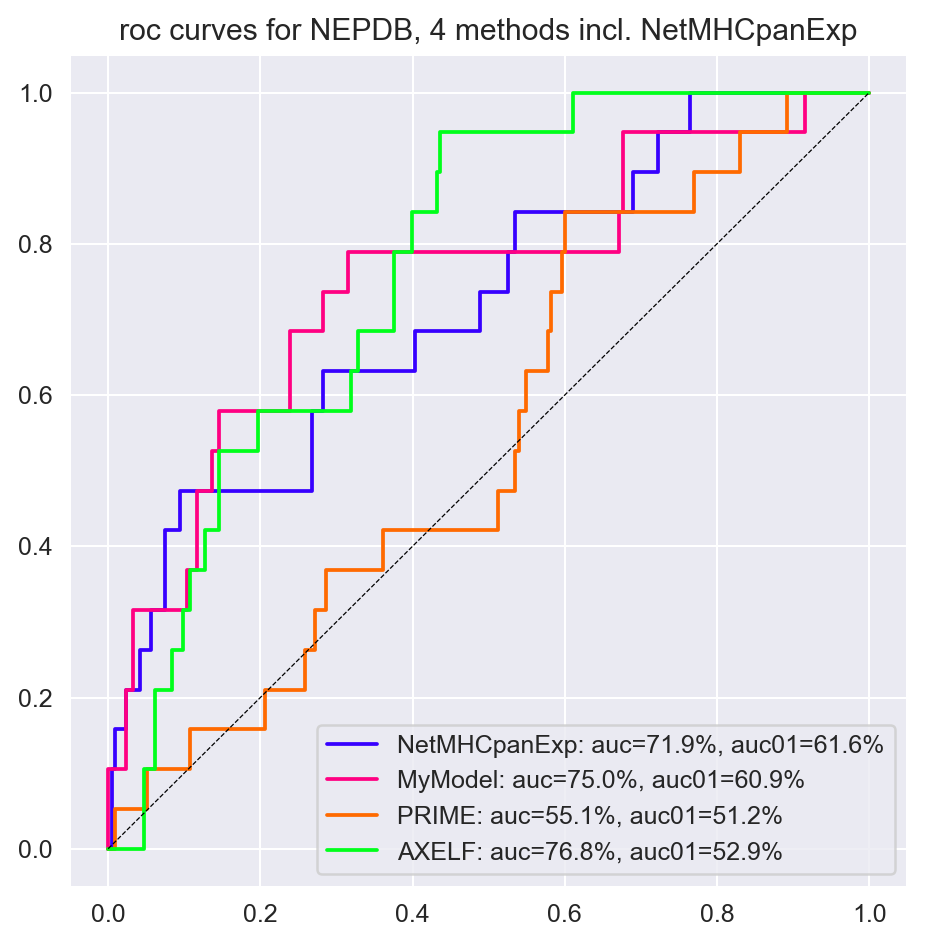

In [204]:
from src.metrics import roc_curve, roc_auc_score
sns.set_palette(HSV)
f,a = plt.subplots(1,1, figsize=(6,6))
# NetMHCpan Exp
fpr, tpr,auc, auc01 = get_roc_curve_auc(nepdb_expr, 'agg_label', 'EL_rank_exp', neg=True)
a.plot(fpr,tpr,label=f'NetMHCpanExp: auc={auc:.1%}, auc01={auc01:.1%}')

fpr,tpr,auc,auc01 = get_roc_curve_auc(nepdb_expr, 'agg_label', 'General Model')
a.plot(fpr,tpr,label=f'MyModel: auc={auc:.1%}, auc01={auc01:.1%}')

fpr,tpr,auc,auc01 = get_roc_curve_auc(nepdb_expr, 'agg_label', 'PRIME_score')
a.plot(fpr,tpr,label=f'PRIME: auc={auc:.1%}, auc01={auc01:.1%}')

fpr,tpr,auc,auc01 = get_roc_curve_auc(nepdb_expr, 'agg_label', 'Axelf')
a.plot(fpr,tpr,label=f'AXELF: auc={auc:.1%}, auc01={auc01:.1%}')
a.legend()
a.set_title('roc curves for NEPDB, 4 methods incl. NetMHCpanExp')
a.plot([0,1],[0,1], label='Random', ls='--', lw=.5, c='k')

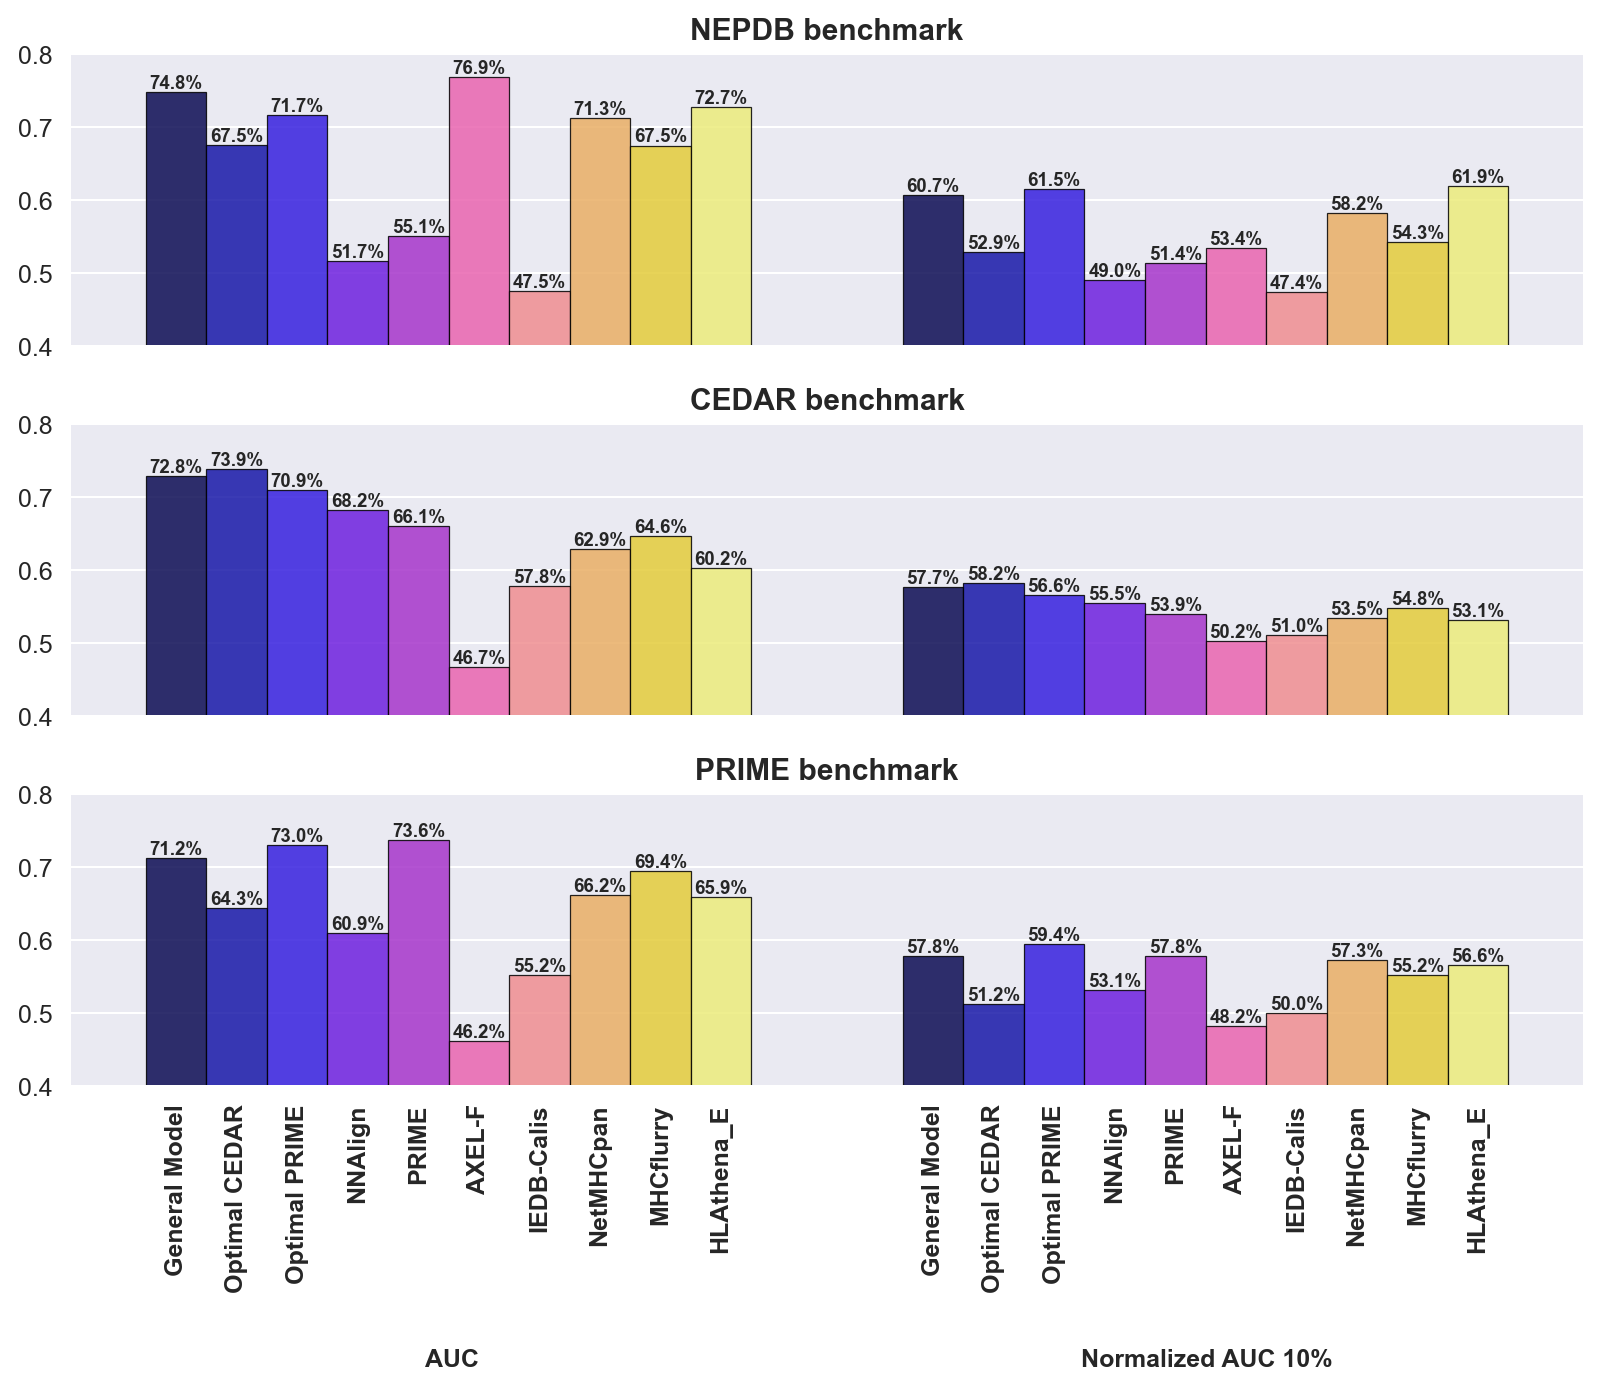

In [1163]:
# BARPLOT

hue_order = ['General Model', 'Optimal CEDAR', 'Optimal PRIME', 'NNAlign', 'PRIME', 'AXEL-F',  'IEDB-Calis', 'NetMHCpan', 'MHCflurry', 'HLAthena_E']

f,a = plt.subplots(3,1, figsize=(9,8), sharex=True)
for df, evalset, axis in zip([nepdb_bs_df, cedar_bs_df, prime_bs_df],
                             ['NEPDB', 'CEDAR', 'PRIME'],
                             a.ravel()):
    df = df.query('condition!="mhcflurry_affinity_percentile"')
    sns.set_palette('viridis')
    df['Method'] = df['condition'].apply(map_name)
    sns.barplot(data=df.melt(id_vars = ['Method'], value_vars = ['auc', 'auc_01']), palette=get_palette('gnuplot2', n_colors=10), 
                hue_order = hue_order, 
                y= 'value',hue='Method', x='variable', errorbar=None, ax=axis, width=0.8)
    
    # if evalset != 'NEPDB':
    #     axis.legend([], frameon=False)
    # else:
    #     pass
    #     axis.legend(bbox_to_anchor = (1.225, -.125))
    
    # Set title and remove legend
    axis.set_title(f'{evalset} benchmark', fontweight = 'semibold')
    axis.legend([], frameon=False)
    # Label number
    for container in axis.containers:
        values = [f'{(100 * x).round(1)}%' for x in container.datavalues]
        axis.bar_label(container, labels=values, fontsize=7.5, fontweight='semibold')
        
    axis.set_ylim([.4,0.8])
    axis.set_xlabel(None)
    axis.set_ylabel(None)
    plt.setp(axis.patches, linewidth=0.5, edgecolor='k', alpha=0.85)

    # Manually rewriting tickmarks ; Goes from -.4 to 0.32 (those are x0), in 0.08 increments, and from 1-.4 to 1+.32
    # So the center of each patch is x0+0.08/2 = x0+0.04
    # Then, there are 20 rectangles (10 for each X), and each even index is the patch on the left, odd index is the patch on the right
    x0s = list(np.linspace(-.4+0.04, .32+0.04, 10))
    x1s = list(np.linspace(1-.4+0.04, 1+.32+0.04, 10))
    labels = hue_order + hue_order
axis = a.ravel()[-1]
axis.set_xticks(x0s+x1s)
axis.set_xticklabels(labels, fontweight='semibold', rotation=90)
#Stupid manual annotation
axis.text((-.4+0.36)/2 + 0.025, 0.025, 'AUC', ha='center', va='center', fontweight='bold')
axis.text(1+ ((-.4+0.36)/2) + 0.0215, 0.025, 'Normalized AUC 10%', ha='center', va='center', fontweight='bold')

f.tight_layout()
f.savefig('../../../writing/230131_cedar_paper_1/figures/barplot_benchmark.png', bbox_inches='tight', dpi=200)

In [205]:
concat = pd.concat([nepdb_bs_df, cedar_bs_df, prime_bs_df]).groupby(['evalset','condition']).agg(mean_auc=('auc','mean'),
                                                                                                 mean_auc01=('auc_01','mean')).reset_index()\
           .melt(id_vars = ['evalset', 'condition'], value_vars=['mean_auc', 'mean_auc01']).query('condition!="mhcflurry_affinity_percentile"')
concat['Method'] = concat['condition'].apply(map_name)
concat.head()

evalset                   condition  variable     value  \
0   CEDAR                      AXEL-F  mean_auc  0.467250   
1   CEDAR  AntigenGarnish_foreignness  mean_auc  0.523740   
2   CEDAR               General Model  mean_auc  0.728096   
3   CEDAR                  HLAthena_E  mean_auc  0.601996   
4   CEDAR                  IEDB-Calis  mean_auc  0.577859   

                       Method  
0                      AXEL-F  
1  AntigenGarnish_foreignness  
2               General Model  
3                  HLAthena_E  
4                  IEDB-Calis

In [213]:
concat

evalset                   condition    variable     value  \
0    CEDAR                      AXEL-F    mean_auc  0.467250   
1    CEDAR  AntigenGarnish_foreignness    mean_auc  0.523740   
2    CEDAR               General Model    mean_auc  0.728096   
3    CEDAR                  HLAthena_E    mean_auc  0.601996   
4    CEDAR                  IEDB-Calis    mean_auc  0.577859   
..     ...                         ...         ...       ...   
67   PRIME                   NetMHCpan  mean_auc01  0.570481   
68   PRIME                NetMHCpanExp  mean_auc01  0.546932   
69   PRIME               Optimal CEDAR  mean_auc01  0.512021   
70   PRIME               Optimal PRIME  mean_auc01  0.594233   
71   PRIME                       PRIME  mean_auc01  0.581745   

                        Method  
0                       AXEL-F  
1   AntigenGarnish_foreignness  
2                General Model  
3                   HLAthena_E  
4                   IEDB-Calis  
..                         ...  
67                   NetMHCpan  
68                NetMHCpanExp  
69               Optimal CEDAR  
70               Optimal PRIME  
71                       PRIME  

[72 rows x 5 columns]

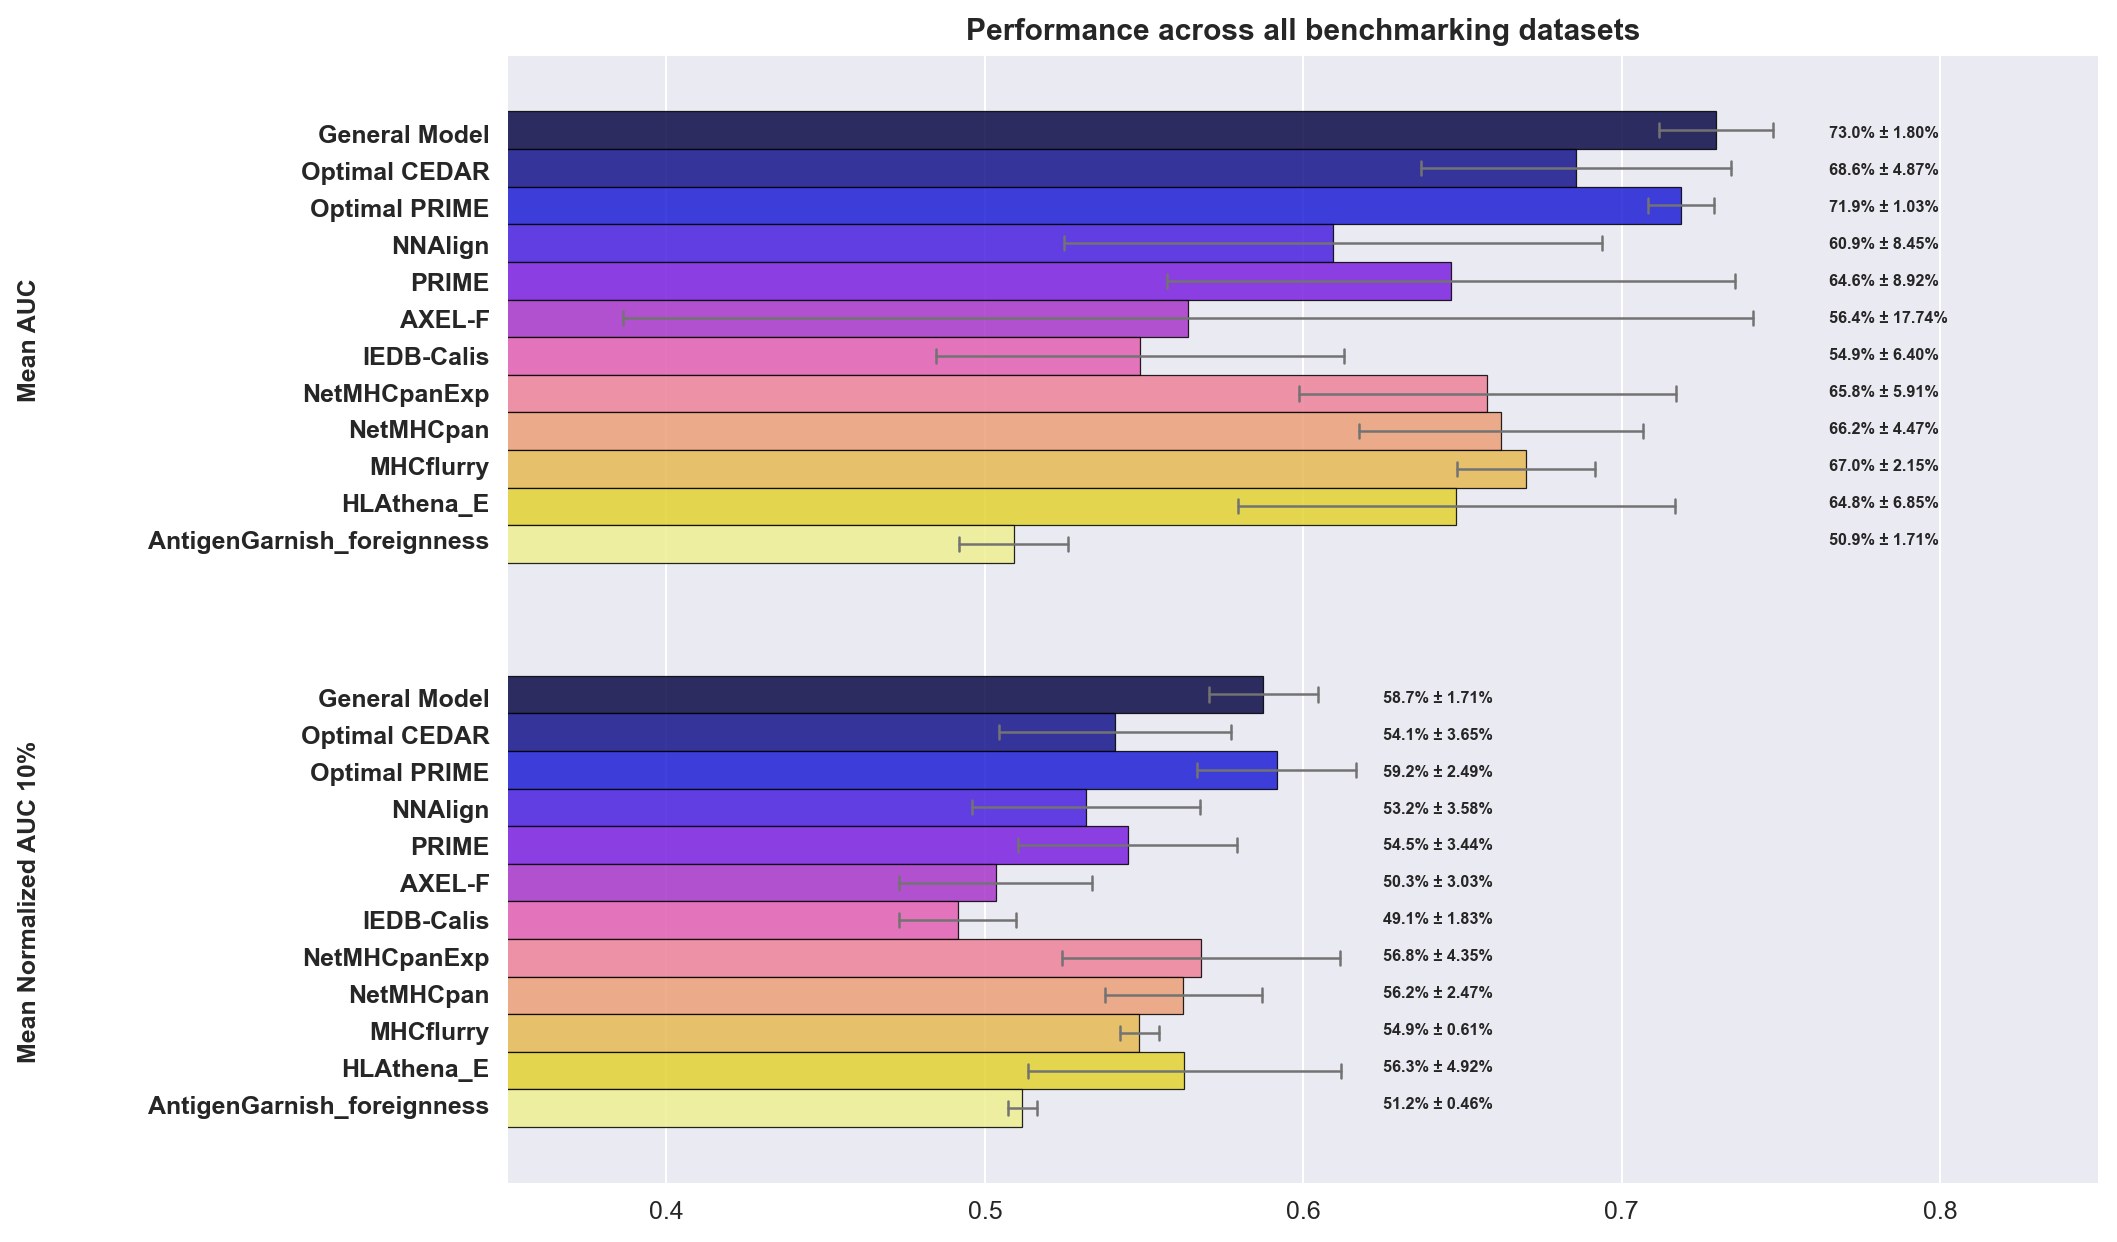

In [212]:
# BARPLOT

hue_order = ['General Model', 'Optimal CEDAR', 'Optimal PRIME', 'NNAlign', 'PRIME', 'AXEL-F', 'IEDB-Calis', 'NetMHCpanExp', 'NetMHCpan', 'MHCflurry', 'HLAthena_E', 'AntigenGarnish_foreignness']

f,axis = plt.subplots(1,1, figsize=(12,7))

sns.barplot(data=concat, y='variable', hue='Method', x='value', palette=get_palette('gnuplot2', n_colors=len(hue_order)),
           hue_order=hue_order, width=0.8, errorbar='sd', errwidth=1, capsize=.025, orient='h', errcolor='.45')
 
axis.set_title(f'Performance across all benchmarking datasets', fontweight = 'semibold')
axis.legend([], frameon=False)
# Setting ylim, removing labels
axis.set_xlim([.35,.85])
axis.set_xlabel(None)
axis.set_ylabel(None)
plt.setp(axis.patches, linewidth=0.5, edgecolor='k', alpha=0.85)

# Manually rewriting tickmarks ; Goes from -.4 to 0.32 (those are x0), in 0.08 increments, and from 1-.4 to 1+.32
# So the center of each patch is x0+0.08/2 = x0+0.04
# Then, there are 20 rectangles (10 for each X), and each even index is the patch on the left, odd index is the patch on the right
x0s = list(np.linspace(-.4+0.04, .32+0.04, 12))
x1s = list(np.linspace(1-.4+0.04, 1+.32+0.04, 12))
labels = hue_order + hue_order
axis.set_yticks(x0s+x1s)
axis.set_yticklabels(labels, fontweight='semibold')
#Stupid manual annotation
axis.text(y=(-.4+0.36)/2 + 0.025, x=0.2, s='Mean AUC', ha='center', va='center', fontweight='bold', rotation=90)
axis.text(y=1+ ((-.4+0.36)/2) + 0.0215, x=0.2, s='Mean Normalized AUC 10%', ha='center', va='center', fontweight='bold', rotation=90)
# Then, using the containers and custom tickmarks, label the rectangles above at the same height (0.8 and 0.65 for auc and auc01 respectively)

for i, container in enumerate(axis.containers):
    values = [f'{x:.1%}' for x in container.datavalues]
    errors = concat.query('Method==@container.get_label()').groupby('variable').agg(sd=('value','std')).values.flatten()
    # auc label
    label_auc = f'{values[0]} ± {errors[0]:.2%}'
    axis.text(y=x0s[i], x=0.765, s=label_auc, fontdict={'weight':'semibold','size':6.5,'va':'center'})
    # auc01 label
    label_auc01 = f'{values[1]} ± {errors[1]:.2%}'
    axis.text(y=x1s[i], x=0.625, s=label_auc01, fontdict={'weight':'semibold','size':6.5,'va':'center'})
    # axis.bar_label(container, labels=values, fontsize=7.5, fontweight='semibold')



f.tight_layout()
f.savefig('../../../writing/230131_cedar_paper_1/figures/barplot_benchmark_mean.png', bbox_inches='tight', dpi=200)


In [1199]:
x1= pd.DataFrame([[1,2,3,4,5]], columns = ['a','b','c','d','e'], index=[2])
x2=  pd.DataFrame([[1,2,3,4,5]], columns = ['a','b','c','d','e'], index=[1])
x1.subtract(x2,axis=0)

a   b   c   d   e
1 NaN NaN NaN NaN NaN
2 NaN NaN NaN NaN NaN

In [1202]:
results = pd.DataFrame(x1.values - x2.values, columns=x1.columns)
results

a  b  c  d  e
0  0  0  0  0  0

In [1117]:
errors = concat.query('Method==@container.get_label()').groupby('variable').agg(sd=('value','std'))

In [1122]:
errors.loc['mean_auc']

sd    0.0625
Name: mean_auc, dtype: float64

In [1116]:
concat.query('Method==@container.get_label()')

evalset       condition    variable     value      Method
3    CEDAR  HLAthenaE_rank    mean_auc  0.601996  HLAthena_E
14   NEPDB  HLAthenaE_rank    mean_auc  0.726824  HLAthena_E
25   PRIME  HLAthenaE_rank    mean_auc  0.658747  HLAthena_E
36   CEDAR  HLAthenaE_rank  mean_auc01  0.530867  HLAthena_E
47   NEPDB  HLAthenaE_rank  mean_auc01  0.619277  HLAthena_E
58   PRIME  HLAthenaE_rank  mean_auc01  0.566037  HLAthena_E

In [ ]:
sns.barplot(data=concat.reset_index()

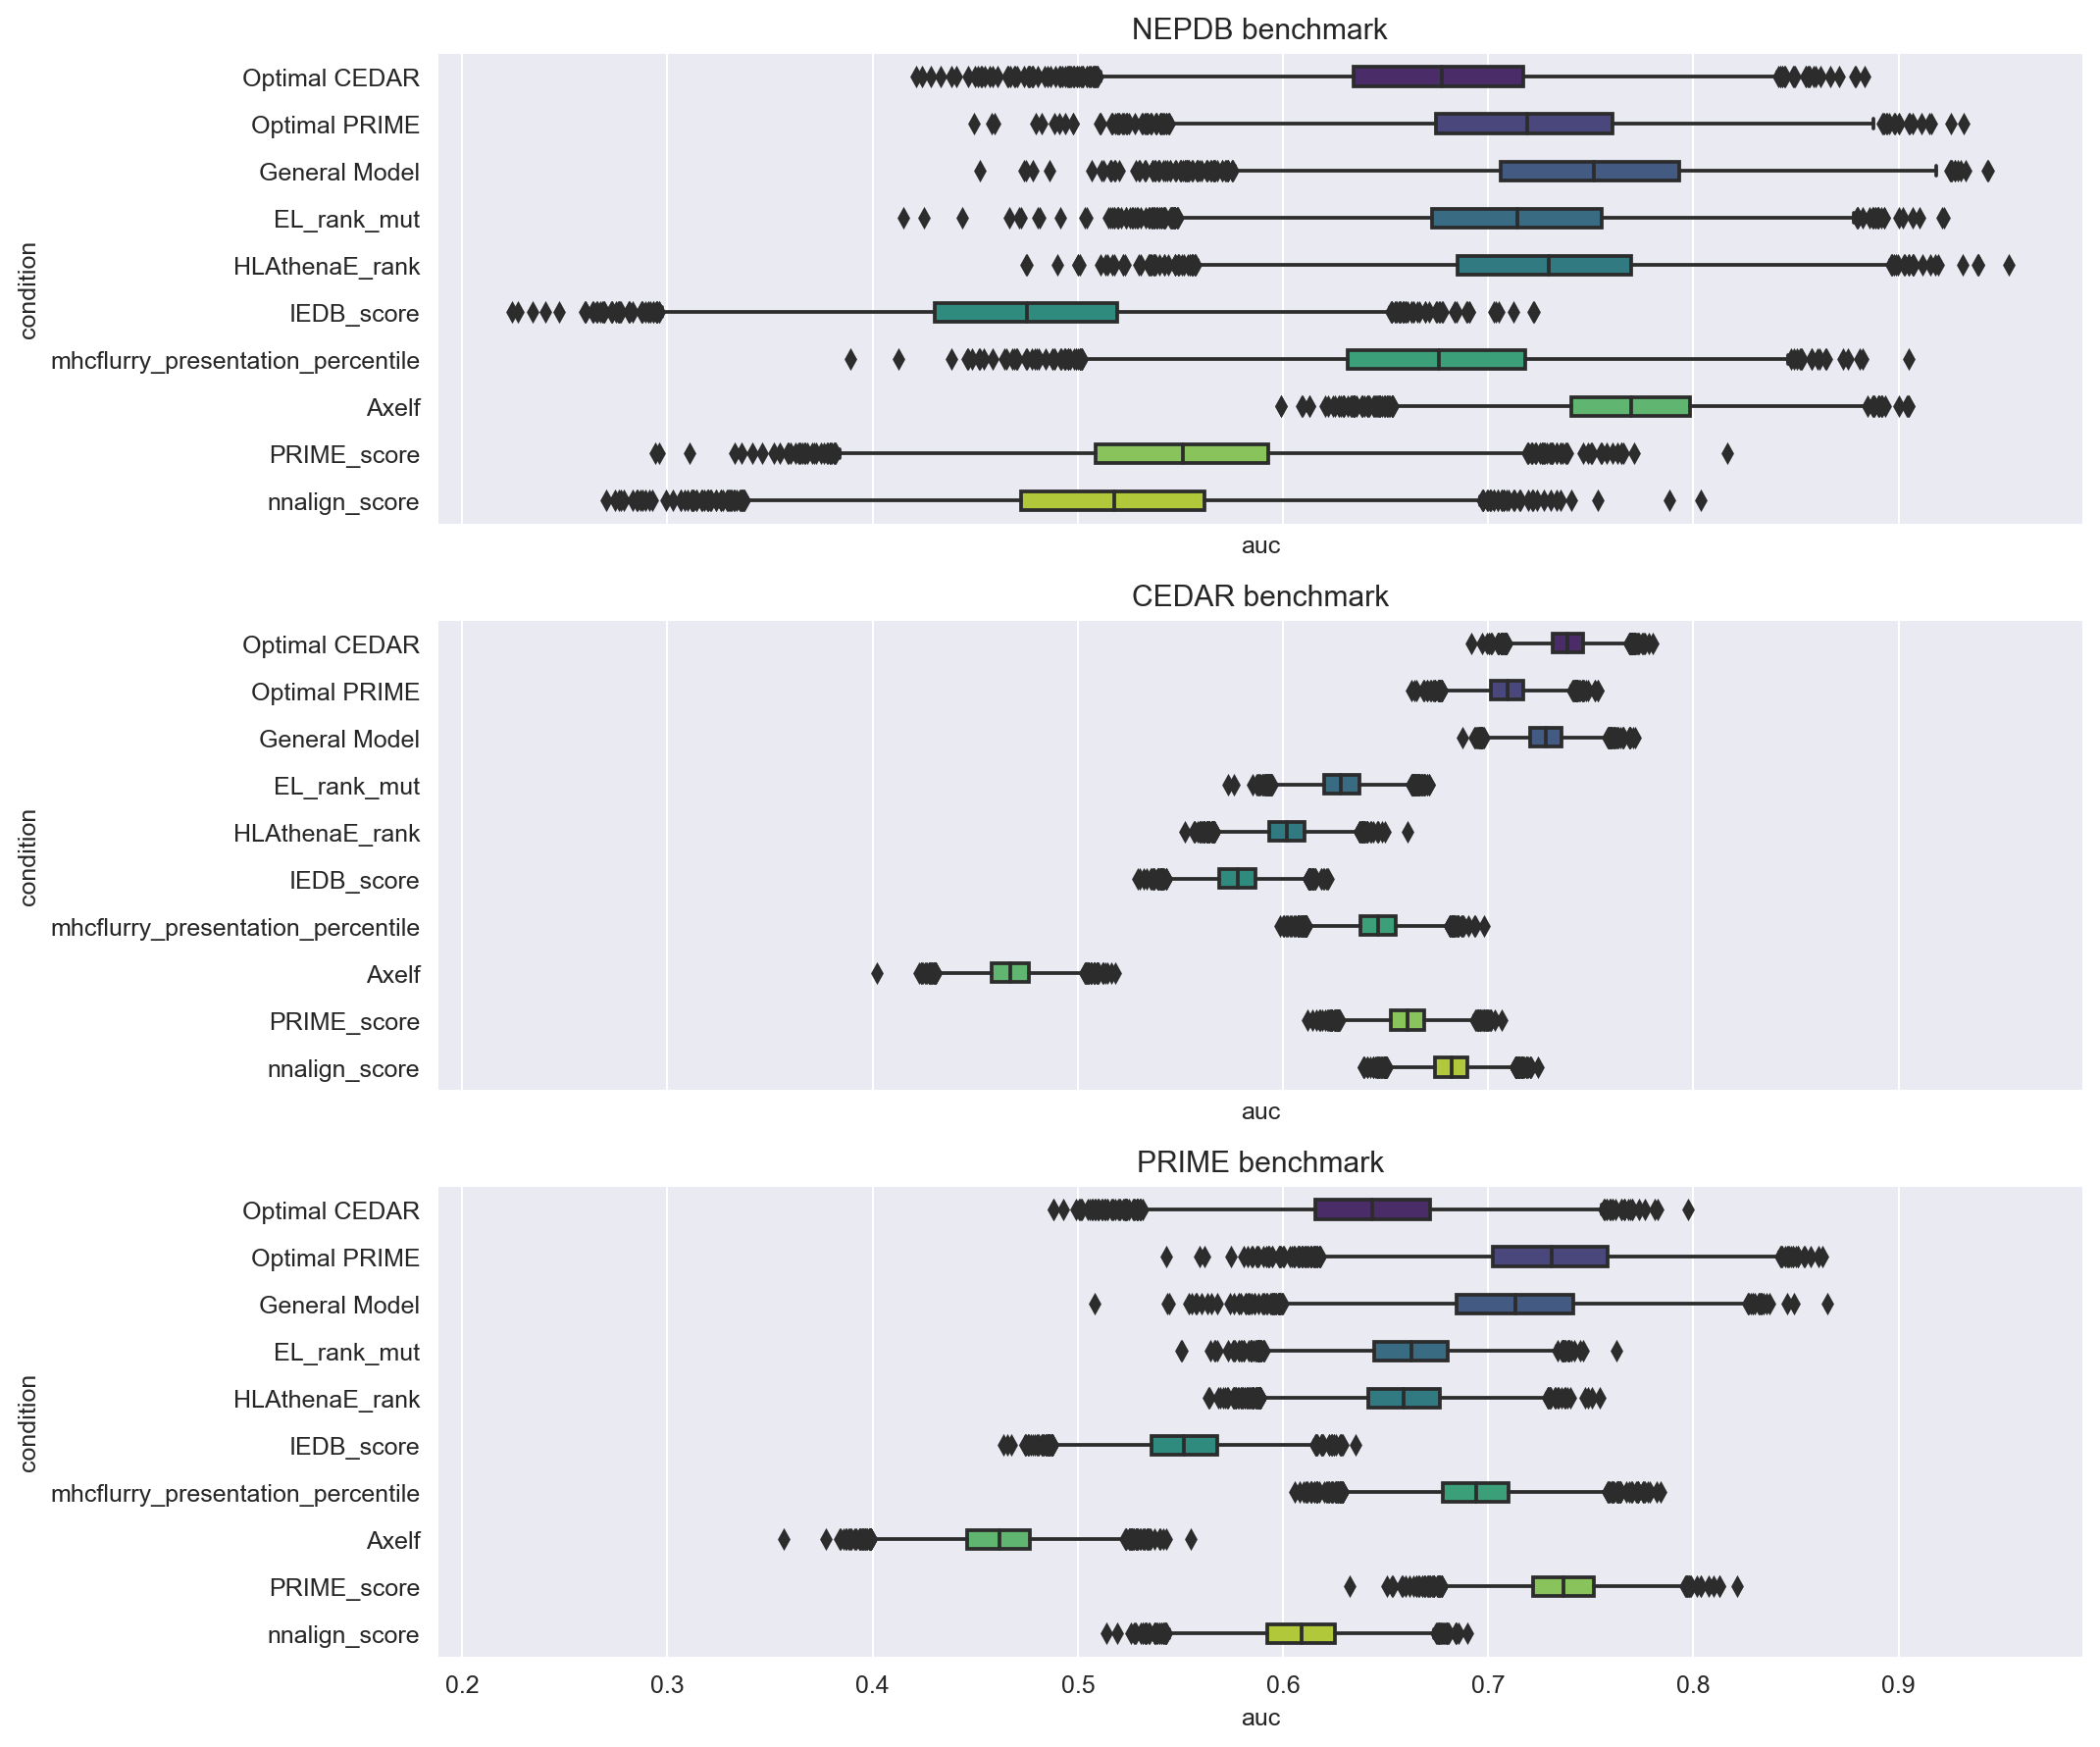

In [519]:
sns.set_palette('viridis')
f,a = plt.subplots(3,1, figsize=(12, 10), sharex=True)
for df, evalset, axis in zip([nepdb_bs_df, cedar_bs_df, prime_bs_df],
                             ['NEPDB', 'CEDAR', 'PRIME'],
                             a.ravel()):
    sns.set_palette('viridis')
    sns.boxplot(data=df.query('not condition.str.contains("affinity")', engine='python'), palette='viridis', y='condition', x='auc', ax=axis, width=0.4)
    axis.set_title(f'{evalset} benchmark')
f.tight_layout()

In [523]:
def get_auc_rocs(scores, labels):
    fpr, tpr, _ = roc_curve(labels, scores)
    auc = roc_auc_score(labels, scores)
    auc01 = roc_auc_score(labels, scores, max_fpr=0.1)
    return fpr, tpr, auc, auc01

In [577]:
columns = ['Optimal CEDAR', 'Optimal PRIME', 'General Model', 'Axelf', 'PRIME_score', 'nnalign_score', 'IEDB_score', 'EL_rank_mut', 'HLAthenaE_rank', 'mhcflurry_presentation_percentile']

rocs_cedar = {}
rocs_prime = {}
rocs_nepdb = {}
for df, nm, rocs_dict in zip([cedar_expr, prime_expr, nepdb_expr], 
                             ['cedar', 'prime', 'nepdb'], 
                             [rocs_cedar, rocs_prime, rocs_nepdb]):
    print(len(df))
    for c in tqdm(columns):
        print(c, len(df))
        if 'rank' in c or 'perc' in c:
            scores = 1-df[c].values
        else:
            scores = df[c].values
        labels = df['agg_label'].values
        c = name_map[c] if c in name_map.keys() else c
        rocs_dict[c] = get_auc_rocs(scores,labels)

2880


  0%|          | 0/10 [00:00<?, ?it/s]

Optimal CEDAR 2880
Optimal PRIME 2880
General Model 2880
Axelf 2880
PRIME_score 2880
nnalign_score 2880
IEDB_score 2880
EL_rank_mut 2880
HLAthenaE_rank 2880
mhcflurry_presentation_percentile 2880
2699


  0%|          | 0/10 [00:00<?, ?it/s]

Optimal CEDAR 2699
Optimal PRIME 2699
General Model 2699
Axelf 2699
PRIME_score 2699
nnalign_score 2699
IEDB_score 2699
EL_rank_mut 2699
HLAthenaE_rank 2699
mhcflurry_presentation_percentile 2699
232


  0%|          | 0/10 [00:00<?, ?it/s]

Optimal CEDAR 232
Optimal PRIME 232
General Model 232
Axelf 232
PRIME_score 232
nnalign_score 232
IEDB_score 232
EL_rank_mut 232
HLAthenaE_rank 232
mhcflurry_presentation_percentile 232


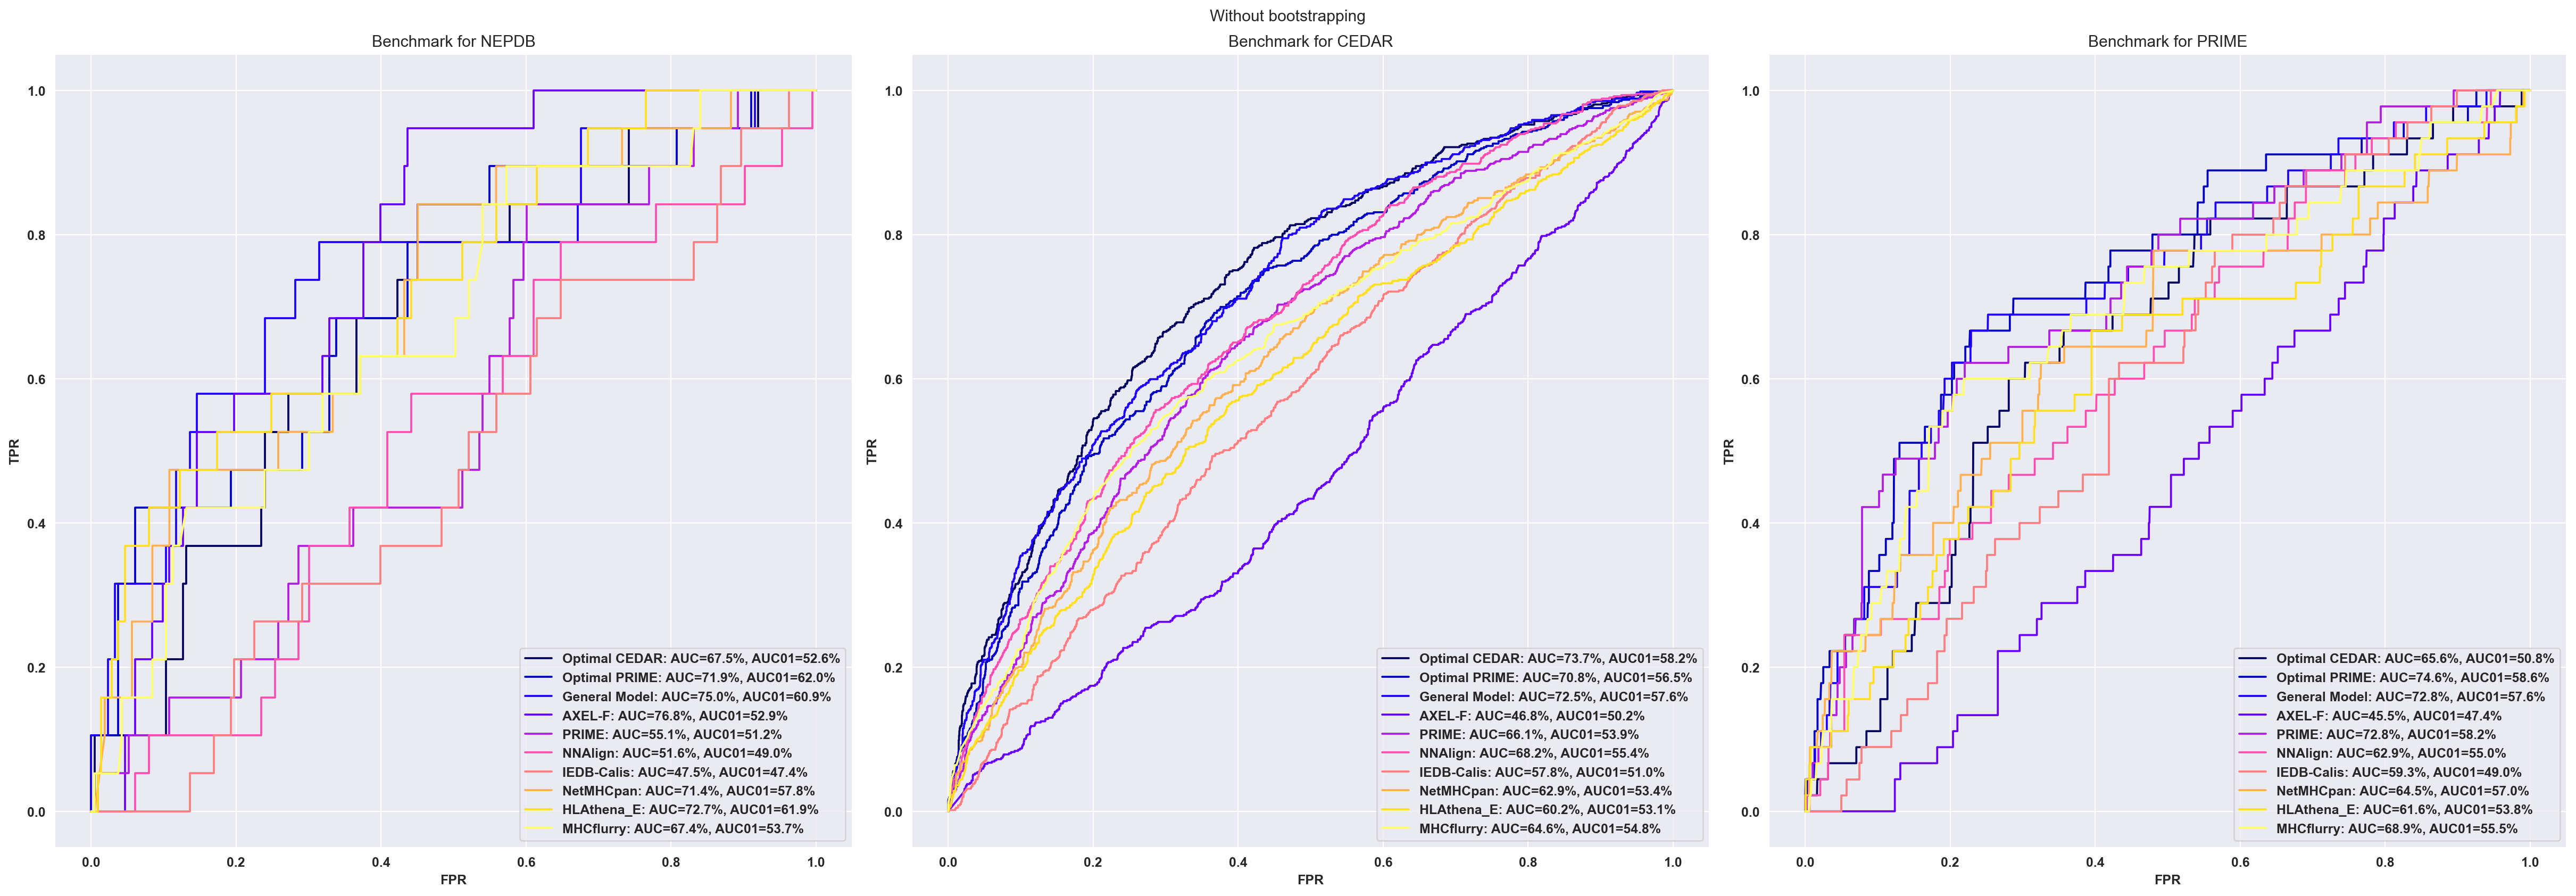

In [976]:
# sns.set_palette('gist_ncar', n_colors= len(rocs_cedar.keys()))
sns.set_palette(get_palette('gnuplot2', n_colors= len(rocs_cedar.keys())))

f,a = plt.subplots(1,3, figsize=(27,9.5))
for rocs, name, axis in zip([rocs_nepdb, rocs_cedar, rocs_prime], ['NEPDB', 'CEDAR', 'PRIME'], a.ravel()):
    axis.set_title(f'Benchmark for {name}')
    for c,v in rocs.items():
        fpr, tpr = v[0], v[1]
        auc, auc01 = v[2], v[3]
        sns.lineplot(x=fpr, y=tpr, label = f'{c}: AUC={auc:.1%}, AUC01={auc01:.1%}', ax=axis, estimator=None)
    axis.legend(loc='lower right', prop=dict(weight='semibold'))
    axis.set_xlabel('FPR', fontweight='semibold')
    axis.set_ylabel('TPR', fontweight='semibold')
    axis.set_xticklabels([-.2, 0., .2, .4, .6, .8,  1., 1.2], fontweight='semibold')
    axis.set_yticklabels([-.2, 0., .2, .4, .6, .8,  1., 1.2], fontweight='semibold')
f.suptitle('Without bootstrapping')
f.tight_layout()

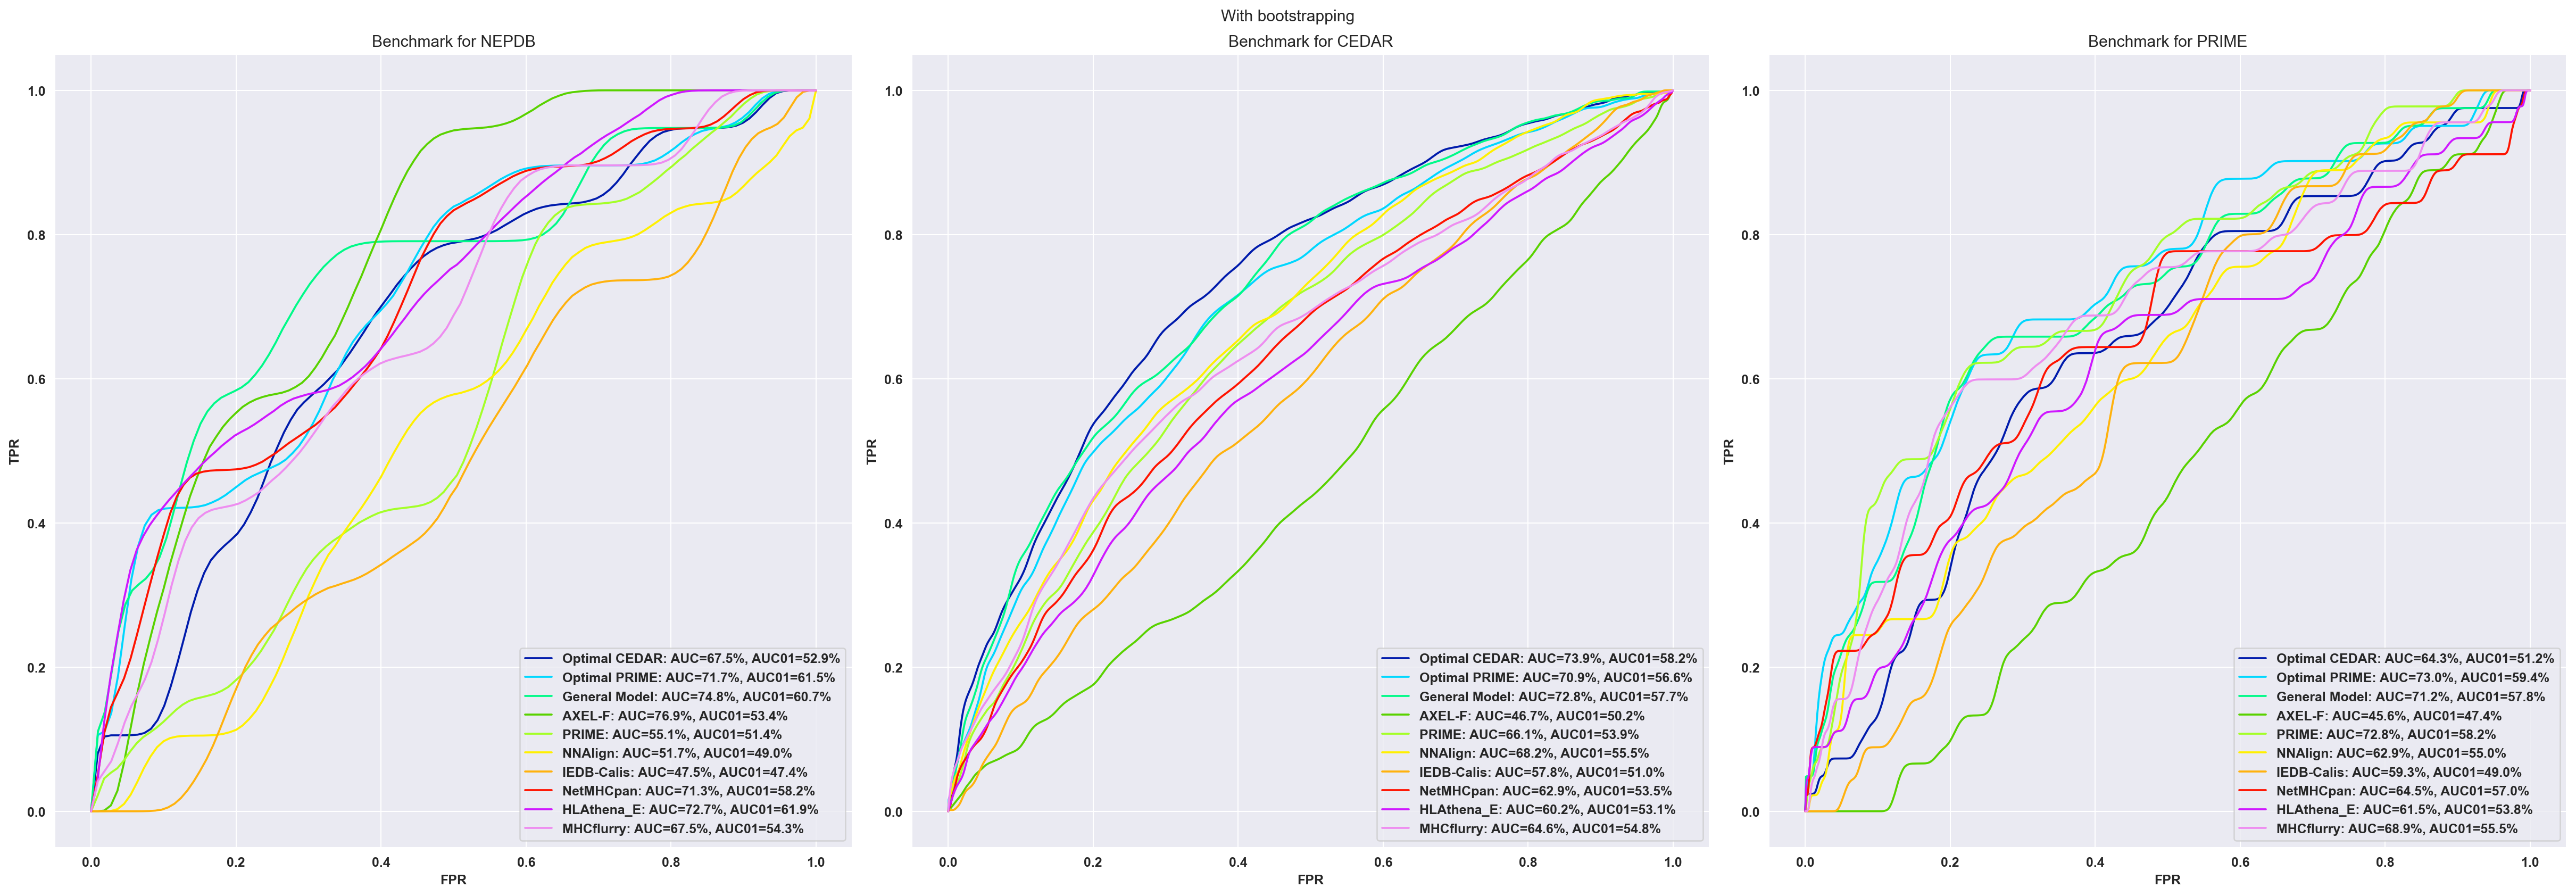

In [977]:
sns.set_palette('gist_ncar', n_colors=len(nepdb_rocs_dicts.keys()))
f,a = plt.subplots(1,3, figsize=(27,9.5))
for rocs, name, axis in zip([nepdb_rocs_dicts, cedar_rocs_dicts, prime_rocs_dicts], ['NEPDB', 'CEDAR', 'PRIME'], a.ravel()):
    axis.set_title(f'Benchmark for {name}')
    for c,v in rocs.items():
        if c == 'mhcflurry_affinity_percentile':continue
        fpr, tpr = v[0], v[1]
        auc, auc01 = v[4], v[5]
        k = name_map[c] if c in name_map.keys() else c
        sns.lineplot(x=fpr, y=tpr, label = f'{k}: AUC={auc:.1%}, AUC01={auc01:.1%}', ax=axis, estimator=None)
    axis.legend(loc='lower right', prop=dict(weight='semibold'))
    axis.set_xlabel('FPR', fontweight='semibold')
    axis.set_ylabel('TPR', fontweight='semibold')
    axis.set_xticklabels([-.2, 0., .2, .4, .6, .8,  1., 1.2], fontweight='semibold')
    axis.set_yticklabels([-.2, 0., .2, .4, .6, .8,  1., 1.2], fontweight='semibold')
f.suptitle('With bootstrapping')
f.tight_layout()

In [1190]:
gb_merged.sort_values('mean_auc_CEDAR', ascending=False).head()

encoding            weight  \
1024   onehot  Inverted Shannon   
1028   onehot  Inverted Shannon   
1025   onehot  Inverted Shannon   
1029   onehot  Inverted Shannon   
1030   onehot  Inverted Shannon   

                                                    key    pep_col  \
1024                            aa_props-Total Gene TPM  icore_mut   
1028       aa_props-icore_blsm_mut_score-Total Gene TPM  icore_mut   
1025                         aa_props-Total Peptide TPM  icore_mut   
1029    aa_props-icore_blsm_mut_score-Total Peptide TPM  icore_mut   
1030  aa_props-icore_blsm_mut_score-Total Scaled Pep...  icore_mut   

                 experiment  mean_auc_CEDAR  mean_precision_CEDAR  \
1024  aligned_expr_mutscore        0.738947              0.636710   
1028  aligned_expr_mutscore        0.738795              0.603103   
1025  aligned_expr_mutscore        0.738710              0.649620   
1029  aligned_expr_mutscore        0.738702              0.620257   
1030  aligned_expr_mutscore        0.738394              0.640228   

      mean_auc_PRIME  mean_precision_PRIME  mean_auc_IBEL  \
1024        0.642066              0.030175       0.527349   
1028        0.643171              0.032655       0.536610   
1025        0.641626              0.030175       0.526485   
1029        0.643426              0.032655       0.534946   
1030        0.642850              0.037611       0.544818   

      mean_precision_IBEL  mean_auc_NEPDB  mean_precision_NEPDB  mean_auc_agg  \
1024                  0.0        0.686590              0.332541      0.690506   
1028                  0.0        0.675169              0.398615      0.690983   
1025                  0.0        0.680928              0.332541      0.690168   
1029                  0.0        0.672941              0.398615      0.691064   
1030                  0.0        0.664791              0.398615      0.690622   

      mean_auc_std  Compromise  
1024      0.048441    0.779990  
1028      0.047812    0.780190  
1025      0.048542    0.779762  
1029      0.047638    0.780207  
1030      0.047772    0.779909